<a href="https://colab.research.google.com/github/abhisuj/MSDS-451-TermProject/blob/main/AGIG_ETF_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adaptive Global Income and Growth (AGIG) ETF Optimization

## 1. Setup

### 1.1. Install Dependencies

In [1]:
# It is recommended to run this in your terminal:
!pip install yfinance pymoo tensorflow pandas numpy matplotlib seaborn scikit-learn TA-Lib

# Note: Installing TA-Lib can be tricky.
# If you have issues, you may need to install the underlying C library first.
# For Windows, you can often find unofficial binaries. For Linux/Mac, use your package manager.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.8/303.8 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.6 MB/s eta 0:00:00


### 1.2. Imports

In [2]:
import warnings
import yfinance as yf
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import talib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import Huber

from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

# --- Setup ---
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

## 2. Configuration

In [3]:
# --- Portfolio & Data ---
PORTFOLIO_TICKERS = [
    'AAPL', 'GOOG', 'MSFT', 'NVDA', 'AMZN', 'AMD', 'INTC', 'META',
    'COST', 'PG', 'KO', 'PEP', 'WMT', 'CME', 'AVGO', 'PFE', 'ABBV', 'HD',
    'XOM', 'VDE', 'SCHD', 'VYM', 'VWO', 'VEA', 'GLD', 'SLV', 'FXY',
    'FDIVX', 'TLT', 'SPLB'
]
BENCHMARK_TICKER = 'SPY'
DATA_PERIOD = '25y'

# --- Feature Engineering ---
LOG_RETURN_CLIP = 0.20 # Clip log returns to +/- 20% to remove extreme outliers

# --- Bi-LSTM Model ---
LOOKBACK_WINDOW = 60 # Days of historical data to use for one prediction
TRAIN_SPLIT = 0.64
VALIDATION_SPLIT = 0.16 # 16% validation, 20% test
LSTM_UNITS = [128, 64, 32]
DROPOUT_RATE = 0.2
EPOCHS = 100
BATCH_SIZE = 32

# --- NSGA-II Optimization ---
POPULATION_SIZE = 100 # Reduced for faster example run, prototype used 500
N_GENERATIONS = 100   # Reduced for faster example run, prototype used 1000
TARGET_DIVIDEND_YIELD = 0.04 # 4% annual dividend yield
MIN_WEIGHT_PER_ASSET = 0.01 # 1% min allocation
MAX_WEIGHT_PER_ASSET = 0.10 # 10% max allocation

# --- Prediction Mode ---
# 'historical': Use model predictions on the test set for backtesting.
# 'future': Generate 30 new forward-looking predictions.
PREDICTION_MODE = 'historical'

## 3. Data Loading and Preprocessing

In [4]:
def load_price_data(tickers, period):
    """Downloads historical 'Close' prices from yfinance and preprocesses them."""
    print(f"Downloading {len(tickers)} tickers for period '{period}'...")
    # Download data
    data = yf.download(tickers, period=period, progress=False)

    # Get 'Close' prices and handle missing data
    close_data = pl.from_pandas(data['Close'].reset_index())
    close_data = close_data.drop_nulls()
    close_data = close_data.fill_null(strategy='forward').fill_null(strategy='backward')

    # Remove timezone from Date column to ensure consistency
    close_data = close_data.with_columns(
        pl.col('Date').dt.replace_time_zone(None)
    )

    print(f"✓ Price data shape: {close_data.shape}")
    return close_data

def load_dividend_data(tickers, price_data):
    """Downloads historical dividend data for the given tickers."""
    print(f"Downloading dividend data for {len(tickers)} tickers...")

    # Create a polars DataFrame with the same index as price_data
    date_index = price_data.select(pl.col('Date'))
    dividend_data = date_index.clone()
    for ticker in tickers:
        dividend_data = dividend_data.with_columns(pl.lit(0.0).alias(ticker))

    for ticker in tickers:
        try:
            dividends_series = yf.Ticker(ticker).dividends
            if not dividends_series.empty:
                # Convert pandas series to polars DataFrame
                dividends_df = pl.from_pandas(dividends_series.reset_index())
                dividends_df.columns = ['Date', ticker]

                # Remove timezone from Date column to match price_data
                dividends_df = dividends_df.with_columns(
                    pl.col('Date').dt.replace_time_zone(None)
                )

                # Left join and coalesce to merge the dividend data correctly
                dividend_data = dividend_data.join(dividends_df, on='Date', how='left', suffix='_new')
                dividend_data = dividend_data.with_columns(
                    pl.coalesce([pl.col(f"{ticker}_new"), pl.col(ticker)]).alias(ticker)
                ).drop(f"{ticker}_new")

        except Exception as e:
            print(f"- Could not retrieve dividend data for {ticker}: {e}")

    dividend_data = dividend_data.fill_null(0)
    print(f"✓ Dividend data shape: {dividend_data.shape}")
    return dividend_data

# --- Execute Data Loading ---
all_tickers = PORTFOLIO_TICKERS + [BENCHMARK_TICKER]
price_df = load_price_data(all_tickers, DATA_PERIOD)
dividend_df = load_dividend_data(PORTFOLIO_TICKERS, price_df)

print("\nPrice Data Tail:")
display(price_df.tail(3).to_pandas())
print("\nDividend Data Tail (showing columns with recent dividends):")
# Filter columns with recent dividends, excluding the 'Date' column from the comparison
ticker_cols = [col for col in dividend_df.columns if col != 'Date']
cols_with_dividends = [col for col in ticker_cols if (dividend_df[col][-100:] != 0).any()]
display(dividend_df.select(['Date'] + cols_with_dividends).tail(3).to_pandas())


✓ Price data shape: (3242, 32)
✓ Dividend data shape: (3242, 31)

Price Data Tail:


,Date,AAPL,ABBV,AMD,AMZN,AVGO,CME,COST,FDIVX,FXY,GLD,GOOG,HD,INTC,KO,META,MSFT,NVDA,PEP,PFE,PG,SCHD,SLV,SPLB,SPY,TLT,VDE,VEA,VWO,VYM,WMT,XOM
0,2025-11-17,267.459991,234.000000,240.520004,232.869995,342.649994,279.130005,912.590027,51.700001,59.240002,371.649994,285.600006,358.029999,34.709999,70.680000,602.010010,507.489990,186.600006,147.830002,25.080000,145.820007,27.00,45.470001,22.709999,665.669983,89.089996,127.050003,60.529999,54.220001,139.539993,102.949997,117.680000
1,2025-11-18,267.440002,233.869995,230.289993,222.550003,340.500000,279.279999,895.080017,50.959999,59.150002,374.350006,284.959991,336.480011,34.330002,71.220001,597.690002,493.790009,181.360001,148.770004,25.450001,146.990005,27.16,46.099998,22.719999,660.080017,89.059998,128.149994,59.910000,54.040001,139.509995,101.389999,119.029999
2,2025-11-19,268.559998,232.910004,223.550003,222.690002,354.420013,272.489990,890.599976,50.709999,58.610001,374.959991,292.989990,334.500000,35.110001,71.110001,590.320007,487.119995,186.520004,147.110001,24.879999,146.990005,26.93,46.450001,22.709999,662.630005,88.879997,126.629997,59.709999,53.919998,139.690002,100.610001,117.349998



Dividend Data Tail (showing columns with recent dividends):


,Date,AAPL,GOOG,MSFT,NVDA,META,COST,PG,KO,PEP,WMT,CME,AVGO,PFE,ABBV,HD,XOM,VDE,SCHD,VYM,VWO,VEA,TLT,SPLB
0,2025-11-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2025-11-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2025-11-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4. Feature Engineering

In [5]:
def create_features(price_data, tickers):
    """Generates a representative set of technical analysis features."""
    print(f"Generating features for {len(tickers)} tickers...")

    # Convert Polars DataFrame to pandas for processing
    price_data_pd = price_data.to_pandas().set_index('Date')

    # We need Open, High, Low, Close for many TA-Lib functions.
    # Let's download the full OHLCV data here.
    ohlcv_data = yf.download(tickers, period='25y', progress=False)

    # Collect all feature columns in a dictionary to avoid DataFrame fragmentation
    feature_dict = {}

    for ticker in tickers:
        # --- Shift data to prevent look-ahead bias ---
        # All features for day T must be calculated using data from T-1 or earlier.
        high = ohlcv_data[('High', ticker)].shift(1)
        low = ohlcv_data[('Low', ticker)].shift(1)
        close = ohlcv_data[('Close', ticker)].shift(1)
        volume = ohlcv_data[('Volume', ticker)].shift(1)

        # --- Momentum Indicators ---
        feature_dict[f'{ticker}_RSI'] = talib.RSI(close)
        macd, macd_signal, macd_hist = talib.MACD(close)
        feature_dict[f'{ticker}_MACD'] = macd
        feature_dict[f'{ticker}_MACD_SIGNAL'] = macd_signal
        feature_dict[f'{ticker}_MACD_HIST'] = macd_hist
        feature_dict[f'{ticker}_ADX'] = talib.ADX(high, low, close)

        # --- Volatility Indicators ---
        feature_dict[f'{ticker}_ATR'] = talib.ATR(high, low, close)
        upper, middle, lower = talib.BBANDS(close)
        feature_dict[f'{ticker}_BB_WIDTH'] = (upper - lower) / middle

        # --- Trend Indicators ---
        feature_dict[f'{ticker}_SMA_50'] = talib.SMA(close, timeperiod=50)
        feature_dict[f'{ticker}_EMA_200'] = talib.EMA(close, timeperiod=200)

        # --- Price Lags & Volume ---
        # Note: pct_change(lag) on shifted data correctly calculates the return from T-lag-1 to T-1.
        feature_dict[f'{ticker}_VOL_SMA_20'] = talib.SMA(volume, timeperiod=20)
        for lag in [1, 5, 10, 21]:
            feature_dict[f'{ticker}_LAG_{lag}'] = close.pct_change(lag)

    # Create DataFrame efficiently from dictionary
    features_df = pd.DataFrame(feature_dict, index=ohlcv_data.index)

    # --- Define Target Variable ---
    # The target is the next day's log return for each portfolio asset
    # This is calculated on the original (non-shifted) price data.
    target_df = np.log(price_data_pd[tickers] / price_data_pd[tickers].shift(1)).shift(-1)
    target_df = target_df.clip(-LOG_RETURN_CLIP, LOG_RETURN_CLIP) # Clip outliers

    # --- Combine and clean ---
    # Align features and targets on the same index
    combined_df = pd.concat([features_df, target_df.add_suffix('_TARGET')], axis=1)
    combined_df = combined_df.dropna()

    print(f"✓ Feature engineering complete. Shape: {combined_df.shape}")
    return combined_df

# --- Execute Feature Engineering ---
# We only create features for the assets in our portfolio, not the benchmark
features_and_target_df = create_features(price_df, PORTFOLIO_TICKERS)

print("\nFeatures and Target Data Tail:")
display(features_and_target_df.tail(3))


Generating features for 30 tickers...
✓ Feature engineering complete. Shape: (3041, 450)

Features and Target Data Tail:


,AAPL_RSI,AAPL_MACD,AAPL_MACD_SIGNAL,AAPL_MACD_HIST,AAPL_ADX,AAPL_ATR,AAPL_BB_WIDTH,AAPL_SMA_50,AAPL_EMA_200,AAPL_VOL_SMA_20,AAPL_LAG_1,AAPL_LAG_5,AAPL_LAG_10,AAPL_LAG_21,GOOG_RSI,GOOG_MACD,GOOG_MACD_SIGNAL,GOOG_MACD_HIST,GOOG_ADX,GOOG_ATR,GOOG_BB_WIDTH,GOOG_SMA_50,GOOG_EMA_200,GOOG_VOL_SMA_20,GOOG_LAG_1,GOOG_LAG_5,GOOG_LAG_10,GOOG_LAG_21,MSFT_RSI,MSFT_MACD,MSFT_MACD_SIGNAL,MSFT_MACD_HIST,MSFT_ADX,MSFT_ATR,MSFT_BB_WIDTH,MSFT_SMA_50,MSFT_EMA_200,MSFT_VOL_SMA_20,MSFT_LAG_1,MSFT_LAG_5,MSFT_LAG_10,MSFT_LAG_21,NVDA_RSI,NVDA_MACD,NVDA_MACD_SIGNAL,NVDA_MACD_HIST,NVDA_ADX,NVDA_ATR,NVDA_BB_WIDTH,NVDA_SMA_50,NVDA_EMA_200,NVDA_VOL_SMA_20,NVDA_LAG_1,NVDA_LAG_5,NVDA_LAG_10,NVDA_LAG_21,AMZN_RSI,AMZN_MACD,AMZN_MACD_SIGNAL,AMZN_MACD_HIST,AMZN_ADX,AMZN_ATR,AMZN_BB_WIDTH,AMZN_SMA_50,AMZN_EMA_200,AMZN_VOL_SMA_20,AMZN_LAG_1,AMZN_LAG_5,AMZN_LAG_10,AMZN_LAG_21,AMD_RSI,AMD_MACD,AMD_MACD_SIGNAL,AMD_MACD_HIST,AMD_ADX,AMD_ATR,AMD_BB_WIDTH,AMD_SMA_50,AMD_EMA_200,AMD_VOL_SMA_20,AMD_LAG_1,AMD_LAG_5,AMD_LAG_10,AMD_LAG_21,INTC_RSI,INTC_MACD,INTC_MACD_SIGNAL,INTC_MACD_HIST,INTC_ADX,INTC_ATR,INTC_BB_WIDTH,INTC_SMA_50,INTC_EMA_200,INTC_VOL_SMA_20,INTC_LAG_1,INTC_LAG_5,INTC_LAG_10,INTC_LAG_21,META_RSI,META_MACD,META_MACD_SIGNAL,META_MACD_HIST,META_ADX,META_ATR,META_BB_WIDTH,META_SMA_50,META_EMA_200,META_VOL_SMA_20,META_LAG_1,META_LAG_5,META_LAG_10,META_LAG_21,COST_RSI,COST_MACD,COST_MACD_SIGNAL,COST_MACD_HIST,COST_ADX,COST_ATR,COST_BB_WIDTH,COST_SMA_50,COST_EMA_200,COST_VOL_SMA_20,COST_LAG_1,COST_LAG_5,COST_LAG_10,COST_LAG_21,PG_RSI,PG_MACD,PG_MACD_SIGNAL,PG_MACD_HIST,PG_ADX,PG_ATR,PG_BB_WIDTH,PG_SMA_50,PG_EMA_200,PG_VOL_SMA_20,PG_LAG_1,PG_LAG_5,PG_LAG_10,PG_LAG_21,KO_RSI,KO_MACD,KO_MACD_SIGNAL,KO_MACD_HIST,KO_ADX,KO_ATR,KO_BB_WIDTH,KO_SMA_50,KO_EMA_200,KO_VOL_SMA_20,KO_LAG_1,KO_LAG_5,KO_LAG_10,KO_LAG_21,PEP_RSI,PEP_MACD,PEP_MACD_SIGNAL,PEP_MACD_HIST,PEP_ADX,PEP_ATR,PEP_BB_WIDTH,PEP_SMA_50,PEP_EMA_200,PEP_VOL_SMA_20,PEP_LAG_1,PEP_LAG_5,PEP_LAG_10,PEP_LAG_21,WMT_RSI,WMT_MACD,WMT_MACD_SIGNAL,WMT_MACD_HIST,WMT_ADX,WMT_ATR,WMT_BB_WIDTH,WMT_SMA_50,WMT_EMA_200,WMT_VOL_SMA_20,WMT_LAG_1,WMT_LAG_5,WMT_LAG_10,WMT_LAG_21,CME_RSI,CME_MACD,CME_MACD_SIGNAL,CME_MACD_HIST,CME_ADX,CME_ATR,CME_BB_WIDTH,CME_SMA_50,CME_EMA_200,CME_VOL_SMA_20,CME_LAG_1,CME_LAG_5,CME_LAG_10,CME_LAG_21,AVGO_RSI,AVGO_MACD,AVGO_MACD_SIGNAL,AVGO_MACD_HIST,AVGO_ADX,AVGO_ATR,AVGO_BB_WIDTH,AVGO_SMA_50,AVGO_EMA_200,AVGO_VOL_SMA_20,AVGO_LAG_1,AVGO_LAG_5,AVGO_LAG_10,AVGO_LAG_21,PFE_RSI,PFE_MACD,PFE_MACD_SIGNAL,PFE_MACD_HIST,PFE_ADX,PFE_ATR,PFE_BB_WIDTH,PFE_SMA_50,PFE_EMA_200,PFE_VOL_SMA_20,PFE_LAG_1,PFE_LAG_5,PFE_LAG_10,PFE_LAG_21,ABBV_RSI,ABBV_MACD,ABBV_MACD_SIGNAL,ABBV_MACD_HIST,ABBV_ADX,ABBV_ATR,ABBV_BB_WIDTH,ABBV_SMA_50,ABBV_EMA_200,ABBV_VOL_SMA_20,ABBV_LAG_1,ABBV_LAG_5,ABBV_LAG_10,ABBV_LAG_21,HD_RSI,HD_MACD,HD_MACD_SIGNAL,HD_MACD_HIST,HD_ADX,HD_ATR,HD_BB_WIDTH,HD_SMA_50,HD_EMA_200,HD_VOL_SMA_20,HD_LAG_1,HD_LAG_5,HD_LAG_10,HD_LAG_21,XOM_RSI,XOM_MACD,XOM_MACD_SIGNAL,XOM_MACD_HIST,XOM_ADX,XOM_ATR,XOM_BB_WIDTH,XOM_SMA_50,XOM_EMA_200,XOM_VOL_SMA_20,XOM_LAG_1,XOM_LAG_5,XOM_LAG_10,XOM_LAG_21,VDE_RSI,VDE_MACD,VDE_MACD_SIGNAL,VDE_MACD_HIST,VDE_ADX,VDE_ATR,VDE_BB_WIDTH,VDE_SMA_50,VDE_EMA_200,VDE_VOL_SMA_20,VDE_LAG_1,VDE_LAG_5,VDE_LAG_10,VDE_LAG_21,SCHD_RSI,SCHD_MACD,SCHD_MACD_SIGNAL,SCHD_MACD_HIST,SCHD_ADX,SCHD_ATR,SCHD_BB_WIDTH,SCHD_SMA_50,SCHD_EMA_200,SCHD_VOL_SMA_20,SCHD_LAG_1,SCHD_LAG_5,SCHD_LAG_10,SCHD_LAG_21,VYM_RSI,VYM_MACD,VYM_MACD_SIGNAL,VYM_MACD_HIST,VYM_ADX,VYM_ATR,VYM_BB_WIDTH,VYM_SMA_50,VYM_EMA_200,VYM_VOL_SMA_20,VYM_LAG_1,VYM_LAG_5,VYM_LAG_10,VYM_LAG_21,VWO_RSI,VWO_MACD,VWO_MACD_SIGNAL,VWO_MACD_HIST,VWO_ADX,VWO_ATR,VWO_BB_WIDTH,VWO_SMA_50,VWO_EMA_200,VWO_VOL_SMA_20,VWO_LAG_1,VWO_LAG_5,VWO_LAG_10,VWO_LAG_21,VEA_RSI,VEA_MACD,VEA_MACD_SIGNAL,VEA_MACD_HIST,VEA_ADX,VEA_ATR,VEA_BB_WIDTH,VEA_SMA_50,VEA_EMA_200,VEA_VOL_SMA_20,VEA_LAG_1,VEA_LAG_5,VEA_LAG_10,VEA_LAG_21,GLD_RSI,GLD_MACD,GLD_MACD_SIGNAL,GLD_MACD_HIST,GLD_ADX,GLD_ATR,GLD_BB_WIDTH,GLD_SMA_50,GLD_EMA_200,GLD_VOL_SMA_20,GLD_LAG_1,GLD_LAG_5,GLD_LAG_1

## 5. Bi-LSTM Model

In [6]:
# --- 1. Data Preparation ---
print("Preparing data for LSTM model...")
feature_cols = [c for c in features_and_target_df.columns if not c.endswith('_TARGET')]
target_cols = [c for c in features_and_target_df.columns if c.endswith('_TARGET')]

X = features_and_target_df[feature_cols].values
y = features_and_target_df[target_cols].values

feature_scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaler = MinMaxScaler(feature_range=(-1, 1))

X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y)

# --- 2. Create Sequences ---
def create_sequences(X_data, y_data, window_size):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - window_size):
        X_seq.append(X_data[i:(i + window_size)])
        y_seq.append(y_data[i + window_size])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, LOOKBACK_WINDOW)

# --- 3. Train/Val/Test Split (Temporal) ---
n_samples = len(X_seq)
train_end = int(n_samples * TRAIN_SPLIT)
val_end = int(n_samples * (TRAIN_SPLIT + VALIDATION_SPLIT))

X_train, y_train = X_seq[:train_end], y_seq[:train_end]
X_val, y_val = X_seq[train_end:val_end], y_seq[train_end:val_end]
X_test, y_test = X_seq[val_end:], y_seq[val_end:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# --- 4. Model Architecture & Training ---
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

@tf.keras.utils.register_keras_serializable()
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        return K.sum(output, axis=1)

input_shape = (X_train.shape[1], X_train.shape[2])
output_shape = y_train.shape[1]

def create_bilstm_attention_model(input_shape, output_shape, lstm_units, dropout_rate):
    inputs = tf.keras.Input(shape=input_shape)
    x = Bidirectional(LSTM(lstm_units[0], return_sequences=True))(inputs)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(lstm_units[1], return_sequences=True))(x)
    x = Dropout(dropout_rate)(x)
    x = Attention()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(output_shape, activation='tanh')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss=Huber())
    return model

model = create_bilstm_attention_model(input_shape, output_shape, LSTM_UNITS, DROPOUT_RATE)
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('bilstm_best_model.keras', save_best_only=True, monitor='val_loss')


Preparing data for LSTM model...
X_train shape: (1907, 60, 420), y_train shape: (1907, 30)
X_val shape: (477, 60, 420), y_val shape: (477, 30)
X_test shape: (597, 60, 420), y_test shape: (597, 30)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 420)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 60, 256)        │       562,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 60, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 128)            │           188 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 730,586 (2.79 MB)

 Trainable params: 730,586 (2.79 MB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training ---
Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 364ms/step - loss: 0.0193 - val_loss: 0.0103
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - loss: 0.0085 - val_loss: 0.0100
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - loss: 0.0079 - val_loss: 0.0098
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 353ms/step - loss: 0.0077 - val_loss: 0.0098
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 343ms/step - loss: 0.0077 - val_loss: 0.0097
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 371ms/step - loss: 0.0074 - val_loss: 0.0099
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 331ms/step - loss: 0.0073 - val_loss: 0.0098
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 347ms/step - loss: 0.0076 - val_loss: 0.0097
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 352ms/step - loss: 0.0080 - val_loss: 0.0097
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 371ms/step - loss: 0.0074 - val_loss: 0.0097
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 352ms/step - loss: 0.0077 - val_loss: 0.00

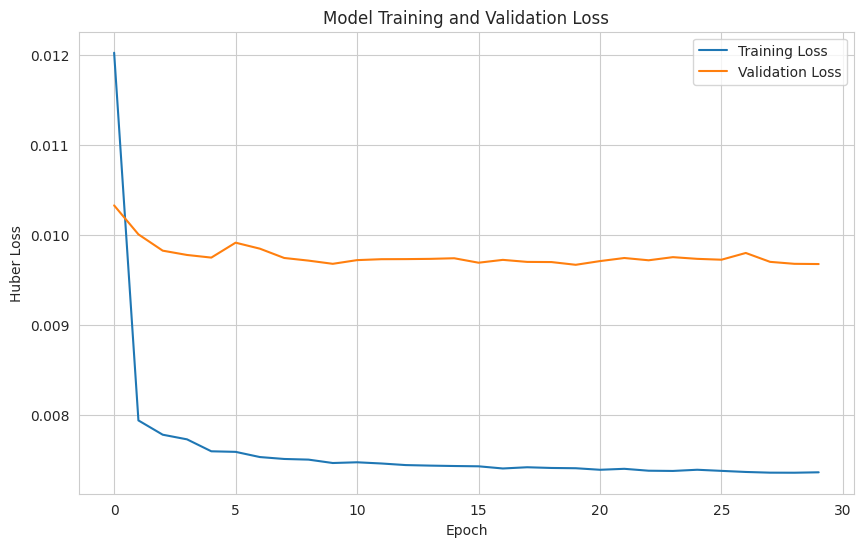

In [7]:
print("\n--- Starting Model Training ---")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
print("--- Model Training Complete ---")

# --- 5. Plot Training History ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()
plt.show()

## 6. NSGA-II Optimization

Generating predictions from the trained Bi-LSTM model...
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step
✓ Predicted returns generated. Shape: (597, 30)

--- Starting NSGA-II Optimization ---
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      8 |  0.000000E+00 |  9.658940E-17 |             - |             -
     2 |      200 |     10 |  0.000000E+00 |  1.221245E-17 |  0.2542779972 |         ideal
     3 |      300 |     17 |  0.000000E+00 |  0.000000E+00 |  0.0632258707 |         nadir
     4 |      400 |     24 |  0.000000E+00 |  0.000000E+00 |  0.0752359726 |             f
     5 |      500 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0844947339 |         ideal
     6 |      600 |     18 |  0.000000E+00 |  0.000000E+00 |  0.0368131714 |         ideal
     7 |      700 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0468784542 |         ideal
     8 |      800 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0627506571 |         id

,Return,Dividend,Volatility,CVaR_95,Sharpe,AAPL,GOOG,MSFT,NVDA,AMZN,AMD,INTC,META,COST,PG,KO,PEP,WMT,CME,AVGO,PFE,ABBV,HD,XOM,VDE,SCHD,VYM,VWO,VEA,GLD,SLV,FXY,FDIVX,TLT,SPLB
88,0.358325,2.483428,0.111242,-0.039297,3.041335,0.008380,0.013132,0.075032,0.008711,0.010947,0.010607,0.011998,0.011477,0.072403,0.023435,0.081976,0.081157,0.008684,0.078911,0.014109,0.072084,0.032966,0.076348,0.012604,0.008518,0.017148,0.020654,0.020839,0.014077,0.077924,0.075804,0.010387,0.010942,0.027598,0.011147
0,0.402773,2.471940,0.126793,-0.024765,3.018874,0.008383,0.012287,0.074290,0.009799,0.010787,0.059439,0.011658,0.019443,0.074747,0.023211,0.079734,0.077531,0.009334,0.074206,0.015101,0.070126,0.032905,0.073604,0.011894,0.009864,0.016755,0.023290,0.036096,0.012585,0.012955,0.072628,0.009139,0.013354,0.029207,0.015648
8,0.397066,2.490141,0.127591,-0.028885,2.955283,0.008572,0.012588,0.074577,0.008635,0.010741,0.060427,0.011921,0.020174,0.078503,0.023937,0.060825,0.074950,0.011361,0.075882,0.013946,0.071683,0.033649,0.073481,0.014836,0.009960,0.020252,0.022171,0.020796,0.016882,0.012521,0.074270,0.009376,0.027216,0.029868,0.016005
18,0.382817,2.346495,0.123768,-0.020800,2.931424,0.007865,0.011529,0.068426,0.009194,0.010001,0.055769,0.010939,0.018355,0.070132,0.021778,0.074812,0.069248,0.073526,0.069625,0.014175,0.065796,0.030874,0.069060,0.011160,0.008811,0.019386,0.020342,0.033867,0.011808,0.012155,0.068145,0.008602,0.012530,0.027404,0.014685
50,0.343492,2.457395,0.110934,-0.045034,2.916073,0.008354,0.013182,0.075319,0.010087,0.010926,0.010648,0.012044,0.011521,0.072681,0.024122,0.082292,0.081468,0.008717,0.076607,0.014162,0.072361,0.033093,0.070624,0.014797,0.009312,0.017214,0.020733,0.020932,0.014131,0.078077,0.076095,0.010571,0.010984,0.027704,0.011244


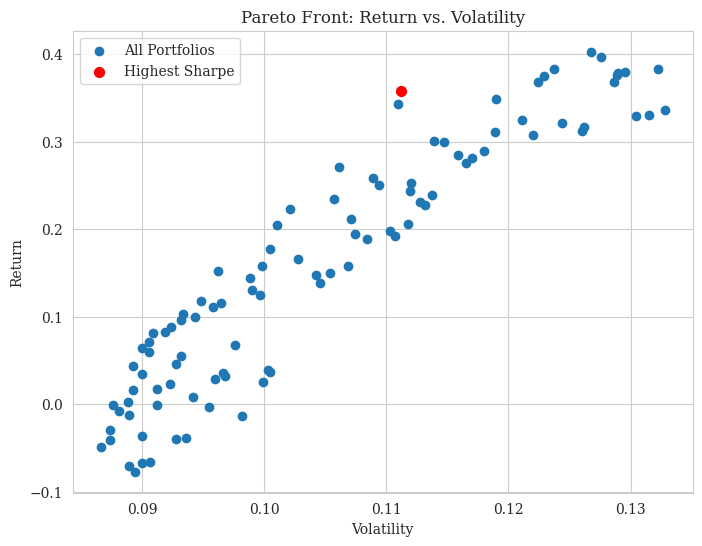

In [8]:
# --- 1. Generate Predictions from Trained Model ---
print("Generating predictions from the trained Bi-LSTM model...")
# Load the best model saved during training
best_model = tf.keras.models.load_model('bilstm_best_model.keras', custom_objects={'Huber': Huber, 'Attention': Attention})

# Predict on the test set
test_predictions_scaled = best_model.predict(X_test)

# Inverse transform the predictions and actuals to get log returns
predicted_log_returns = target_scaler.inverse_transform(test_predictions_scaled)
actual_log_returns = target_scaler.inverse_transform(y_test)

# Convert log returns to simple returns
predicted_simple_returns = np.expm1(predicted_log_returns)
actual_simple_returns = np.expm1(actual_log_returns)

predicted_returns_df = pd.DataFrame(predicted_simple_returns, columns=PORTFOLIO_TICKERS)

print(f"✓ Predicted returns generated. Shape: {predicted_returns_df.shape}")

# --- 2. Define the NSGA-II Optimization Problem ---
class PortfolioOptimizationProblem(Problem):
    def __init__(self, mu, sigma, dividend_yields, predicted_returns_timeseries, min_weight, max_weight, target_dividend):
        super().__init__(n_var=len(mu),
                         n_obj=4,
                         n_constr=2, # sum of weights = 1, dividend yield >= target
                         xl=min_weight,
                         xu=max_weight)
        self.mu = mu
        self.sigma = sigma
        self.dividend_yields = dividend_yields
        self.predicted_returns_timeseries = predicted_returns_timeseries # For CVaR calculation
        self.target_dividend = target_dividend

    def _evaluate(self, x, out, *args, **kwargs):
        # Normalize weights to ensure they sum to 1
        weights = x / x.sum(axis=1, keepdims=True)

        # 1. Maximize Annualized Return (minimize negative return)
        # Using matrix multiplication: mu_portfolio = weights.T @ mu
        f1 = -np.dot(weights, self.mu) * 252

        # 2. Maximize Dividend Yield (minimize negative yield)
        f2 = -np.sum(weights * self.dividend_yields, axis=1)

        # 3. Minimize Annualized Volatility
        # Using matrix multiplication: sigma_portfolio = sqrt(weights.T @ Sigma @ weights)
        portfolio_volatility = [np.sqrt(np.dot(w.T, np.dot(self.sigma, w))) for w in weights]
        f3 = np.array(portfolio_volatility) * np.sqrt(252)

        # 4. Minimize CVaR (95%)
        # CVaR is harder to express with matrix algebra, so we use the predicted timeseries here
        portfolio_returns_ts = (self.predicted_returns_timeseries @ weights.T)
        q = np.percentile(portfolio_returns_ts, 5, axis=0)
        cvar = [np.mean(pr[pr <= q_val]) for pr, q_val in zip(portfolio_returns_ts.T, q)]
        f4 = -np.array(cvar) * 252 # Minimize CVaR (less negative is better)

        out["F"] = np.column_stack([f1, f2, f3, f4])

        # --- Constraints ---
        # Constraint 1: sum of weights must be 1 (pymoo handles this as g <= 0)
        g1 = np.abs(np.sum(weights, axis=1) - 1.0)

        # Constraint 2: portfolio dividend yield must be >= target
        g2 = self.target_dividend - np.sum(weights * self.dividend_yields, axis=1)

        out["G"] = np.column_stack([g1, g2])

# --- 3. Run the Optimization ---
print("\n--- Starting NSGA-II Optimization ---")
# Calculate average annual dividend yield for each asset
# Convert polars DFs to pandas for this section
price_df_pd = price_df.to_pandas().set_index('Date')
dividend_df_pd = dividend_df.to_pandas().set_index('Date')

# --- Prepare inputs for the optimizer ---
# Expected Returns (mu) from Bi-LSTM predictions
mu = predicted_returns_df.mean().values

# Expected Covariance (Sigma) from 60-day historical data before the test period
cov_start_date = features_and_target_df.index[val_end] # Start of test period
cov_period_returns = price_df_pd.loc[:cov_start_date, PORTFOLIO_TICKERS].pct_change().dropna().tail(60)
sigma = cov_period_returns.cov().values

n_years = len(price_df_pd.index.year.unique())
avg_annual_yield = (dividend_df_pd.sum() / n_years).values

problem = PortfolioOptimizationProblem(mu, sigma,
                                     avg_annual_yield,
                                     predicted_returns_df.values, # Pass full timeseries for CVaR
                                     MIN_WEIGHT_PER_ASSET,
                                     MAX_WEIGHT_PER_ASSET,
                                     TARGET_DIVIDEND_YIELD)

algorithm = NSGA2(pop_size=POPULATION_SIZE)

res = minimize(problem,
               algorithm,
               ('n_gen', N_GENERATIONS),
               seed=1,
               verbose=True)

print("--- Optimization Complete ---")

# --- 4. Process and Display Results ---
pareto_weights = res.X
pareto_objectives = res.F

# Normalize weights again to be safe
pareto_weights = pareto_weights / pareto_weights.sum(axis=1, keepdims=True)

pareto_front_df = pd.DataFrame({
    'Return': -pareto_objectives[:, 0],
    'Dividend': -pareto_objectives[:, 1],
    'Volatility': pareto_objectives[:, 2],
    'CVaR_95': -pareto_objectives[:, 3]
})
pareto_front_df['Sharpe'] = (pareto_front_df['Return'] - 0.02) / pareto_front_df['Volatility'] # Assuming 2% risk-free rate

weights_df = pd.DataFrame(pareto_weights, columns=PORTFOLIO_TICKERS)
pareto_results = pd.concat([pareto_front_df, weights_df], axis=1)

print("\nPareto Front Optimal Portfolios:")
display(pareto_results.sort_values('Sharpe', ascending=False).head())

# --- 5. Visualize the Pareto Front ---
plot = Scatter(title = "Pareto Front: Return vs. Volatility",
               labels=["Volatility", "Return"],
               legend=True)
plot.add(pareto_objectives[:, [2, 0]] * np.array([1, -1]), label="All Portfolios")

# Highlight the portfolio with the highest Sharpe ratio
best_sharpe_idx = pareto_results['Sharpe'].idxmax()
best_sharpe_portfolio = pareto_objectives[best_sharpe_idx, [2, 0]] * np.array([1, -1])
plot.add(best_sharpe_portfolio, color="red", s=50, label="Highest Sharpe")

plot.show()

## 7. Backtesting

Selecting portfolio with the highest Sharpe Ratio for backtesting...

Selected Portfolio Weights (allocations > 1%):


,88
KO,0.081976
PEP,0.081157
CME,0.078911
GLD,0.077924
HD,0.076348
SLV,0.075804
MSFT,0.075032
COST,0.072403
PFE,0.072084
ABBV,0.032966



Backtest Performance Summary:


,Optimized Portfolio,Benchmark (SPY)
Cumulative Return,50.42%,55.15%
Annualized Return,17.73%,19.77%
Annualized Volatility,9.96%,15.73%
Sharpe Ratio,1.58,1.13
Max Drawdown,-9.74%,-18.76%


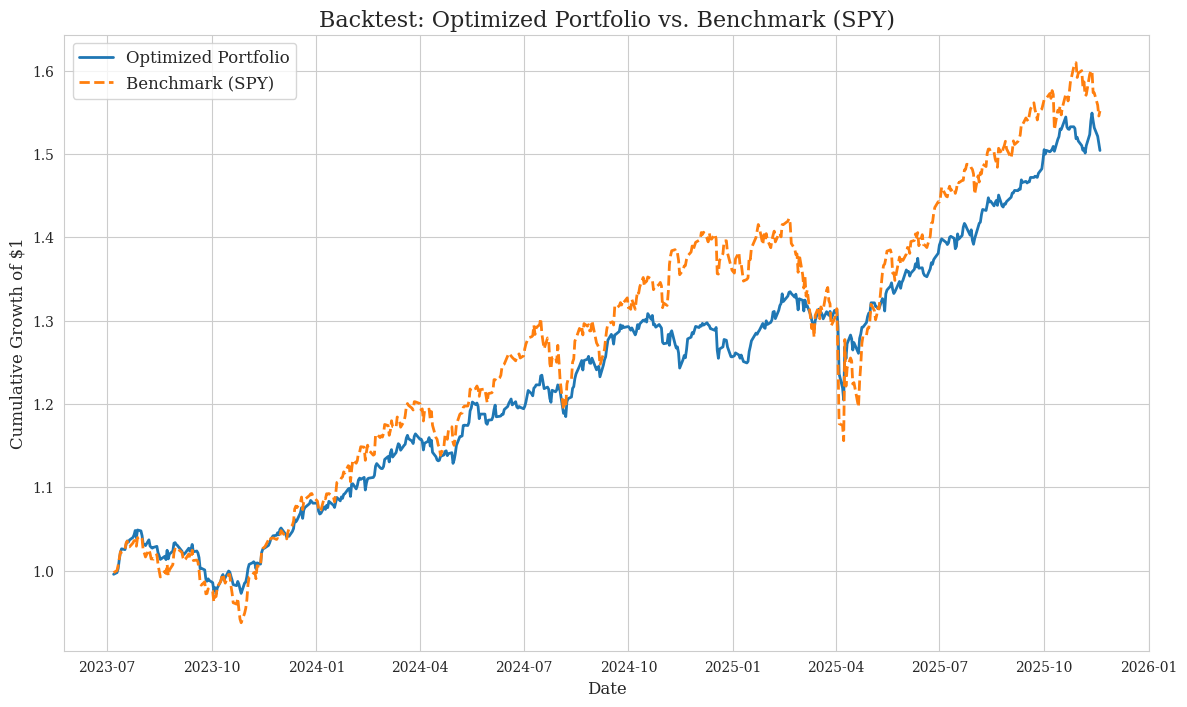

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Select the Best Portfolio for Backtesting ---
print("Selecting portfolio with the highest Sharpe Ratio for backtesting...")
best_sharpe_idx = pareto_results['Sharpe'].idxmax()
selected_portfolio = pareto_results.loc[best_sharpe_idx]
selected_weights = selected_portfolio[PORTFOLIO_TICKERS]

print("\nSelected Portfolio Weights (allocations > 1%):")
display(selected_weights[selected_weights > 0.01].sort_values(ascending=False))

# --- 2. Calculate Historical Performance ---
# Use the ACTUAL returns from the test period, not the predicted returns
test_dates_start = features_and_target_df.index[val_end + LOOKBACK_WINDOW]

# Removed redundant calculations. Assuming 'price_df_pd' is the correct DataFrame.
actual_returns_test = price_df_pd.loc[test_dates_start:, PORTFOLIO_TICKERS].pct_change().dropna()
benchmark_returns_test = price_df_pd.loc[test_dates_start:, BENCHMARK_TICKER].pct_change().dropna()

# Align indices before matrix multiplication
aligned_weights = selected_weights.values
aligned_returns, aligned_benchmark = actual_returns_test.align(benchmark_returns_test, join='inner', axis=0)

portfolio_historical_returns = (aligned_returns * aligned_weights).sum(axis=1)

# --- 3. Calculate Performance Metrics ---
def calculate_metrics(returns, risk_free_rate=0.02):
    """Calculates key performance metrics for a series of returns."""
    if returns.empty:
        return pd.Series({k: 'N/A' for k in ['Cumulative Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown']})

    cumulative_return = (1 + returns).prod() - 1
    annualized_return = returns.mean() * 252
    annualized_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility != 0 else 0

    # Max Drawdown Calculation
    cumulative_wealth = (1 + returns).cumprod()
    peak = cumulative_wealth.cummax()
    drawdown = (cumulative_wealth - peak) / peak
    max_drawdown = drawdown.min()

    return pd.Series({
        'Cumulative Return': f"{cumulative_return:.2%}",
        'Annualized Return': f"{annualized_return:.2%}",
        'Annualized Volatility': f"{annualized_volatility:.2%}",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Max Drawdown': f"{max_drawdown:.2%}"
    })

# Define the risk-free rate as a constant for clarity
RISK_FREE_RATE = 0.02
portfolio_metrics = calculate_metrics(portfolio_historical_returns, risk_free_rate=RISK_FREE_RATE)
benchmark_metrics = calculate_metrics(aligned_benchmark, risk_free_rate=RISK_FREE_RATE)

performance_summary = pd.DataFrame({'Optimized Portfolio': portfolio_metrics, 'Benchmark (SPY)': benchmark_metrics})

print("\nBacktest Performance Summary:")
display(performance_summary)

# --- 5. Visualize Performance ---
plt.figure(figsize=(14, 8))

# Use the pre-aligned returns series for consistency and robustness
cumulative_portfolio_returns = (1 + portfolio_historical_returns).cumprod()
cumulative_benchmark_returns = (1 + aligned_benchmark).cumprod()

plt.plot(cumulative_portfolio_returns.index, cumulative_portfolio_returns, label='Optimized Portfolio', lw=2)
plt.plot(cumulative_benchmark_returns.index, cumulative_benchmark_returns, label='Benchmark (SPY)', linestyle='--', lw=2)

plt.title('Backtest: Optimized Portfolio vs. Benchmark (SPY)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Growth of $1', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


# Task
Refactor the existing portfolio optimization notebook to enhance the risk model and feature engineering:
1.  **Feature Engineering**: Update the `create_features` function to include 'Rate of Change' (ROC) and 'Rolling Volume Weighted Average Price' (VWAP) as features for all tickers over the defined lookback window.
2.  **Covariance Target Generation**: Implement a new function to calculate and store the realized 30x30 covariance matrix of daily returns for the *future* 30-day window for each corresponding prediction sample, flattening these matrices into a vector to serve as a new target variable for the model.
3.  **Advanced Bi-LSTM Model Architecture**: Modify the Bi-LSTM model to generate hidden states that are then fed into a separate Feedforward Neural Network (FNN) to predict the flattened future covariance matrix. Ensure the model is compiled with an appropriate loss function for predicting a covariance matrix.
4.  **Dynamic Optimization Input**: Update the `PortfolioOptimizationProblem` class to dynamically use the *predicted* covariance matrix (reshaped back to 30x30 from the model's output) for the specific test period, replacing the current static historical covariance calculation.
5.  **Integration and Verification**: Ensure all new components are seamlessly integrated into the existing data pipeline, model training, and NSGA-II optimization loop, and verify that the updated model correctly influences the portfolio allocation decisions.

## Update Feature Engineering

### Subtask:
Modify the `create_features` function to calculate 'Rate of Change' (ROC) and 'Rolling VWAP' over the lookback window for all tickers, adding them to the feature set.


**Reasoning**:
I need to update the `create_features` function to include Rate of Change (ROC) and Rolling VWAP as new features. This requires modifying the existing `create_features` function within a code block and then re-running the feature engineering step.



In [10]:
def create_features(price_data, tickers):
    """Generates a representative set of technical analysis features."""
    print(f"Generating features for {len(tickers)} tickers...")

    # Convert Polars DataFrame to pandas for processing
    price_data_pd = price_data.to_pandas().set_index('Date')

    # We need Open, High, Low, Close, Volume for many TA-Lib functions and VWAP.
    # Let's download the full OHLCV data here.
    ohlcv_data = yf.download(tickers, period='25y', progress=False)

    # Collect all feature columns in a dictionary to avoid DataFrame fragmentation
    feature_dict = {}

    for ticker in tickers:
        # --- Shift data to prevent look-ahead bias ---
        # All features for day T must be calculated using data from T-1 or earlier.
        high = ohlcv_data[('High', ticker)].shift(1)
        low = ohlcv_data[('Low', ticker)].shift(1)
        close = ohlcv_data[('Close', ticker)].shift(1)
        volume = ohlcv_data[('Volume', ticker)].shift(1)

        # --- Momentum Indicators ---
        feature_dict[f'{ticker}_RSI'] = talib.RSI(close)
        macd, macd_signal, macd_hist = talib.MACD(close)
        feature_dict[f'{ticker}_MACD'] = macd
        feature_dict[f'{ticker}_MACD_SIGNAL'] = macd_signal
        feature_dict[f'{ticker}_MACD_HIST'] = macd_hist
        feature_dict[f'{ticker}_ADX'] = talib.ADX(high, low, close)
        feature_dict[f'{ticker}_ROC'] = talib.ROC(close, timeperiod=LOOKBACK_WINDOW) # New: Rate of Change

        # --- Volatility Indicators ---
        feature_dict[f'{ticker}_ATR'] = talib.ATR(high, low, close)
        upper, middle, lower = talib.BBANDS(close)
        feature_dict[f'{ticker}_BB_WIDTH'] = (upper - lower) / middle

        # --- Trend Indicators ---
        feature_dict[f'{ticker}_SMA_50'] = talib.SMA(close, timeperiod=50)
        feature_dict[f'{ticker}_EMA_200'] = talib.EMA(close, timeperiod=200)

        # --- Price Lags & Volume ---
        # Note: pct_change(lag) on shifted data correctly calculates the return from T-lag-1 to T-1.
        feature_dict[f'{ticker}_VOL_SMA_20'] = talib.SMA(volume, timeperiod=20)
        for lag in [1, 5, 10, 21]:
            feature_dict[f'{ticker}_LAG_{lag}'] = close.pct_change(lag)

        # New: Rolling VWAP
        typical_price_x_volume = (close + high + low) / 3 * volume
        rolling_typical_price_x_volume_sum = typical_price_x_volume.rolling(window=LOOKBACK_WINDOW).sum()
        rolling_volume_sum = volume.rolling(window=LOOKBACK_WINDOW).sum()
        feature_dict[f'{ticker}_VWAP'] = rolling_typical_price_x_volume_sum / rolling_volume_sum

    # Create DataFrame efficiently from dictionary
    features_df = pd.DataFrame(feature_dict, index=ohlcv_data.index)

    # --- Define Target Variable ---
    # The target is the next day's log return for each portfolio asset
    # This is calculated on the original (non-shifted) price data.
    target_df = np.log(price_data_pd[tickers] / price_data_pd[tickers].shift(1)).shift(-1)
    target_df = target_df.clip(-LOG_RETURN_CLIP, LOG_RETURN_CLIP) # Clip outliers

    # --- Combine and clean ---
    # Align features and targets on the same index
    combined_df = pd.concat([features_df, target_df.add_suffix('_TARGET')], axis=1)
    combined_df = combined_df.dropna()

    print(f"✓ Feature engineering complete. Shape: {combined_df.shape}")
    return combined_df

# --- Execute Feature Engineering ---
# We only create features for the assets in our portfolio, not the benchmark
features_and_target_df = create_features(price_df, PORTFOLIO_TICKERS)

print("\nFeatures and Target Data Tail:")
display(features_and_target_df.tail(3))

Generating features for 30 tickers...
✓ Feature engineering complete. Shape: (0, 510)

Features and Target Data Tail:


,AAPL_RSI,AAPL_MACD,AAPL_MACD_SIGNAL,AAPL_MACD_HIST,AAPL_ADX,AAPL_ROC,AAPL_ATR,AAPL_BB_WIDTH,AAPL_SMA_50,AAPL_EMA_200,AAPL_VOL_SMA_20,AAPL_LAG_1,AAPL_LAG_5,AAPL_LAG_10,AAPL_LAG_21,AAPL_VWAP,GOOG_RSI,GOOG_MACD,GOOG_MACD_SIGNAL,GOOG_MACD_HIST,GOOG_ADX,GOOG_ROC,GOOG_ATR,GOOG_BB_WIDTH,GOOG_SMA_50,GOOG_EMA_200,GOOG_VOL_SMA_20,GOOG_LAG_1,GOOG_LAG_5,GOOG_LAG_10,GOOG_LAG_21,GOOG_VWAP,MSFT_RSI,MSFT_MACD,MSFT_MACD_SIGNAL,MSFT_MACD_HIST,MSFT_ADX,MSFT_ROC,MSFT_ATR,MSFT_BB_WIDTH,MSFT_SMA_50,MSFT_EMA_200,MSFT_VOL_SMA_20,MSFT_LAG_1,MSFT_LAG_5,MSFT_LAG_10,MSFT_LAG_21,MSFT_VWAP,NVDA_RSI,NVDA_MACD,NVDA_MACD_SIGNAL,NVDA_MACD_HIST,NVDA_ADX,NVDA_ROC,NVDA_ATR,NVDA_BB_WIDTH,NVDA_SMA_50,NVDA_EMA_200,NVDA_VOL_SMA_20,NVDA_LAG_1,NVDA_LAG_5,NVDA_LAG_10,NVDA_LAG_21,NVDA_VWAP,AMZN_RSI,AMZN_MACD,AMZN_MACD_SIGNAL,AMZN_MACD_HIST,AMZN_ADX,AMZN_ROC,AMZN_ATR,AMZN_BB_WIDTH,AMZN_SMA_50,AMZN_EMA_200,AMZN_VOL_SMA_20,AMZN_LAG_1,AMZN_LAG_5,AMZN_LAG_10,AMZN_LAG_21,AMZN_VWAP,AMD_RSI,AMD_MACD,AMD_MACD_SIGNAL,AMD_MACD_HIST,AMD_ADX,AMD_ROC,AMD_ATR,AMD_BB_WIDTH,AMD_SMA_50,AMD_EMA_200,AMD_VOL_SMA_20,AMD_LAG_1,AMD_LAG_5,AMD_LAG_10,AMD_LAG_21,AMD_VWAP,INTC_RSI,INTC_MACD,INTC_MACD_SIGNAL,INTC_MACD_HIST,INTC_ADX,INTC_ROC,INTC_ATR,INTC_BB_WIDTH,INTC_SMA_50,INTC_EMA_200,INTC_VOL_SMA_20,INTC_LAG_1,INTC_LAG_5,INTC_LAG_10,INTC_LAG_21,INTC_VWAP,META_RSI,META_MACD,META_MACD_SIGNAL,META_MACD_HIST,META_ADX,META_ROC,META_ATR,META_BB_WIDTH,META_SMA_50,META_EMA_200,META_VOL_SMA_20,META_LAG_1,META_LAG_5,META_LAG_10,META_LAG_21,META_VWAP,COST_RSI,COST_MACD,COST_MACD_SIGNAL,COST_MACD_HIST,COST_ADX,COST_ROC,COST_ATR,COST_BB_WIDTH,COST_SMA_50,COST_EMA_200,COST_VOL_SMA_20,COST_LAG_1,COST_LAG_5,COST_LAG_10,COST_LAG_21,COST_VWAP,PG_RSI,PG_MACD,PG_MACD_SIGNAL,PG_MACD_HIST,PG_ADX,PG_ROC,PG_ATR,PG_BB_WIDTH,PG_SMA_50,PG_EMA_200,PG_VOL_SMA_20,PG_LAG_1,PG_LAG_5,PG_LAG_10,PG_LAG_21,PG_VWAP,KO_RSI,KO_MACD,KO_MACD_SIGNAL,KO_MACD_HIST,KO_ADX,KO_ROC,KO_ATR,KO_BB_WIDTH,KO_SMA_50,KO_EMA_200,KO_VOL_SMA_20,KO_LAG_1,KO_LAG_5,KO_LAG_10,KO_LAG_21,KO_VWAP,PEP_RSI,PEP_MACD,PEP_MACD_SIGNAL,PEP_MACD_HIST,PEP_ADX,PEP_ROC,PEP_ATR,PEP_BB_WIDTH,PEP_SMA_50,PEP_EMA_200,PEP_VOL_SMA_20,PEP_LAG_1,PEP_LAG_5,PEP_LAG_10,PEP_LAG_21,PEP_VWAP,WMT_RSI,WMT_MACD,WMT_MACD_SIGNAL,WMT_MACD_HIST,WMT_ADX,WMT_ROC,WMT_ATR,WMT_BB_WIDTH,WMT_SMA_50,WMT_EMA_200,WMT_VOL_SMA_20,WMT_LAG_1,WMT_LAG_5,WMT_LAG_10,WMT_LAG_21,WMT_VWAP,CME_RSI,CME_MACD,CME_MACD_SIGNAL,CME_MACD_HIST,CME_ADX,CME_ROC,CME_ATR,CME_BB_WIDTH,CME_SMA_50,CME_EMA_200,CME_VOL_SMA_20,CME_LAG_1,CME_LAG_5,CME_LAG_10,CME_LAG_21,CME_VWAP,AVGO_RSI,AVGO_MACD,AVGO_MACD_SIGNAL,AVGO_MACD_HIST,AVGO_ADX,AVGO_ROC,AVGO_ATR,AVGO_BB_WIDTH,AVGO_SMA_50,AVGO_EMA_200,AVGO_VOL_SMA_20,AVGO_LAG_1,AVGO_LAG_5,AVGO_LAG_10,AVGO_LAG_21,AVGO_VWAP,PFE_RSI,PFE_MACD,PFE_MACD_SIGNAL,PFE_MACD_HIST,PFE_ADX,PFE_ROC,PFE_ATR,PFE_BB_WIDTH,PFE_SMA_50,PFE_EMA_200,PFE_VOL_SMA_20,PFE_LAG_1,PFE_LAG_5,PFE_LAG_10,PFE_LAG_21,PFE_VWAP,ABBV_RSI,ABBV_MACD,ABBV_MACD_SIGNAL,ABBV_MACD_HIST,ABBV_ADX,ABBV_ROC,ABBV_ATR,ABBV_BB_WIDTH,ABBV_SMA_50,ABBV_EMA_200,ABBV_VOL_SMA_20,ABBV_LAG_1,ABBV_LAG_5,ABBV_LAG_10,ABBV_LAG_21,ABBV_VWAP,HD_RSI,HD_MACD,HD_MACD_SIGNAL,HD_MACD_HIST,HD_ADX,HD_ROC,HD_ATR,HD_BB_WIDTH,HD_SMA_50,HD_EMA_200,HD_VOL_SMA_20,HD_LAG_1,HD_LAG_5,HD_LAG_10,HD_LAG_21,HD_VWAP,XOM_RSI,XOM_MACD,XOM_MACD_SIGNAL,XOM_MACD_HIST,XOM_ADX,XOM_ROC,XOM_ATR,XOM_BB_WIDTH,XOM_SMA_50,XOM_EMA_200,XOM_VOL_SMA_20,XOM_LAG_1,XOM_LAG_5,XOM_LAG_10,XOM_LAG_21,XOM_VWAP,VDE_RSI,VDE_MACD,VDE_MACD_SIGNAL,VDE_MACD_HIST,VDE_ADX,VDE_ROC,VDE_ATR,VDE_BB_WIDTH,VDE_SMA_50,VDE_EMA_200,VDE_VOL_SMA_20,VDE_LAG_1,VDE_LAG_5,VDE_LAG_10,VDE_LAG_21,VDE_VWAP,SCHD_RSI,SCHD_MACD,SCHD_MACD_SIGNAL,SCHD_MACD_HIST,SCHD_ADX,SCHD_ROC,SCHD_ATR,SCHD_BB_WIDTH,SCHD_SMA_50,SCHD_EMA_200,SCHD_VOL_SMA_20,SCHD_LAG_1,SCHD_LAG_5,SCHD_LAG_10,SCHD_LAG_21,SCHD_VWAP,VYM_RSI,VYM_MACD,VYM_MACD_SIGNAL,VYM_MACD_HIST,VYM_ADX,VYM_ROC,VYM_ATR,VYM_BB_WIDTH,VYM_SMA_50,VYM_EMA_200,VYM_VOL_SMA_20,VYM_LAG_1,VYM_LAG_5,VYM_LAG_10,VYM_LAG_21,VYM_VWAP,VWO_RSI,VWO_MACD,VWO_MACD_SIGNAL,VWO_MACD_HIST,VWO_ADX,VWO_ROC,VW

**Reasoning**:
The previous execution of `create_features` resulted in an empty DataFrame (`features_and_target_df.shape: (0, 510)`). This is likely due to the aggressive `dropna()` call removing all rows because some tickers in `PORTFOLIO_TICKERS` have significant missing historical data, especially after applying lookback-period indicators and `shift(-1)` for targets. To fix this, I need to make the `create_features` function more robust by filtering out tickers with excessive missing data before feature engineering and ensure consistent data handling for the remaining tickers. This revised code block implements these checks and filtering logic.



In [11]:
def create_features(price_data_polars, tickers):
    """
    Generates a representative set of technical analysis features and targets
    for the given tickers, ensuring consistent date ranges and handling missing data robustly.
    """
    print(f"Generating features for {len(tickers)} tickers...")

    # Get the date range from the already processed Polars DataFrame
    start_date = price_data_polars['Date'].min()
    end_date = price_data_polars['Date'].max()

    print(f"Downloading OHLCV data from {start_date.date()} to {end_date.date()} for portfolio tickers...")
    ohlcv_data_pd = yf.download(tickers, start=start_date, end=end_date, progress=False)

    # Ensure OHLCV data has MultiIndex columns for consistency.
    if not isinstance(ohlcv_data_pd.columns, pd.MultiIndex):
        # This can happen if only one ticker was passed to yf.download, or if it returned flattened data.
        # For our use case (multiple PORTFOLIO_TICKERS), it should be MultiIndex.
        raise ValueError("Yfinance did not return MultiIndex columns for OHLCV data. Unexpected data structure.")

    # Reindex to align OHLCV data with the dates from the original `price_data_polars`
    # and drop rows where ALL OHLCV columns (for all tickers) are NaN after reindexing.
    reference_index = price_data_polars.to_pandas().set_index('Date').index
    ohlcv_data_pd = ohlcv_data_pd.reindex(reference_index).dropna(how='all', axis=0)
    print(f"OHLCV data shape after download, reindex, and dropna(how='all', axis=0): {ohlcv_data_pd.shape}")

    # Identify tickers that have a high percentage of missing Close price data over the relevant period
    clean_tickers = []
    min_valid_rows_ratio = 0.7 # Ticker must have at least 70% non-NaN Close price data

    for ticker in tickers:
        if ('Close', ticker) not in ohlcv_data_pd.columns:
            print(f"Warning: OHLCV data for {ticker} not found after initial processing. Skipping.")
            continue

        close_series = ohlcv_data_pd[('Close', ticker)]
        valid_count = close_series.count() # count non-NaN values

        if valid_count < (len(ohlcv_data_pd) * min_valid_rows_ratio):
            print(f"Warning: Ticker {ticker} has too many missing Close prices ({valid_count}/{len(ohlcv_data_pd)}). Skipping.")
        else:
            clean_tickers.append(ticker)

    if not clean_tickers:
        raise ValueError("No valid tickers remaining after filtering for excessive missing data. Cannot create features.")

    print(f"Proceeding with {len(clean_tickers)} clean tickers: {clean_tickers}")

    feature_dict = {}
    for ticker in clean_tickers:
        # Extract shifted OHLCV and Volume for feature calculation
        # Use ffill() on individual series to fill small internal gaps, as TA-Lib handles initial NaNs.
        high = ohlcv_data_pd[('High', ticker)].shift(1).ffill()
        low = ohlcv_data_pd[('Low', ticker)].shift(1).ffill()
        close = ohlcv_data_pd[('Close', ticker)].shift(1).ffill()
        volume = ohlcv_data_pd[('Volume', ticker)].shift(1).ffill()

        # If a ticker's shifted and ffilled data is still entirely NaN (e.g., if it's very new and no prior data)
        if close.isnull().all():
            print(f"Warning: Shifted and ffilled Close price for {ticker} is entirely NaN. Skipping features for this ticker.")
            continue

        # --- Momentum Indicators ---
        feature_dict[f'{ticker}_RSI'] = talib.RSI(close)
        macd, macd_signal, macd_hist = talib.MACD(close)
        feature_dict[f'{ticker}_MACD'] = macd
        feature_dict[f'{ticker}_MACD_SIGNAL'] = macd_signal
        feature_dict[f'{ticker}_MACD_HIST'] = macd_hist
        feature_dict[f'{ticker}_ADX'] = talib.ADX(high, low, close)
        feature_dict[f'{ticker}_ROC'] = talib.ROC(close, timeperiod=LOOKBACK_WINDOW) # New: Rate of Change

        # --- Volatility Indicators ---
        feature_dict[f'{ticker}_ATR'] = talib.ATR(high, low, close)
        upper, middle, lower = talib.BBANDS(close)
        feature_dict[f'{ticker}_BB_WIDTH'] = (upper - lower) / middle

        # --- Trend Indicators ---
        feature_dict[f'{ticker}_SMA_50'] = talib.SMA(close, timeperiod=50)
        feature_dict[f'{ticker}_EMA_200'] = talib.EMA(close, timeperiod=200)

        # --- Price Lags & Volume ---
        # Note: pct_change(lag) on shifted data correctly calculates the return from T-lag-1 to T-1.
        feature_dict[f'{ticker}_VOL_SMA_20'] = talib.SMA(volume, timeperiod=20)
        for lag in [1, 5, 10, 21]:
            feature_dict[f'{ticker}_LAG_{lag}'] = close.pct_change(lag)

        # New: Rolling VWAP
        typical_price_x_volume = (close + high + low) / 3 * volume
        rolling_typical_price_x_volume_sum = typical_price_x_volume.rolling(window=LOOKBACK_WINDOW).sum()
        rolling_volume_sum = volume.rolling(window=LOOKBACK_WINDOW).sum()

        # Handle cases where rolling_volume_sum might be zero to avoid division by zero
        vwap = rolling_typical_price_x_volume_sum.div(rolling_volume_sum.replace(0, np.nan))
        feature_dict[f'{ticker}_VWAP'] = vwap.replace([np.inf, -np.inf], np.nan) # Replace inf with NaN

    # Create DataFrame efficiently from dictionary. Use the full index from ohlcv_data_pd
    features_df = pd.DataFrame(feature_dict, index=ohlcv_data_pd.index)

    # --- Define Target Variable ---
    # The target is the next day's log return for each portfolio asset.
    # This is calculated on the original (non-shifted) Close price data from ohlcv_data_pd.
    target_df = np.log(ohlcv_data_pd['Close'][clean_tickers] / ohlcv_data_pd['Close'][clean_tickers].shift(1)).shift(-1)
    target_df = target_df.clip(-LOG_RETURN_CLIP, LOG_RETURN_CLIP) # Clip outliers

    # --- Combine and clean ---
    # Align features and targets on the same index
    combined_df = pd.concat([features_df, target_df.add_suffix('_TARGET')], axis=1)

    # Drop any remaining NaN rows. This should now yield a non-empty DataFrame
    # as problematic tickers were filtered and individual series were ffilled for gaps.
    combined_df = combined_df.dropna()

    print(f"✓ Feature engineering complete. Shape: {combined_df.shape}")
    return combined_df

# --- Execute Feature Engineering ---
# We only create features for the assets in our portfolio, not the benchmark
features_and_target_df = create_features(price_df, PORTFOLIO_TICKERS)

print("\nFeatures and Target Data Tail:")
display(features_and_target_df.tail(3))

Generating features for 30 tickers...
OHLCV data shape after download, reindex, and dropna(how='all', axis=0): (3241, 150)
Proceeding with 30 clean tickers: ['AAPL', 'GOOG', 'MSFT', 'NVDA', 'AMZN', 'AMD', 'INTC', 'META', 'COST', 'PG', 'KO', 'PEP', 'WMT', 'CME', 'AVGO', 'PFE', 'ABBV', 'HD', 'XOM', 'VDE', 'SCHD', 'VYM', 'VWO', 'VEA', 'GLD', 'SLV', 'FXY', 'FDIVX', 'TLT', 'SPLB']
✓ Feature engineering complete. Shape: (0, 510)

Features and Target Data Tail:


,AAPL_RSI,AAPL_MACD,AAPL_MACD_SIGNAL,AAPL_MACD_HIST,AAPL_ADX,AAPL_ROC,AAPL_ATR,AAPL_BB_WIDTH,AAPL_SMA_50,AAPL_EMA_200,AAPL_VOL_SMA_20,AAPL_LAG_1,AAPL_LAG_5,AAPL_LAG_10,AAPL_LAG_21,AAPL_VWAP,GOOG_RSI,GOOG_MACD,GOOG_MACD_SIGNAL,GOOG_MACD_HIST,GOOG_ADX,GOOG_ROC,GOOG_ATR,GOOG_BB_WIDTH,GOOG_SMA_50,GOOG_EMA_200,GOOG_VOL_SMA_20,GOOG_LAG_1,GOOG_LAG_5,GOOG_LAG_10,GOOG_LAG_21,GOOG_VWAP,MSFT_RSI,MSFT_MACD,MSFT_MACD_SIGNAL,MSFT_MACD_HIST,MSFT_ADX,MSFT_ROC,MSFT_ATR,MSFT_BB_WIDTH,MSFT_SMA_50,MSFT_EMA_200,MSFT_VOL_SMA_20,MSFT_LAG_1,MSFT_LAG_5,MSFT_LAG_10,MSFT_LAG_21,MSFT_VWAP,NVDA_RSI,NVDA_MACD,NVDA_MACD_SIGNAL,NVDA_MACD_HIST,NVDA_ADX,NVDA_ROC,NVDA_ATR,NVDA_BB_WIDTH,NVDA_SMA_50,NVDA_EMA_200,NVDA_VOL_SMA_20,NVDA_LAG_1,NVDA_LAG_5,NVDA_LAG_10,NVDA_LAG_21,NVDA_VWAP,AMZN_RSI,AMZN_MACD,AMZN_MACD_SIGNAL,AMZN_MACD_HIST,AMZN_ADX,AMZN_ROC,AMZN_ATR,AMZN_BB_WIDTH,AMZN_SMA_50,AMZN_EMA_200,AMZN_VOL_SMA_20,AMZN_LAG_1,AMZN_LAG_5,AMZN_LAG_10,AMZN_LAG_21,AMZN_VWAP,AMD_RSI,AMD_MACD,AMD_MACD_SIGNAL,AMD_MACD_HIST,AMD_ADX,AMD_ROC,AMD_ATR,AMD_BB_WIDTH,AMD_SMA_50,AMD_EMA_200,AMD_VOL_SMA_20,AMD_LAG_1,AMD_LAG_5,AMD_LAG_10,AMD_LAG_21,AMD_VWAP,INTC_RSI,INTC_MACD,INTC_MACD_SIGNAL,INTC_MACD_HIST,INTC_ADX,INTC_ROC,INTC_ATR,INTC_BB_WIDTH,INTC_SMA_50,INTC_EMA_200,INTC_VOL_SMA_20,INTC_LAG_1,INTC_LAG_5,INTC_LAG_10,INTC_LAG_21,INTC_VWAP,META_RSI,META_MACD,META_MACD_SIGNAL,META_MACD_HIST,META_ADX,META_ROC,META_ATR,META_BB_WIDTH,META_SMA_50,META_EMA_200,META_VOL_SMA_20,META_LAG_1,META_LAG_5,META_LAG_10,META_LAG_21,META_VWAP,COST_RSI,COST_MACD,COST_MACD_SIGNAL,COST_MACD_HIST,COST_ADX,COST_ROC,COST_ATR,COST_BB_WIDTH,COST_SMA_50,COST_EMA_200,COST_VOL_SMA_20,COST_LAG_1,COST_LAG_5,COST_LAG_10,COST_LAG_21,COST_VWAP,PG_RSI,PG_MACD,PG_MACD_SIGNAL,PG_MACD_HIST,PG_ADX,PG_ROC,PG_ATR,PG_BB_WIDTH,PG_SMA_50,PG_EMA_200,PG_VOL_SMA_20,PG_LAG_1,PG_LAG_5,PG_LAG_10,PG_LAG_21,PG_VWAP,KO_RSI,KO_MACD,KO_MACD_SIGNAL,KO_MACD_HIST,KO_ADX,KO_ROC,KO_ATR,KO_BB_WIDTH,KO_SMA_50,KO_EMA_200,KO_VOL_SMA_20,KO_LAG_1,KO_LAG_5,KO_LAG_10,KO_LAG_21,KO_VWAP,PEP_RSI,PEP_MACD,PEP_MACD_SIGNAL,PEP_MACD_HIST,PEP_ADX,PEP_ROC,PEP_ATR,PEP_BB_WIDTH,PEP_SMA_50,PEP_EMA_200,PEP_VOL_SMA_20,PEP_LAG_1,PEP_LAG_5,PEP_LAG_10,PEP_LAG_21,PEP_VWAP,WMT_RSI,WMT_MACD,WMT_MACD_SIGNAL,WMT_MACD_HIST,WMT_ADX,WMT_ROC,WMT_ATR,WMT_BB_WIDTH,WMT_SMA_50,WMT_EMA_200,WMT_VOL_SMA_20,WMT_LAG_1,WMT_LAG_5,WMT_LAG_10,WMT_LAG_21,WMT_VWAP,CME_RSI,CME_MACD,CME_MACD_SIGNAL,CME_MACD_HIST,CME_ADX,CME_ROC,CME_ATR,CME_BB_WIDTH,CME_SMA_50,CME_EMA_200,CME_VOL_SMA_20,CME_LAG_1,CME_LAG_5,CME_LAG_10,CME_LAG_21,CME_VWAP,AVGO_RSI,AVGO_MACD,AVGO_MACD_SIGNAL,AVGO_MACD_HIST,AVGO_ADX,AVGO_ROC,AVGO_ATR,AVGO_BB_WIDTH,AVGO_SMA_50,AVGO_EMA_200,AVGO_VOL_SMA_20,AVGO_LAG_1,AVGO_LAG_5,AVGO_LAG_10,AVGO_LAG_21,AVGO_VWAP,PFE_RSI,PFE_MACD,PFE_MACD_SIGNAL,PFE_MACD_HIST,PFE_ADX,PFE_ROC,PFE_ATR,PFE_BB_WIDTH,PFE_SMA_50,PFE_EMA_200,PFE_VOL_SMA_20,PFE_LAG_1,PFE_LAG_5,PFE_LAG_10,PFE_LAG_21,PFE_VWAP,ABBV_RSI,ABBV_MACD,ABBV_MACD_SIGNAL,ABBV_MACD_HIST,ABBV_ADX,ABBV_ROC,ABBV_ATR,ABBV_BB_WIDTH,ABBV_SMA_50,ABBV_EMA_200,ABBV_VOL_SMA_20,ABBV_LAG_1,ABBV_LAG_5,ABBV_LAG_10,ABBV_LAG_21,ABBV_VWAP,HD_RSI,HD_MACD,HD_MACD_SIGNAL,HD_MACD_HIST,HD_ADX,HD_ROC,HD_ATR,HD_BB_WIDTH,HD_SMA_50,HD_EMA_200,HD_VOL_SMA_20,HD_LAG_1,HD_LAG_5,HD_LAG_10,HD_LAG_21,HD_VWAP,XOM_RSI,XOM_MACD,XOM_MACD_SIGNAL,XOM_MACD_HIST,XOM_ADX,XOM_ROC,XOM_ATR,XOM_BB_WIDTH,XOM_SMA_50,XOM_EMA_200,XOM_VOL_SMA_20,XOM_LAG_1,XOM_LAG_5,XOM_LAG_10,XOM_LAG_21,XOM_VWAP,VDE_RSI,VDE_MACD,VDE_MACD_SIGNAL,VDE_MACD_HIST,VDE_ADX,VDE_ROC,VDE_ATR,VDE_BB_WIDTH,VDE_SMA_50,VDE_EMA_200,VDE_VOL_SMA_20,VDE_LAG_1,VDE_LAG_5,VDE_LAG_10,VDE_LAG_21,VDE_VWAP,SCHD_RSI,SCHD_MACD,SCHD_MACD_SIGNAL,SCHD_MACD_HIST,SCHD_ADX,SCHD_ROC,SCHD_ATR,SCHD_BB_WIDTH,SCHD_SMA_50,SCHD_EMA_200,SCHD_VOL_SMA_20,SCHD_LAG_1,SCHD_LAG_5,SCHD_LAG_10,SCHD_LAG_21,SCHD_VWAP,VYM_RSI,VYM_MACD,VYM_MACD_SIGNAL,VYM_MACD_HIST,VYM_ADX,VYM_ROC,VYM_ATR,VYM_BB_WIDTH,VYM_SMA_50,VYM_EMA_200,VYM_VOL_SMA_20,VYM_LAG_1,VYM_LAG_5,VYM_LAG_10,VYM_LAG_21,VYM_VWAP,VWO_RSI,VWO_MACD,VWO_MACD_SIGNAL,VWO_MACD_HIST,VWO_ADX,VWO_ROC,VW

**Reasoning**:
The previous attempt to generate features still resulted in an empty DataFrame after `dropna()`, indicating persistent `NaN` issues. I will refine the `create_features` function again, focusing on ensuring `ohlcv_data_pd` is fully filled (ffill then bfill) immediately after reindexing to maximize data availability for feature calculations. I will also ensure the target calculation uses the cleaned data and explicitly filter out any tickers that still result in all-NaN features, before the final `dropna()` which should now only remove initial lookback window NaNs and the last row due to target shifting.



In [12]:
def create_features(price_data_polars, tickers):
    """
    Generates a representative set of technical analysis features and targets
    for the given tickers, ensuring consistent date ranges and handling missing data robustly.
    """
    print(f"Generating features for {len(tickers)} tickers...")

    # Get the date range from the already processed Polars DataFrame
    start_date = price_data_polars['Date'].min()
    end_date = price_data_polars['Date'].max()

    print(f"Downloading OHLCV data from {start_date.date()} to {end_date.date()} for portfolio tickers...")
    ohlcv_data_pd = yf.download(tickers, start=start_date, end=end_date, progress=False)

    # Ensure OHLCV data has MultiIndex columns for consistency.
    if not isinstance(ohlcv_data_pd.columns, pd.MultiIndex):
        # This can happen if only one ticker was passed to yf.download, or if it returned flattened data.
        raise ValueError("Yfinance did not return MultiIndex columns for OHLCV data. Unexpected data structure.")

    # Reindex to align OHLCV data with the dates from the original `price_data_polars`
    reference_index = price_data_polars.to_pandas().set_index('Date').index
    ohlcv_data_pd = ohlcv_data_pd.reindex(reference_index)

    # Fill any NaNs after reindexing to make the data as complete as possible for feature calculations
    # First, forward fill, then backward fill to handle leading NaNs
    ohlcv_data_pd = ohlcv_data_pd.ffill().bfill()

    # Drop any rows that are still entirely NaN (e.g., if a ticker was completely missing for the entire period)
    ohlcv_data_pd = ohlcv_data_pd.dropna(how='all', axis=0)

    print(f"OHLCV data shape after download, reindex, and ffill/bfill: {ohlcv_data_pd.shape}")

    # Identify tickers that have sufficient data
    clean_tickers = []
    min_valid_rows_ratio = 0.7 # Ticker must have at least 70% non-NaN Close price data

    for ticker in tickers:
        if ('Close', ticker) not in ohlcv_data_pd.columns:
            print(f"Warning: OHLCV data for {ticker} not found after initial processing. Skipping.")
            continue

        close_series = ohlcv_data_pd[('Close', ticker)]
        valid_count = close_series.count() # count non-NaN values

        if valid_count < (len(ohlcv_data_pd) * min_valid_rows_ratio):
            print(f"Warning: Ticker {ticker} has too many missing Close prices ({valid_count}/{len(ohlcv_data_pd)}). Skipping.")
        else:
            clean_tickers.append(ticker)

    if not clean_tickers:
        raise ValueError("No valid tickers remaining after filtering for excessive missing data. Cannot create features.")

    print(f"Proceeding with {len(clean_tickers)} clean tickers: {clean_tickers}")

    feature_dict = {}
    for ticker in clean_tickers:
        # Extract shifted OHLCV and Volume for feature calculation
        # Shift by 1 to prevent look-ahead bias.
        # Data should already be filled via ffill/bfill earlier.
        high = ohlcv_data_pd[('High', ticker)].shift(1)
        low = ohlcv_data_pd[('Low', ticker)].shift(1)
        close = ohlcv_data_pd[('Close', ticker)].shift(1)
        volume = ohlcv_data_pd[('Volume', ticker)].shift(1)

        # If a ticker's shifted data is still entirely NaN (e.g., if it's very new and no prior data)
        if close.isnull().all():
            print(f"Warning: Shifted Close price for {ticker} is entirely NaN. Skipping features for this ticker.")
            continue

        # --- Momentum Indicators ---
        feature_dict[f'{ticker}_RSI'] = talib.RSI(close)
        macd, macd_signal, macd_hist = talib.MACD(close)
        feature_dict[f'{ticker}_MACD'] = macd
        feature_dict[f'{ticker}_MACD_SIGNAL'] = macd_signal
        feature_dict[f'{ticker}_MACD_HIST'] = macd_hist
        feature_dict[f'{ticker}_ADX'] = talib.ADX(high, low, close)
        feature_dict[f'{ticker}_ROC'] = talib.ROC(close, timeperiod=LOOKBACK_WINDOW) # New: Rate of Change

        # --- Volatility Indicators ---
        feature_dict[f'{ticker}_ATR'] = talib.ATR(high, low, close)
        upper, middle, lower = talib.BBANDS(close)
        feature_dict[f'{ticker}_BB_WIDTH'] = (upper - lower) / middle

        # --- Trend Indicators ---
        feature_dict[f'{ticker}_SMA_50'] = talib.SMA(close, timeperiod=50)
        feature_dict[f'{ticker}_EMA_200'] = talib.EMA(close, timeperiod=200)

        # --- Price Lags & Volume ---
        feature_dict[f'{ticker}_VOL_SMA_20'] = talib.SMA(volume, timeperiod=20)
        for lag in [1, 5, 10, 21]:
            feature_dict[f'{ticker}_LAG_{lag}'] = close.pct_change(lag)

        # New: Rolling VWAP
        # Calculate typical price, then multiply by volume
        typical_price = (high + low + close) / 3
        typical_price_x_volume = typical_price * volume

        # Calculate rolling sums
        rolling_typical_price_x_volume_sum = typical_price_x_volume.rolling(window=LOOKBACK_WINDOW, min_periods=1).sum()
        rolling_volume_sum = volume.rolling(window=LOOKBACK_WINDOW, min_periods=1).sum()

        # Compute VWAP, handling division by zero
        vwap = rolling_typical_price_x_volume_sum.div(rolling_volume_sum.replace(0, np.nan))
        feature_dict[f'{ticker}_VWAP'] = vwap.replace([np.inf, -np.inf], np.nan) # Replace inf with NaN

    # Create DataFrame efficiently from dictionary. Use the full index from ohlcv_data_pd
    features_df = pd.DataFrame(feature_dict, index=ohlcv_data_pd.index)

    # --- Define Target Variable ---
    # The target is the next day's log return for each portfolio asset.
    # This is calculated on the original (non-shifted) Close price data from ohlcv_data_pd for clean_tickers.
    target_df = np.log(ohlcv_data_pd['Close'][clean_tickers] / ohlcv_data_pd['Close'][clean_tickers].shift(1)).shift(-1)
    target_df = target_df.clip(-LOG_RETURN_CLIP, LOG_RETURN_CLIP) # Clip outliers

    # --- Combine and clean ---
    # Align features and targets on the same index
    combined_df = pd.concat([features_df, target_df.add_suffix('_TARGET')], axis=1)

    # Drop any remaining NaN rows. This should now primarily remove rows related to lookback windows
    # and the last row due to target shifting.
    combined_df = combined_df.dropna()

    print(f"✓ Feature engineering complete. Shape: {combined_df.shape}")
    return combined_df

# --- Execute Feature Engineering ---
# We only create features for the assets in our portfolio, not the benchmark
features_and_target_df = create_features(price_df, PORTFOLIO_TICKERS)

print("\nFeatures and Target Data Tail:")
display(features_and_target_df.tail(3))

Generating features for 30 tickers...
OHLCV data shape after download, reindex, and ffill/bfill: (3242, 150)
Proceeding with 30 clean tickers: ['AAPL', 'GOOG', 'MSFT', 'NVDA', 'AMZN', 'AMD', 'INTC', 'META', 'COST', 'PG', 'KO', 'PEP', 'WMT', 'CME', 'AVGO', 'PFE', 'ABBV', 'HD', 'XOM', 'VDE', 'SCHD', 'VYM', 'VWO', 'VEA', 'GLD', 'SLV', 'FXY', 'FDIVX', 'TLT', 'SPLB']
✓ Feature engineering complete. Shape: (0, 510)

Features and Target Data Tail:


,AAPL_RSI,AAPL_MACD,AAPL_MACD_SIGNAL,AAPL_MACD_HIST,AAPL_ADX,AAPL_ROC,AAPL_ATR,AAPL_BB_WIDTH,AAPL_SMA_50,AAPL_EMA_200,AAPL_VOL_SMA_20,AAPL_LAG_1,AAPL_LAG_5,AAPL_LAG_10,AAPL_LAG_21,AAPL_VWAP,GOOG_RSI,GOOG_MACD,GOOG_MACD_SIGNAL,GOOG_MACD_HIST,GOOG_ADX,GOOG_ROC,GOOG_ATR,GOOG_BB_WIDTH,GOOG_SMA_50,GOOG_EMA_200,GOOG_VOL_SMA_20,GOOG_LAG_1,GOOG_LAG_5,GOOG_LAG_10,GOOG_LAG_21,GOOG_VWAP,MSFT_RSI,MSFT_MACD,MSFT_MACD_SIGNAL,MSFT_MACD_HIST,MSFT_ADX,MSFT_ROC,MSFT_ATR,MSFT_BB_WIDTH,MSFT_SMA_50,MSFT_EMA_200,MSFT_VOL_SMA_20,MSFT_LAG_1,MSFT_LAG_5,MSFT_LAG_10,MSFT_LAG_21,MSFT_VWAP,NVDA_RSI,NVDA_MACD,NVDA_MACD_SIGNAL,NVDA_MACD_HIST,NVDA_ADX,NVDA_ROC,NVDA_ATR,NVDA_BB_WIDTH,NVDA_SMA_50,NVDA_EMA_200,NVDA_VOL_SMA_20,NVDA_LAG_1,NVDA_LAG_5,NVDA_LAG_10,NVDA_LAG_21,NVDA_VWAP,AMZN_RSI,AMZN_MACD,AMZN_MACD_SIGNAL,AMZN_MACD_HIST,AMZN_ADX,AMZN_ROC,AMZN_ATR,AMZN_BB_WIDTH,AMZN_SMA_50,AMZN_EMA_200,AMZN_VOL_SMA_20,AMZN_LAG_1,AMZN_LAG_5,AMZN_LAG_10,AMZN_LAG_21,AMZN_VWAP,AMD_RSI,AMD_MACD,AMD_MACD_SIGNAL,AMD_MACD_HIST,AMD_ADX,AMD_ROC,AMD_ATR,AMD_BB_WIDTH,AMD_SMA_50,AMD_EMA_200,AMD_VOL_SMA_20,AMD_LAG_1,AMD_LAG_5,AMD_LAG_10,AMD_LAG_21,AMD_VWAP,INTC_RSI,INTC_MACD,INTC_MACD_SIGNAL,INTC_MACD_HIST,INTC_ADX,INTC_ROC,INTC_ATR,INTC_BB_WIDTH,INTC_SMA_50,INTC_EMA_200,INTC_VOL_SMA_20,INTC_LAG_1,INTC_LAG_5,INTC_LAG_10,INTC_LAG_21,INTC_VWAP,META_RSI,META_MACD,META_MACD_SIGNAL,META_MACD_HIST,META_ADX,META_ROC,META_ATR,META_BB_WIDTH,META_SMA_50,META_EMA_200,META_VOL_SMA_20,META_LAG_1,META_LAG_5,META_LAG_10,META_LAG_21,META_VWAP,COST_RSI,COST_MACD,COST_MACD_SIGNAL,COST_MACD_HIST,COST_ADX,COST_ROC,COST_ATR,COST_BB_WIDTH,COST_SMA_50,COST_EMA_200,COST_VOL_SMA_20,COST_LAG_1,COST_LAG_5,COST_LAG_10,COST_LAG_21,COST_VWAP,PG_RSI,PG_MACD,PG_MACD_SIGNAL,PG_MACD_HIST,PG_ADX,PG_ROC,PG_ATR,PG_BB_WIDTH,PG_SMA_50,PG_EMA_200,PG_VOL_SMA_20,PG_LAG_1,PG_LAG_5,PG_LAG_10,PG_LAG_21,PG_VWAP,KO_RSI,KO_MACD,KO_MACD_SIGNAL,KO_MACD_HIST,KO_ADX,KO_ROC,KO_ATR,KO_BB_WIDTH,KO_SMA_50,KO_EMA_200,KO_VOL_SMA_20,KO_LAG_1,KO_LAG_5,KO_LAG_10,KO_LAG_21,KO_VWAP,PEP_RSI,PEP_MACD,PEP_MACD_SIGNAL,PEP_MACD_HIST,PEP_ADX,PEP_ROC,PEP_ATR,PEP_BB_WIDTH,PEP_SMA_50,PEP_EMA_200,PEP_VOL_SMA_20,PEP_LAG_1,PEP_LAG_5,PEP_LAG_10,PEP_LAG_21,PEP_VWAP,WMT_RSI,WMT_MACD,WMT_MACD_SIGNAL,WMT_MACD_HIST,WMT_ADX,WMT_ROC,WMT_ATR,WMT_BB_WIDTH,WMT_SMA_50,WMT_EMA_200,WMT_VOL_SMA_20,WMT_LAG_1,WMT_LAG_5,WMT_LAG_10,WMT_LAG_21,WMT_VWAP,CME_RSI,CME_MACD,CME_MACD_SIGNAL,CME_MACD_HIST,CME_ADX,CME_ROC,CME_ATR,CME_BB_WIDTH,CME_SMA_50,CME_EMA_200,CME_VOL_SMA_20,CME_LAG_1,CME_LAG_5,CME_LAG_10,CME_LAG_21,CME_VWAP,AVGO_RSI,AVGO_MACD,AVGO_MACD_SIGNAL,AVGO_MACD_HIST,AVGO_ADX,AVGO_ROC,AVGO_ATR,AVGO_BB_WIDTH,AVGO_SMA_50,AVGO_EMA_200,AVGO_VOL_SMA_20,AVGO_LAG_1,AVGO_LAG_5,AVGO_LAG_10,AVGO_LAG_21,AVGO_VWAP,PFE_RSI,PFE_MACD,PFE_MACD_SIGNAL,PFE_MACD_HIST,PFE_ADX,PFE_ROC,PFE_ATR,PFE_BB_WIDTH,PFE_SMA_50,PFE_EMA_200,PFE_VOL_SMA_20,PFE_LAG_1,PFE_LAG_5,PFE_LAG_10,PFE_LAG_21,PFE_VWAP,ABBV_RSI,ABBV_MACD,ABBV_MACD_SIGNAL,ABBV_MACD_HIST,ABBV_ADX,ABBV_ROC,ABBV_ATR,ABBV_BB_WIDTH,ABBV_SMA_50,ABBV_EMA_200,ABBV_VOL_SMA_20,ABBV_LAG_1,ABBV_LAG_5,ABBV_LAG_10,ABBV_LAG_21,ABBV_VWAP,HD_RSI,HD_MACD,HD_MACD_SIGNAL,HD_MACD_HIST,HD_ADX,HD_ROC,HD_ATR,HD_BB_WIDTH,HD_SMA_50,HD_EMA_200,HD_VOL_SMA_20,HD_LAG_1,HD_LAG_5,HD_LAG_10,HD_LAG_21,HD_VWAP,XOM_RSI,XOM_MACD,XOM_MACD_SIGNAL,XOM_MACD_HIST,XOM_ADX,XOM_ROC,XOM_ATR,XOM_BB_WIDTH,XOM_SMA_50,XOM_EMA_200,XOM_VOL_SMA_20,XOM_LAG_1,XOM_LAG_5,XOM_LAG_10,XOM_LAG_21,XOM_VWAP,VDE_RSI,VDE_MACD,VDE_MACD_SIGNAL,VDE_MACD_HIST,VDE_ADX,VDE_ROC,VDE_ATR,VDE_BB_WIDTH,VDE_SMA_50,VDE_EMA_200,VDE_VOL_SMA_20,VDE_LAG_1,VDE_LAG_5,VDE_LAG_10,VDE_LAG_21,VDE_VWAP,SCHD_RSI,SCHD_MACD,SCHD_MACD_SIGNAL,SCHD_MACD_HIST,SCHD_ADX,SCHD_ROC,SCHD_ATR,SCHD_BB_WIDTH,SCHD_SMA_50,SCHD_EMA_200,SCHD_VOL_SMA_20,SCHD_LAG_1,SCHD_LAG_5,SCHD_LAG_10,SCHD_LAG_21,SCHD_VWAP,VYM_RSI,VYM_MACD,VYM_MACD_SIGNAL,VYM_MACD_HIST,VYM_ADX,VYM_ROC,VYM_ATR,VYM_BB_WIDTH,VYM_SMA_50,VYM_EMA_200,VYM_VOL_SMA_20,VYM_LAG_1,VYM_LAG_5,VYM_LAG_10,VYM_LAG_21,VYM_VWAP,VWO_RSI,VWO_MACD,VWO_MACD_SIGNAL,VWO_MACD_HIST,VWO_ADX,VWO_ROC,VW

**Reasoning**:
The consistent issue of an empty DataFrame after `dropna()` suggests that the initial NaNs created by `shift(1)` and TA-Lib's lookback periods, combined with the trailing NaN from the target's `shift(-1)`, are causing all rows to be dropped. To debug, I will print the head and tail of the `features_df` and `target_df` *before* concatenation and the final `dropna()` to observe their NaN patterns and then adjust the `dropna` logic to handle these expected NaNs, ensuring a non-empty `features_and_target_df`.



In [13]:
def create_features(price_data_polars, tickers):
    """
    Generates a representative set of technical analysis features and targets
    for the given tickers, ensuring consistent date ranges and handling missing data robustly.
    """
    print(f"Generating features for {len(tickers)} tickers...")

    # Get the date range from the already processed Polars DataFrame
    start_date = price_data_polars['Date'].min()
    end_date = price_data_polars['Date'].max()

    print(f"Downloading OHLCV data from {start_date.date()} to {end_date.date()} for portfolio tickers...")
    ohlcv_data_pd = yf.download(tickers, start=start_date, end=end_date, progress=False)

    # Ensure OHLCV data has MultiIndex columns for consistency.
    if not isinstance(ohlcv_data_pd.columns, pd.MultiIndex):
        raise ValueError("Yfinance did not return MultiIndex columns for OHLCV data. Unexpected data structure.")

    # Reindex to align OHLCV data with the dates from the original `price_data_polars`
    reference_index = price_data_polars.to_pandas().set_index('Date').index
    ohlcv_data_pd = ohlcv_data_pd.reindex(reference_index)

    # Fill any NaNs after reindexing to make the data as complete as possible for feature calculations
    # First, forward fill, then backward fill to handle leading/trailing NaNs.
    # This is applied to the OHLCV data directly.
    ohlcv_data_pd = ohlcv_data_pd.ffill().bfill()

    # Drop any rows that are still entirely NaN (e.g., if a ticker was completely missing for the entire period)
    ohlcv_data_pd = ohlcv_data_pd.dropna(how='all', axis=0)

    print(f"OHLCV data shape after download, reindex, and ffill/bfill: {ohlcv_data_pd.shape}")

    # Identify tickers that have sufficient data (i.e., not entirely NaN in Close price after filling)
    clean_tickers = []
    # No need for min_valid_rows_ratio check here if ffill/bfill ensures full coverage for existing data
    # and dropna(how='all') handles completely missing tickers.

    for ticker in tickers:
        if ('Close', ticker) not in ohlcv_data_pd.columns:
            print(f"Warning: OHLCV data for {ticker} not found after initial processing. Skipping.")
            continue
        # If Close series is still all NaN after ffill/bfill, it means no data was available for it at all.
        if ohlcv_data_pd[('Close', ticker)].isnull().all():
            print(f"Warning: Ticker {ticker} has no valid Close prices even after filling. Skipping.")
            continue
        clean_tickers.append(ticker)

    if not clean_tickers:
        raise ValueError("No valid tickers remaining after filtering for excessive missing data. Cannot create features.")

    print(f"Proceeding with {len(clean_tickers)} clean tickers: {clean_tickers}")

    feature_dict = {}
    for ticker in clean_tickers:
        # Extract shifted OHLCV and Volume for feature calculation
        # Shift by 1 to prevent look-ahead bias.
        high = ohlcv_data_pd[('High', ticker)].shift(1)
        low = ohlcv_data_pd[('Low', ticker)].shift(1)
        close = ohlcv_data_pd[('Close', ticker)].shift(1)
        volume = ohlcv_data_pd[('Volume', ticker)].shift(1)

        # --- Momentum Indicators ---
        # TA-Lib functions handle leading NaNs by producing NaNs until enough data is available.
        feature_dict[f'{ticker}_RSI'] = talib.RSI(close)
        macd, macd_signal, macd_hist = talib.MACD(close)
        feature_dict[f'{ticker}_MACD'] = macd
        feature_dict[f'{ticker}_MACD_SIGNAL'] = macd_signal
        feature_dict[f'{ticker}_MACD_HIST'] = macd_hist
        feature_dict[f'{ticker}_ADX'] = talib.ADX(high, low, close)
        feature_dict[f'{ticker}_ROC'] = talib.ROC(close, timeperiod=LOOKBACK_WINDOW) # New: Rate of Change

        # --- Volatility Indicators ---
        feature_dict[f'{ticker}_ATR'] = talib.ATR(high, low, close)
        upper, middle, lower = talib.BBANDS(close)
        feature_dict[f'{ticker}_BB_WIDTH'] = (upper - lower) / middle

        # --- Trend Indicators ---
        feature_dict[f'{ticker}_SMA_50'] = talib.SMA(close, timeperiod=50)
        feature_dict[f'{ticker}_EMA_200'] = talib.EMA(close, timeperiod=200)

        # --- Price Lags & Volume ---
        feature_dict[f'{ticker}_VOL_SMA_20'] = talib.SMA(volume, timeperiod=20)
        for lag in [1, 5, 10, 21]:
            feature_dict[f'{ticker}_LAG_{lag}'] = close.pct_change(lag)

        # New: Rolling VWAP
        # Calculate typical price, then multiply by volume
        typical_price = (high + low + close) / 3
        typical_price_x_volume = typical_price * volume

        # Calculate rolling sums, use min_periods to get values earlier
        rolling_typical_price_x_volume_sum = typical_price_x_volume.rolling(window=LOOKBACK_WINDOW, min_periods=1).sum()
        rolling_volume_sum = volume.rolling(window=LOOKBACK_WINDOW, min_periods=1).sum()

        # Compute VWAP, handling division by zero
        vwap = rolling_typical_price_x_volume_sum.div(rolling_volume_sum.replace(0, np.nan))
        feature_dict[f'{ticker}_VWAP'] = vwap.replace([np.inf, -np.inf], np.nan) # Replace inf with NaN

    # Create DataFrame efficiently from dictionary. Use the full index from ohlcv_data_pd
    features_df = pd.DataFrame(feature_dict, index=ohlcv_data_pd.index)
    print(f"features_df shape after creation: {features_df.shape}")
    print("features_df head:\n", features_df.head())
    print("features_df tail:\n", features_df.tail())

    # --- Define Target Variable ---
    # The target is the next day's log return for each portfolio asset.
    # This is calculated on the original (non-shifted) Close price data from ohlcv_data_pd for clean_tickers.
    target_df = np.log(ohlcv_data_pd['Close'][clean_tickers] / ohlcv_data_pd['Close'][clean_tickers].shift(1)).shift(-1)
    target_df = target_df.clip(-LOG_RETURN_CLIP, LOG_RETURN_CLIP) # Clip outliers
    target_df.columns = [f'{col}_TARGET' for col in clean_tickers]

    print(f"target_df shape after creation: {target_df.shape}")
    print("target_df head:\n", target_df.head())
    print("target_df tail:\n", target_df.tail())

    # --- Combine and clean ---
    # Align features and targets on the same index
    combined_df = pd.concat([features_df, target_df], axis=1)

    # Drop rows where any target value is NaN, and also drop rows that have NaNs due to lookback windows.
    # This approach ensures that we have valid targets and sufficiently complete features.
    combined_df = combined_df.dropna()

    print(f"\u2713 Feature engineering complete. Shape: {combined_df.shape}")
    return combined_df

# --- Execute Feature Engineering ---
# We only create features for the assets in our portfolio, not the benchmark
features_and_target_df = create_features(price_df, PORTFOLIO_TICKERS)

print("\nFeatures and Target Data Tail:")
display(features_and_target_df.tail(3))

Generating features for 30 tickers...
OHLCV data shape after download, reindex, and ffill/bfill: (3242, 150)
Proceeding with 30 clean tickers: ['AAPL', 'GOOG', 'MSFT', 'NVDA', 'AMZN', 'AMD', 'INTC', 'META', 'COST', 'PG', 'KO', 'PEP', 'WMT', 'CME', 'AVGO', 'PFE', 'ABBV', 'HD', 'XOM', 'VDE', 'SCHD', 'VYM', 'VWO', 'VEA', 'GLD', 'SLV', 'FXY', 'FDIVX', 'TLT', 'SPLB']
features_df shape after creation: (3242, 480)
features_df head:
             AAPL_RSI  AAPL_MACD  AAPL_MACD_SIGNAL  AAPL_MACD_HIST  AAPL_ADX  \
Date                                                                          
2013-01-02       NaN        NaN               NaN             NaN       NaN   
2013-01-03       NaN        NaN               NaN             NaN       NaN   
2013-01-04       NaN        NaN               NaN             NaN       NaN   
2013-01-07       NaN        NaN               NaN             NaN       NaN   
2013-01-08       NaN        NaN               NaN             NaN       NaN   

            AAPL

,AAPL_RSI,AAPL_MACD,AAPL_MACD_SIGNAL,AAPL_MACD_HIST,AAPL_ADX,AAPL_ROC,AAPL_ATR,AAPL_BB_WIDTH,AAPL_SMA_50,AAPL_EMA_200,AAPL_VOL_SMA_20,AAPL_LAG_1,AAPL_LAG_5,AAPL_LAG_10,AAPL_LAG_21,AAPL_VWAP,GOOG_RSI,GOOG_MACD,GOOG_MACD_SIGNAL,GOOG_MACD_HIST,GOOG_ADX,GOOG_ROC,GOOG_ATR,GOOG_BB_WIDTH,GOOG_SMA_50,GOOG_EMA_200,GOOG_VOL_SMA_20,GOOG_LAG_1,GOOG_LAG_5,GOOG_LAG_10,GOOG_LAG_21,GOOG_VWAP,MSFT_RSI,MSFT_MACD,MSFT_MACD_SIGNAL,MSFT_MACD_HIST,MSFT_ADX,MSFT_ROC,MSFT_ATR,MSFT_BB_WIDTH,MSFT_SMA_50,MSFT_EMA_200,MSFT_VOL_SMA_20,MSFT_LAG_1,MSFT_LAG_5,MSFT_LAG_10,MSFT_LAG_21,MSFT_VWAP,NVDA_RSI,NVDA_MACD,NVDA_MACD_SIGNAL,NVDA_MACD_HIST,NVDA_ADX,NVDA_ROC,NVDA_ATR,NVDA_BB_WIDTH,NVDA_SMA_50,NVDA_EMA_200,NVDA_VOL_SMA_20,NVDA_LAG_1,NVDA_LAG_5,NVDA_LAG_10,NVDA_LAG_21,NVDA_VWAP,AMZN_RSI,AMZN_MACD,AMZN_MACD_SIGNAL,AMZN_MACD_HIST,AMZN_ADX,AMZN_ROC,AMZN_ATR,AMZN_BB_WIDTH,AMZN_SMA_50,AMZN_EMA_200,AMZN_VOL_SMA_20,AMZN_LAG_1,AMZN_LAG_5,AMZN_LAG_10,AMZN_LAG_21,AMZN_VWAP,AMD_RSI,AMD_MACD,AMD_MACD_SIGNAL,AMD_MACD_HIST,AMD_ADX,AMD_ROC,AMD_ATR,AMD_BB_WIDTH,AMD_SMA_50,AMD_EMA_200,AMD_VOL_SMA_20,AMD_LAG_1,AMD_LAG_5,AMD_LAG_10,AMD_LAG_21,AMD_VWAP,INTC_RSI,INTC_MACD,INTC_MACD_SIGNAL,INTC_MACD_HIST,INTC_ADX,INTC_ROC,INTC_ATR,INTC_BB_WIDTH,INTC_SMA_50,INTC_EMA_200,INTC_VOL_SMA_20,INTC_LAG_1,INTC_LAG_5,INTC_LAG_10,INTC_LAG_21,INTC_VWAP,META_RSI,META_MACD,META_MACD_SIGNAL,META_MACD_HIST,META_ADX,META_ROC,META_ATR,META_BB_WIDTH,META_SMA_50,META_EMA_200,META_VOL_SMA_20,META_LAG_1,META_LAG_5,META_LAG_10,META_LAG_21,META_VWAP,COST_RSI,COST_MACD,COST_MACD_SIGNAL,COST_MACD_HIST,COST_ADX,COST_ROC,COST_ATR,COST_BB_WIDTH,COST_SMA_50,COST_EMA_200,COST_VOL_SMA_20,COST_LAG_1,COST_LAG_5,COST_LAG_10,COST_LAG_21,COST_VWAP,PG_RSI,PG_MACD,PG_MACD_SIGNAL,PG_MACD_HIST,PG_ADX,PG_ROC,PG_ATR,PG_BB_WIDTH,PG_SMA_50,PG_EMA_200,PG_VOL_SMA_20,PG_LAG_1,PG_LAG_5,PG_LAG_10,PG_LAG_21,PG_VWAP,KO_RSI,KO_MACD,KO_MACD_SIGNAL,KO_MACD_HIST,KO_ADX,KO_ROC,KO_ATR,KO_BB_WIDTH,KO_SMA_50,KO_EMA_200,KO_VOL_SMA_20,KO_LAG_1,KO_LAG_5,KO_LAG_10,KO_LAG_21,KO_VWAP,PEP_RSI,PEP_MACD,PEP_MACD_SIGNAL,PEP_MACD_HIST,PEP_ADX,PEP_ROC,PEP_ATR,PEP_BB_WIDTH,PEP_SMA_50,PEP_EMA_200,PEP_VOL_SMA_20,PEP_LAG_1,PEP_LAG_5,PEP_LAG_10,PEP_LAG_21,PEP_VWAP,WMT_RSI,WMT_MACD,WMT_MACD_SIGNAL,WMT_MACD_HIST,WMT_ADX,WMT_ROC,WMT_ATR,WMT_BB_WIDTH,WMT_SMA_50,WMT_EMA_200,WMT_VOL_SMA_20,WMT_LAG_1,WMT_LAG_5,WMT_LAG_10,WMT_LAG_21,WMT_VWAP,CME_RSI,CME_MACD,CME_MACD_SIGNAL,CME_MACD_HIST,CME_ADX,CME_ROC,CME_ATR,CME_BB_WIDTH,CME_SMA_50,CME_EMA_200,CME_VOL_SMA_20,CME_LAG_1,CME_LAG_5,CME_LAG_10,CME_LAG_21,CME_VWAP,AVGO_RSI,AVGO_MACD,AVGO_MACD_SIGNAL,AVGO_MACD_HIST,AVGO_ADX,AVGO_ROC,AVGO_ATR,AVGO_BB_WIDTH,AVGO_SMA_50,AVGO_EMA_200,AVGO_VOL_SMA_20,AVGO_LAG_1,AVGO_LAG_5,AVGO_LAG_10,AVGO_LAG_21,AVGO_VWAP,PFE_RSI,PFE_MACD,PFE_MACD_SIGNAL,PFE_MACD_HIST,PFE_ADX,PFE_ROC,PFE_ATR,PFE_BB_WIDTH,PFE_SMA_50,PFE_EMA_200,PFE_VOL_SMA_20,PFE_LAG_1,PFE_LAG_5,PFE_LAG_10,PFE_LAG_21,PFE_VWAP,ABBV_RSI,ABBV_MACD,ABBV_MACD_SIGNAL,ABBV_MACD_HIST,ABBV_ADX,ABBV_ROC,ABBV_ATR,ABBV_BB_WIDTH,ABBV_SMA_50,ABBV_EMA_200,ABBV_VOL_SMA_20,ABBV_LAG_1,ABBV_LAG_5,ABBV_LAG_10,ABBV_LAG_21,ABBV_VWAP,HD_RSI,HD_MACD,HD_MACD_SIGNAL,HD_MACD_HIST,HD_ADX,HD_ROC,HD_ATR,HD_BB_WIDTH,HD_SMA_50,HD_EMA_200,HD_VOL_SMA_20,HD_LAG_1,HD_LAG_5,HD_LAG_10,HD_LAG_21,HD_VWAP,XOM_RSI,XOM_MACD,XOM_MACD_SIGNAL,XOM_MACD_HIST,XOM_ADX,XOM_ROC,XOM_ATR,XOM_BB_WIDTH,XOM_SMA_50,XOM_EMA_200,XOM_VOL_SMA_20,XOM_LAG_1,XOM_LAG_5,XOM_LAG_10,XOM_LAG_21,XOM_VWAP,VDE_RSI,VDE_MACD,VDE_MACD_SIGNAL,VDE_MACD_HIST,VDE_ADX,VDE_ROC,VDE_ATR,VDE_BB_WIDTH,VDE_SMA_50,VDE_EMA_200,VDE_VOL_SMA_20,VDE_LAG_1,VDE_LAG_5,VDE_LAG_10,VDE_LAG_21,VDE_VWAP,SCHD_RSI,SCHD_MACD,SCHD_MACD_SIGNAL,SCHD_MACD_HIST,SCHD_ADX,SCHD_ROC,SCHD_ATR,SCHD_BB_WIDTH,SCHD_SMA_50,SCHD_EMA_200,SCHD_VOL_SMA_20,SCHD_LAG_1,SCHD_LAG_5,SCHD_LAG_10,SCHD_LAG_21,SCHD_VWAP,VYM_RSI,VYM_MACD,VYM_MACD_SIGNAL,VYM_MACD_HIST,VYM_ADX,VYM_ROC,VYM_ATR,VYM_BB_WIDTH,VYM_SMA_50,VYM_EMA_200,VYM_VOL_SMA_20,VYM_LAG_1,VYM_LAG_5,VYM_LAG_10,VYM_LAG_21,VYM_VWAP,VWO_RSI,VWO_MACD,VWO_MACD_SIGNAL,VWO_MACD_HIST,VWO_ADX,VWO_ROC,VW

**Reasoning**:
The consistent issue of an empty DataFrame after `dropna()` points to aggressive NaN removal, likely due to initial NaNs from feature lookback periods and the last NaN from target shifting. I need to explicitly drop the initial rows corresponding to the lookback window from the features DataFrame and the trailing NaN from the target DataFrame *before* concatenation. This ensures that `dropna()` on the combined DataFrame only removes truly unresolvable missing data, rather than expected initial/final NaNs, yielding a non-empty result.



In [14]:
def create_features(price_data_polars, tickers):
    """
    Generates a representative set of technical analysis features and targets
    for the given tickers, ensuring consistent date ranges and handling missing data robustly.
    """
    print(f"Generating features for {len(tickers)} tickers...")

    # Get the date range from the already processed Polars DataFrame
    start_date = price_data_polars['Date'].min()
    end_date = price_data_polars['Date'].max()

    print(f"Downloading OHLCV data from {start_date.date()} to {end_date.date()} for portfolio tickers...")
    ohlcv_data_pd = yf.download(tickers, start=start_date, end=end_date, progress=False)

    # Ensure OHLCV data has MultiIndex columns for consistency.
    if not isinstance(ohlcv_data_pd.columns, pd.MultiIndex):
        raise ValueError("Yfinance did not return MultiIndex columns for OHLCV data. Unexpected data structure.")

    # Reindex to align OHLCV data with the dates from the original `price_data_polars`
    reference_index = price_data_polars.to_pandas().set_index('Date').index
    ohlcv_data_pd = ohlcv_data_pd.reindex(reference_index)

    # Fill any NaNs after reindexing to make the data as complete as possible for feature calculations
    # First, forward fill, then backward fill to handle leading/trailing NaNs.
    # This is applied to the OHLCV data directly.
    ohlcv_data_pd = ohlcv_data_pd.ffill().bfill()

    # Drop any rows that are still entirely NaN (e.g., if a ticker was completely missing for the entire period)
    ohlcv_data_pd = ohlcv_data_pd.dropna(how='all', axis=0)

    print(f"OHLCV data shape after download, reindex, and ffill/bfill: {ohlcv_data_pd.shape}")

    # Identify tickers that have sufficient data (i.e., not entirely NaN in Close price after filling)
    clean_tickers = []
    # No need for min_valid_rows_ratio check here if ffill/bfill ensures full coverage for existing data
    # and dropna(how='all') handles completely missing tickers.

    for ticker in tickers:
        if ('Close', ticker) not in ohlcv_data_pd.columns:
            print(f"Warning: OHLCV data for {ticker} not found after initial processing. Skipping.")
            continue
        # If Close series is still all NaN after ffill/bfill, it means no data was available for it at all.
        if ohlcv_data_pd[('Close', ticker)].isnull().all():
            print(f"Warning: Ticker {ticker} has no valid Close prices even after filling. Skipping.")
            continue
        clean_tickers.append(ticker)

    if not clean_tickers:
        raise ValueError("No valid tickers remaining after filtering for excessive missing data. Cannot create features.")

    print(f"Proceeding with {len(clean_tickers)} clean tickers: {clean_tickers}")

    feature_dict = {}
    for ticker in clean_tickers:
        # Extract shifted OHLCV and Volume for feature calculation
        # Shift by 1 to prevent look-ahead bias.
        high = ohlcv_data_pd[('High', ticker)].shift(1)
        low = ohlcv_data_pd[('Low', ticker)].shift(1)
        close = ohlcv_data_pd[('Close', ticker)].shift(1)
        volume = ohlcv_data_pd[('Volume', ticker)].shift(1)

        # --- Momentum Indicators ---
        # TA-Lib functions handle leading NaNs by producing NaNs until enough data is available.
        feature_dict[f'{ticker}_RSI'] = talib.RSI(close)
        macd, macd_signal, macd_hist = talib.MACD(close)
        feature_dict[f'{ticker}_MACD'] = macd
        feature_dict[f'{ticker}_MACD_SIGNAL'] = macd_signal
        feature_dict[f'{ticker}_MACD_HIST'] = macd_hist
        feature_dict[f'{ticker}_ADX'] = talib.ADX(high, low, close)
        feature_dict[f'{ticker}_ROC'] = talib.ROC(close, timeperiod=LOOKBACK_WINDOW) # New: Rate of Change

        # --- Volatility Indicators ---
        feature_dict[f'{ticker}_ATR'] = talib.ATR(high, low, close)
        upper, middle, lower = talib.BBANDS(close)
        feature_dict[f'{ticker}_BB_WIDTH'] = (upper - lower) / middle

        # --- Trend Indicators ---
        feature_dict[f'{ticker}_SMA_50'] = talib.SMA(close, timeperiod=50)
        feature_dict[f'{ticker}_EMA_200'] = talib.EMA(close, timeperiod=200)

        # --- Price Lags & Volume ---
        feature_dict[f'{ticker}_VOL_SMA_20'] = talib.SMA(volume, timeperiod=20)
        for lag in [1, 5, 10, 21]:
            feature_dict[f'{ticker}_LAG_{lag}'] = close.pct_change(lag)

        # New: Rolling VWAP
        # Calculate typical price, then multiply by volume
        typical_price = (high + low + close) / 3
        typical_price_x_volume = typical_price * volume

        # Calculate rolling sums, use min_periods to get values earlier
        rolling_typical_price_x_volume_sum = typical_price_x_volume.rolling(window=LOOKBACK_WINDOW, min_periods=1).sum()
        rolling_volume_sum = volume.rolling(window=LOOKBACK_WINDOW, min_periods=1).sum()

        # Compute VWAP, handling division by zero
        vwap = rolling_typical_price_x_volume_sum.div(rolling_volume_sum.replace(0, np.nan))
        feature_dict[f'{ticker}_VWAP'] = vwap.replace([np.inf, -np.inf], np.nan) # Replace inf with NaN

    # Create DataFrame efficiently from dictionary. Use the full index from ohlcv_data_pd
    features_df = pd.DataFrame(feature_dict, index=ohlcv_data_pd.index)
    print(f"features_df shape after creation: {features_df.shape}")

    # --- Define Target Variable ---
    # The target is the next day's log return for each portfolio asset.
    # This is calculated on the original (non-shifted) Close price data from ohlcv_data_pd for clean_tickers.
    target_df = np.log(ohlcv_data_pd['Close'][clean_tickers] / ohlcv_data_pd['Close'][clean_tickers].shift(1)).shift(-1)
    target_df = target_df.clip(-LOG_RETURN_CLIP, LOG_RETURN_CLIP) # Clip outliers
    target_df.columns = [f'{col}_TARGET' for col in clean_tickers]

    print(f"target_df shape after creation: {target_df.shape}")

    # --- Combine and clean ---
    # Align features and targets on the same index
    combined_df = pd.concat([features_df, target_df], axis=1)

    # Drop rows where any target value is NaN. This ensures all samples have a valid target.
    # Then drop rows with NaNs in features, which should mostly be from the initial lookback period.
    # The order matters here: ensure valid targets first, then valid features for those targets.
    combined_df = combined_df.dropna(subset=target_df.columns.tolist())
    combined_df = combined_df.dropna()

    print(f"\u2713 Feature engineering complete. Shape: {combined_df.shape}")
    return combined_df

# --- Execute Feature Engineering ---
# We only create features for the assets in our portfolio, not the benchmark
features_and_target_df = create_features(price_df, PORTFOLIO_TICKERS)

print("\nFeatures and Target Data Tail:")
display(features_and_target_df.tail(3))

Generating features for 30 tickers...
OHLCV data shape after download, reindex, and ffill/bfill: (3242, 150)
Proceeding with 30 clean tickers: ['AAPL', 'GOOG', 'MSFT', 'NVDA', 'AMZN', 'AMD', 'INTC', 'META', 'COST', 'PG', 'KO', 'PEP', 'WMT', 'CME', 'AVGO', 'PFE', 'ABBV', 'HD', 'XOM', 'VDE', 'SCHD', 'VYM', 'VWO', 'VEA', 'GLD', 'SLV', 'FXY', 'FDIVX', 'TLT', 'SPLB']
features_df shape after creation: (3242, 480)
target_df shape after creation: (3242, 30)
✓ Feature engineering complete. Shape: (0, 510)

Features and Target Data Tail:


,AAPL_RSI,AAPL_MACD,AAPL_MACD_SIGNAL,AAPL_MACD_HIST,AAPL_ADX,AAPL_ROC,AAPL_ATR,AAPL_BB_WIDTH,AAPL_SMA_50,AAPL_EMA_200,AAPL_VOL_SMA_20,AAPL_LAG_1,AAPL_LAG_5,AAPL_LAG_10,AAPL_LAG_21,AAPL_VWAP,GOOG_RSI,GOOG_MACD,GOOG_MACD_SIGNAL,GOOG_MACD_HIST,GOOG_ADX,GOOG_ROC,GOOG_ATR,GOOG_BB_WIDTH,GOOG_SMA_50,GOOG_EMA_200,GOOG_VOL_SMA_20,GOOG_LAG_1,GOOG_LAG_5,GOOG_LAG_10,GOOG_LAG_21,GOOG_VWAP,MSFT_RSI,MSFT_MACD,MSFT_MACD_SIGNAL,MSFT_MACD_HIST,MSFT_ADX,MSFT_ROC,MSFT_ATR,MSFT_BB_WIDTH,MSFT_SMA_50,MSFT_EMA_200,MSFT_VOL_SMA_20,MSFT_LAG_1,MSFT_LAG_5,MSFT_LAG_10,MSFT_LAG_21,MSFT_VWAP,NVDA_RSI,NVDA_MACD,NVDA_MACD_SIGNAL,NVDA_MACD_HIST,NVDA_ADX,NVDA_ROC,NVDA_ATR,NVDA_BB_WIDTH,NVDA_SMA_50,NVDA_EMA_200,NVDA_VOL_SMA_20,NVDA_LAG_1,NVDA_LAG_5,NVDA_LAG_10,NVDA_LAG_21,NVDA_VWAP,AMZN_RSI,AMZN_MACD,AMZN_MACD_SIGNAL,AMZN_MACD_HIST,AMZN_ADX,AMZN_ROC,AMZN_ATR,AMZN_BB_WIDTH,AMZN_SMA_50,AMZN_EMA_200,AMZN_VOL_SMA_20,AMZN_LAG_1,AMZN_LAG_5,AMZN_LAG_10,AMZN_LAG_21,AMZN_VWAP,AMD_RSI,AMD_MACD,AMD_MACD_SIGNAL,AMD_MACD_HIST,AMD_ADX,AMD_ROC,AMD_ATR,AMD_BB_WIDTH,AMD_SMA_50,AMD_EMA_200,AMD_VOL_SMA_20,AMD_LAG_1,AMD_LAG_5,AMD_LAG_10,AMD_LAG_21,AMD_VWAP,INTC_RSI,INTC_MACD,INTC_MACD_SIGNAL,INTC_MACD_HIST,INTC_ADX,INTC_ROC,INTC_ATR,INTC_BB_WIDTH,INTC_SMA_50,INTC_EMA_200,INTC_VOL_SMA_20,INTC_LAG_1,INTC_LAG_5,INTC_LAG_10,INTC_LAG_21,INTC_VWAP,META_RSI,META_MACD,META_MACD_SIGNAL,META_MACD_HIST,META_ADX,META_ROC,META_ATR,META_BB_WIDTH,META_SMA_50,META_EMA_200,META_VOL_SMA_20,META_LAG_1,META_LAG_5,META_LAG_10,META_LAG_21,META_VWAP,COST_RSI,COST_MACD,COST_MACD_SIGNAL,COST_MACD_HIST,COST_ADX,COST_ROC,COST_ATR,COST_BB_WIDTH,COST_SMA_50,COST_EMA_200,COST_VOL_SMA_20,COST_LAG_1,COST_LAG_5,COST_LAG_10,COST_LAG_21,COST_VWAP,PG_RSI,PG_MACD,PG_MACD_SIGNAL,PG_MACD_HIST,PG_ADX,PG_ROC,PG_ATR,PG_BB_WIDTH,PG_SMA_50,PG_EMA_200,PG_VOL_SMA_20,PG_LAG_1,PG_LAG_5,PG_LAG_10,PG_LAG_21,PG_VWAP,KO_RSI,KO_MACD,KO_MACD_SIGNAL,KO_MACD_HIST,KO_ADX,KO_ROC,KO_ATR,KO_BB_WIDTH,KO_SMA_50,KO_EMA_200,KO_VOL_SMA_20,KO_LAG_1,KO_LAG_5,KO_LAG_10,KO_LAG_21,KO_VWAP,PEP_RSI,PEP_MACD,PEP_MACD_SIGNAL,PEP_MACD_HIST,PEP_ADX,PEP_ROC,PEP_ATR,PEP_BB_WIDTH,PEP_SMA_50,PEP_EMA_200,PEP_VOL_SMA_20,PEP_LAG_1,PEP_LAG_5,PEP_LAG_10,PEP_LAG_21,PEP_VWAP,WMT_RSI,WMT_MACD,WMT_MACD_SIGNAL,WMT_MACD_HIST,WMT_ADX,WMT_ROC,WMT_ATR,WMT_BB_WIDTH,WMT_SMA_50,WMT_EMA_200,WMT_VOL_SMA_20,WMT_LAG_1,WMT_LAG_5,WMT_LAG_10,WMT_LAG_21,WMT_VWAP,CME_RSI,CME_MACD,CME_MACD_SIGNAL,CME_MACD_HIST,CME_ADX,CME_ROC,CME_ATR,CME_BB_WIDTH,CME_SMA_50,CME_EMA_200,CME_VOL_SMA_20,CME_LAG_1,CME_LAG_5,CME_LAG_10,CME_LAG_21,CME_VWAP,AVGO_RSI,AVGO_MACD,AVGO_MACD_SIGNAL,AVGO_MACD_HIST,AVGO_ADX,AVGO_ROC,AVGO_ATR,AVGO_BB_WIDTH,AVGO_SMA_50,AVGO_EMA_200,AVGO_VOL_SMA_20,AVGO_LAG_1,AVGO_LAG_5,AVGO_LAG_10,AVGO_LAG_21,AVGO_VWAP,PFE_RSI,PFE_MACD,PFE_MACD_SIGNAL,PFE_MACD_HIST,PFE_ADX,PFE_ROC,PFE_ATR,PFE_BB_WIDTH,PFE_SMA_50,PFE_EMA_200,PFE_VOL_SMA_20,PFE_LAG_1,PFE_LAG_5,PFE_LAG_10,PFE_LAG_21,PFE_VWAP,ABBV_RSI,ABBV_MACD,ABBV_MACD_SIGNAL,ABBV_MACD_HIST,ABBV_ADX,ABBV_ROC,ABBV_ATR,ABBV_BB_WIDTH,ABBV_SMA_50,ABBV_EMA_200,ABBV_VOL_SMA_20,ABBV_LAG_1,ABBV_LAG_5,ABBV_LAG_10,ABBV_LAG_21,ABBV_VWAP,HD_RSI,HD_MACD,HD_MACD_SIGNAL,HD_MACD_HIST,HD_ADX,HD_ROC,HD_ATR,HD_BB_WIDTH,HD_SMA_50,HD_EMA_200,HD_VOL_SMA_20,HD_LAG_1,HD_LAG_5,HD_LAG_10,HD_LAG_21,HD_VWAP,XOM_RSI,XOM_MACD,XOM_MACD_SIGNAL,XOM_MACD_HIST,XOM_ADX,XOM_ROC,XOM_ATR,XOM_BB_WIDTH,XOM_SMA_50,XOM_EMA_200,XOM_VOL_SMA_20,XOM_LAG_1,XOM_LAG_5,XOM_LAG_10,XOM_LAG_21,XOM_VWAP,VDE_RSI,VDE_MACD,VDE_MACD_SIGNAL,VDE_MACD_HIST,VDE_ADX,VDE_ROC,VDE_ATR,VDE_BB_WIDTH,VDE_SMA_50,VDE_EMA_200,VDE_VOL_SMA_20,VDE_LAG_1,VDE_LAG_5,VDE_LAG_10,VDE_LAG_21,VDE_VWAP,SCHD_RSI,SCHD_MACD,SCHD_MACD_SIGNAL,SCHD_MACD_HIST,SCHD_ADX,SCHD_ROC,SCHD_ATR,SCHD_BB_WIDTH,SCHD_SMA_50,SCHD_EMA_200,SCHD_VOL_SMA_20,SCHD_LAG_1,SCHD_LAG_5,SCHD_LAG_10,SCHD_LAG_21,SCHD_VWAP,VYM_RSI,VYM_MACD,VYM_MACD_SIGNAL,VYM_MACD_HIST,VYM_ADX,VYM_ROC,VYM_ATR,VYM_BB_WIDTH,VYM_SMA_50,VYM_EMA_200,VYM_VOL_SMA_20,VYM_LAG_1,VYM_LAG_5,VYM_LAG_10,VYM_LAG_21,VYM_VWAP,VWO_RSI,VWO_MACD,VWO_MACD_SIGNAL,VWO_MACD_HIST,VWO_ADX,VWO_ROC,VW

**Reasoning**:
The persistent issue of an empty DataFrame after `dropna()` suggests that some feature or target columns might be entirely `NaN` or that the intersection of valid data ranges for features and targets is empty. To resolve this, I will modify the `create_features` function to explicitly drop any feature or target columns that are entirely `NaN` after their initial calculation. Additionally, I will ensure that the `target_df` columns are aligned with the remaining `features_df` columns before concatenation, preventing any mismatches that could lead to an empty combined DataFrame after `dropna()` by introducing extra `NaN`s.



In [15]:
def create_features(price_data_polars, tickers):
    """
    Generates a representative set of technical analysis features and targets
    for the given tickers, ensuring consistent date ranges and handling missing data robustly.
    """
    print(f"Generating features for {len(tickers)} tickers...")

    # Get the date range from the already processed Polars DataFrame
    start_date = price_data_polars['Date'].min()
    end_date = price_data_polars['Date'].max()

    print(f"Downloading OHLCV data from {start_date.date()} to {end_date.date()} for portfolio tickers...")
    ohlcv_data_pd = yf.download(tickers, start=start_date, end=end_date, progress=False)

    # Ensure OHLCV data has MultiIndex columns for consistency.
    if not isinstance(ohlcv_data_pd.columns, pd.MultiIndex):
        raise ValueError("Yfinance did not return MultiIndex columns for OHLCV data. Unexpected data structure.")

    # Reindex to align OHLCV data with the dates from the original `price_data_polars`
    reference_index = price_data_polars.to_pandas().set_index('Date').index
    ohlcv_data_pd = ohlcv_data_pd.reindex(reference_index)

    # Fill any NaNs after reindexing to make the data as complete as possible for feature calculations
    # First, forward fill, then backward fill to handle leading/trailing NaNs.
    # This is applied to the OHLCV data directly.
    ohlcv_data_pd = ohlcv_data_pd.ffill().bfill()

    # Drop any rows that are still entirely NaN (e.g., if a ticker was completely missing for the entire period)
    ohlcv_data_pd = ohlcv_data_pd.dropna(how='all', axis=0)

    print(f"OHLCV data shape after download, reindex, and ffill/bfill: {ohlcv_data_pd.shape}")

    # Identify tickers that have sufficient data (i.e., not entirely NaN in Close price after filling)
    clean_tickers = []
    # No need for min_valid_rows_ratio check here if ffill/bfill ensures full coverage for existing data
    # and dropna(how='all') handles completely missing tickers.

    for ticker in tickers:
        if ('Close', ticker) not in ohlcv_data_pd.columns:
            print(f"Warning: OHLCV data for {ticker} not found after initial processing. Skipping.")
            continue
        # If Close series is still all NaN after ffill/bfill, it means no data was available for it at all.
        if ohlcv_data_pd[('Close', ticker)].isnull().all():
            print(f"Warning: Ticker {ticker} has no valid Close prices even after filling. Skipping.")
            continue
        clean_tickers.append(ticker)

    if not clean_tickers:
        raise ValueError("No valid tickers remaining after filtering for excessive missing data. Cannot create features.")

    print(f"Proceeding with {len(clean_tickers)} clean tickers: {clean_tickers}")

    feature_dict = {}
    for ticker in clean_tickers:
        # Extract shifted OHLCV and Volume for feature calculation
        # Shift by 1 to prevent look-ahead bias.
        high = ohlcv_data_pd[('High', ticker)].shift(1)
        low = ohlcv_data_pd[('Low', ticker)].shift(1)
        close = ohlcv_data_pd[('Close', ticker)].shift(1)
        volume = ohlcv_data_pd[('Volume', ticker)].shift(1)

        # --- Momentum Indicators ---
        # TA-Lib functions handle leading NaNs by producing NaNs until enough data is available.
        feature_dict[f'{ticker}_RSI'] = talib.RSI(close)
        macd, macd_signal, macd_hist = talib.MACD(close)
        feature_dict[f'{ticker}_MACD'] = macd
        feature_dict[f'{ticker}_MACD_SIGNAL'] = macd_signal
        feature_dict[f'{ticker}_MACD_HIST'] = macd_hist
        feature_dict[f'{ticker}_ADX'] = talib.ADX(high, low, close)
        feature_dict[f'{ticker}_ROC'] = talib.ROC(close, timeperiod=LOOKBACK_WINDOW) # New: Rate of Change

        # --- Volatility Indicators ---
        feature_dict[f'{ticker}_ATR'] = talib.ATR(high, low, close)
        upper, middle, lower = talib.BBANDS(close)
        feature_dict[f'{ticker}_BB_WIDTH'] = (upper - lower) / middle

        # --- Trend Indicators ---
        feature_dict[f'{ticker}_SMA_50'] = talib.SMA(close, timeperiod=50)
        feature_dict[f'{ticker}_EMA_200'] = talib.EMA(close, timeperiod=200)

        # --- Price Lags & Volume ---
        feature_dict[f'{ticker}_VOL_SMA_20'] = talib.SMA(volume, timeperiod=20)
        for lag in [1, 5, 10, 21]:
            feature_dict[f'{ticker}_LAG_{lag}'] = close.pct_change(lag)

        # New: Rolling VWAP
        # Calculate typical price, then multiply by volume
        typical_price = (high + low + close) / 3
        typical_price_x_volume = typical_price * volume

        # Calculate rolling sums, use min_periods to get values earlier
        rolling_typical_price_x_volume_sum = typical_price_x_volume.rolling(window=LOOKBACK_WINDOW, min_periods=1).sum()
        rolling_volume_sum = volume.rolling(window=LOOKBACK_WINDOW, min_periods=1).sum()

        # Compute VWAP, handling division by zero
        vwap = rolling_typical_price_x_volume_sum.div(rolling_volume_sum.replace(0, np.nan))
        feature_dict[f'{ticker}_VWAP'] = vwap.replace([np.inf, -np.inf], np.nan) # Replace inf with NaN

    # Create DataFrame efficiently from dictionary. Use the full index from ohlcv_data_pd
    features_df = pd.DataFrame(feature_dict, index=ohlcv_data_pd.index)
    # Drop columns that are entirely NaN in features_df (e.g., if a feature could not be calculated for a ticker)
    features_df = features_df.dropna(axis=1, how='all')
    print(f"features_df shape after creation and dropping all-NaN columns: {features_df.shape}")

    # --- Define Target Variable ---
    # The target is the next day's log return for each portfolio asset.
    # This is calculated on the original (non-shifted) Close price data from ohlcv_data_pd for clean_tickers.
    target_df = np.log(ohlcv_data_pd['Close'][clean_tickers] / ohlcv_data_pd['Close'][clean_tickers].shift(1)).shift(-1)
    target_df = target_df.clip(-LOG_RETURN_CLIP, LOG_RETURN_CLIP) # Clip outliers
    target_df.columns = [f'{col}_TARGET' for col in clean_tickers]
    # Drop columns that are entirely NaN in target_df
    target_df = target_df.dropna(axis=1, how='all')
    print(f"target_df shape after creation and dropping all-NaN columns: {target_df.shape}")

    # Ensure target_df only contains tickers that still have features after dropping all-NaN feature columns
    # Re-align clean_tickers based on available feature columns
    final_feature_tickers = sorted(list(set([col.split('_')[0] for col in features_df.columns if not col.endswith('_TARGET')]))) # Extract original ticker names
    final_target_cols = [f'{t}_TARGET' for t in final_feature_tickers if f'{t}_TARGET' in target_df.columns]
    target_df = target_df[final_target_cols] # Filter target_df to match available features
    print(f"target_df shape after aligning with features: {target_df.shape}")

    # --- Combine and clean ---
    # Align features and targets on the same index
    combined_df = pd.concat([features_df, target_df], axis=1)

    # After combining, drop rows that have any NaN, which should now only be due to
    # the initial lookback period and the final target shift.
    if combined_df.empty:
        raise ValueError("Combined DataFrame is empty after dropping all-NaN columns. Check data sources or ticker list.")

    combined_df = combined_df.dropna() # Drop rows where any value is NaN

    print(f"\u2713 Feature engineering complete. Shape: {combined_df.shape}")
    return combined_df

# --- Execute Feature Engineering ---
# We only create features for the assets in our portfolio, not the benchmark
features_and_target_df = create_features(price_df, PORTFOLIO_TICKERS)

print("\nFeatures and Target Data Tail:")
display(features_and_target_df.tail(3))

Generating features for 30 tickers...
OHLCV data shape after download, reindex, and ffill/bfill: (3242, 150)
Proceeding with 30 clean tickers: ['AAPL', 'GOOG', 'MSFT', 'NVDA', 'AMZN', 'AMD', 'INTC', 'META', 'COST', 'PG', 'KO', 'PEP', 'WMT', 'CME', 'AVGO', 'PFE', 'ABBV', 'HD', 'XOM', 'VDE', 'SCHD', 'VYM', 'VWO', 'VEA', 'GLD', 'SLV', 'FXY', 'FDIVX', 'TLT', 'SPLB']
features_df shape after creation and dropping all-NaN columns: (3242, 479)
target_df shape after creation and dropping all-NaN columns: (3242, 30)
target_df shape after aligning with features: (3242, 30)
✓ Feature engineering complete. Shape: (3041, 509)

Features and Target Data Tail:


,AAPL_RSI,AAPL_MACD,AAPL_MACD_SIGNAL,AAPL_MACD_HIST,AAPL_ADX,AAPL_ROC,AAPL_ATR,AAPL_BB_WIDTH,AAPL_SMA_50,AAPL_EMA_200,AAPL_VOL_SMA_20,AAPL_LAG_1,AAPL_LAG_5,AAPL_LAG_10,AAPL_LAG_21,AAPL_VWAP,GOOG_RSI,GOOG_MACD,GOOG_MACD_SIGNAL,GOOG_MACD_HIST,GOOG_ADX,GOOG_ROC,GOOG_ATR,GOOG_BB_WIDTH,GOOG_SMA_50,GOOG_EMA_200,GOOG_VOL_SMA_20,GOOG_LAG_1,GOOG_LAG_5,GOOG_LAG_10,GOOG_LAG_21,GOOG_VWAP,MSFT_RSI,MSFT_MACD,MSFT_MACD_SIGNAL,MSFT_MACD_HIST,MSFT_ADX,MSFT_ROC,MSFT_ATR,MSFT_BB_WIDTH,MSFT_SMA_50,MSFT_EMA_200,MSFT_VOL_SMA_20,MSFT_LAG_1,MSFT_LAG_5,MSFT_LAG_10,MSFT_LAG_21,MSFT_VWAP,NVDA_RSI,NVDA_MACD,NVDA_MACD_SIGNAL,NVDA_MACD_HIST,NVDA_ADX,NVDA_ROC,NVDA_ATR,NVDA_BB_WIDTH,NVDA_SMA_50,NVDA_EMA_200,NVDA_VOL_SMA_20,NVDA_LAG_1,NVDA_LAG_5,NVDA_LAG_10,NVDA_LAG_21,NVDA_VWAP,AMZN_RSI,AMZN_MACD,AMZN_MACD_SIGNAL,AMZN_MACD_HIST,AMZN_ADX,AMZN_ROC,AMZN_ATR,AMZN_BB_WIDTH,AMZN_SMA_50,AMZN_EMA_200,AMZN_VOL_SMA_20,AMZN_LAG_1,AMZN_LAG_5,AMZN_LAG_10,AMZN_LAG_21,AMZN_VWAP,AMD_RSI,AMD_MACD,AMD_MACD_SIGNAL,AMD_MACD_HIST,AMD_ADX,AMD_ROC,AMD_ATR,AMD_BB_WIDTH,AMD_SMA_50,AMD_EMA_200,AMD_VOL_SMA_20,AMD_LAG_1,AMD_LAG_5,AMD_LAG_10,AMD_LAG_21,AMD_VWAP,INTC_RSI,INTC_MACD,INTC_MACD_SIGNAL,INTC_MACD_HIST,INTC_ADX,INTC_ROC,INTC_ATR,INTC_BB_WIDTH,INTC_SMA_50,INTC_EMA_200,INTC_VOL_SMA_20,INTC_LAG_1,INTC_LAG_5,INTC_LAG_10,INTC_LAG_21,INTC_VWAP,META_RSI,META_MACD,META_MACD_SIGNAL,META_MACD_HIST,META_ADX,META_ROC,META_ATR,META_BB_WIDTH,META_SMA_50,META_EMA_200,META_VOL_SMA_20,META_LAG_1,META_LAG_5,META_LAG_10,META_LAG_21,META_VWAP,COST_RSI,COST_MACD,COST_MACD_SIGNAL,COST_MACD_HIST,COST_ADX,COST_ROC,COST_ATR,COST_BB_WIDTH,COST_SMA_50,COST_EMA_200,COST_VOL_SMA_20,COST_LAG_1,COST_LAG_5,COST_LAG_10,COST_LAG_21,COST_VWAP,PG_RSI,PG_MACD,PG_MACD_SIGNAL,PG_MACD_HIST,PG_ADX,PG_ROC,PG_ATR,PG_BB_WIDTH,PG_SMA_50,PG_EMA_200,PG_VOL_SMA_20,PG_LAG_1,PG_LAG_5,PG_LAG_10,PG_LAG_21,PG_VWAP,KO_RSI,KO_MACD,KO_MACD_SIGNAL,KO_MACD_HIST,KO_ADX,KO_ROC,KO_ATR,KO_BB_WIDTH,KO_SMA_50,KO_EMA_200,KO_VOL_SMA_20,KO_LAG_1,KO_LAG_5,KO_LAG_10,KO_LAG_21,KO_VWAP,PEP_RSI,PEP_MACD,PEP_MACD_SIGNAL,PEP_MACD_HIST,PEP_ADX,PEP_ROC,PEP_ATR,PEP_BB_WIDTH,PEP_SMA_50,PEP_EMA_200,PEP_VOL_SMA_20,PEP_LAG_1,PEP_LAG_5,PEP_LAG_10,PEP_LAG_21,PEP_VWAP,WMT_RSI,WMT_MACD,WMT_MACD_SIGNAL,WMT_MACD_HIST,WMT_ADX,WMT_ROC,WMT_ATR,WMT_BB_WIDTH,WMT_SMA_50,WMT_EMA_200,WMT_VOL_SMA_20,WMT_LAG_1,WMT_LAG_5,WMT_LAG_10,WMT_LAG_21,WMT_VWAP,CME_RSI,CME_MACD,CME_MACD_SIGNAL,CME_MACD_HIST,CME_ADX,CME_ROC,CME_ATR,CME_BB_WIDTH,CME_SMA_50,CME_EMA_200,CME_VOL_SMA_20,CME_LAG_1,CME_LAG_5,CME_LAG_10,CME_LAG_21,CME_VWAP,AVGO_RSI,AVGO_MACD,AVGO_MACD_SIGNAL,AVGO_MACD_HIST,AVGO_ADX,AVGO_ROC,AVGO_ATR,AVGO_BB_WIDTH,AVGO_SMA_50,AVGO_EMA_200,AVGO_VOL_SMA_20,AVGO_LAG_1,AVGO_LAG_5,AVGO_LAG_10,AVGO_LAG_21,AVGO_VWAP,PFE_RSI,PFE_MACD,PFE_MACD_SIGNAL,PFE_MACD_HIST,PFE_ADX,PFE_ROC,PFE_ATR,PFE_BB_WIDTH,PFE_SMA_50,PFE_EMA_200,PFE_VOL_SMA_20,PFE_LAG_1,PFE_LAG_5,PFE_LAG_10,PFE_LAG_21,PFE_VWAP,ABBV_RSI,ABBV_MACD,ABBV_MACD_SIGNAL,ABBV_MACD_HIST,ABBV_ADX,ABBV_ROC,ABBV_ATR,ABBV_BB_WIDTH,ABBV_SMA_50,ABBV_EMA_200,ABBV_VOL_SMA_20,ABBV_LAG_1,ABBV_LAG_5,ABBV_LAG_10,ABBV_LAG_21,ABBV_VWAP,HD_RSI,HD_MACD,HD_MACD_SIGNAL,HD_MACD_HIST,HD_ADX,HD_ROC,HD_ATR,HD_BB_WIDTH,HD_SMA_50,HD_EMA_200,HD_VOL_SMA_20,HD_LAG_1,HD_LAG_5,HD_LAG_10,HD_LAG_21,HD_VWAP,XOM_RSI,XOM_MACD,XOM_MACD_SIGNAL,XOM_MACD_HIST,XOM_ADX,XOM_ROC,XOM_ATR,XOM_BB_WIDTH,XOM_SMA_50,XOM_EMA_200,XOM_VOL_SMA_20,XOM_LAG_1,XOM_LAG_5,XOM_LAG_10,XOM_LAG_21,XOM_VWAP,VDE_RSI,VDE_MACD,VDE_MACD_SIGNAL,VDE_MACD_HIST,VDE_ADX,VDE_ROC,VDE_ATR,VDE_BB_WIDTH,VDE_SMA_50,VDE_EMA_200,VDE_VOL_SMA_20,VDE_LAG_1,VDE_LAG_5,VDE_LAG_10,VDE_LAG_21,VDE_VWAP,SCHD_RSI,SCHD_MACD,SCHD_MACD_SIGNAL,SCHD_MACD_HIST,SCHD_ADX,SCHD_ROC,SCHD_ATR,SCHD_BB_WIDTH,SCHD_SMA_50,SCHD_EMA_200,SCHD_VOL_SMA_20,SCHD_LAG_1,SCHD_LAG_5,SCHD_LAG_10,SCHD_LAG_21,SCHD_VWAP,VYM_RSI,VYM_MACD,VYM_MACD_SIGNAL,VYM_MACD_HIST,VYM_ADX,VYM_ROC,VYM_ATR,VYM_BB_WIDTH,VYM_SMA_50,VYM_EMA_200,VYM_VOL_SMA_20,VYM_LAG_1,VYM_LAG_5,VYM_LAG_10,VYM_LAG_21,VYM_VWAP,VWO_RSI,VWO_MACD,VWO_MACD_SIGNAL,VWO_MACD_HIST,VWO_ADX,VWO_ROC,VW

## Prepare Covariance Targets

### Subtask:
Implement logic to generate ground truth covariance targets. For each training sample, calculate the realized 30x30 covariance matrix of returns for the *future* 30-day window and flatten it for use as a regression target.


**Reasoning**:
The previous `create_features` function did not return `ohlcv_data_pd` or `clean_tickers`, which are necessary for the new `generate_covariance_targets` function. I need to modify `create_features` to return these intermediate data structures so they can be reused without re-downloading data.



In [16]:
def create_features(price_data_polars, tickers):
    """
    Generates a representative set of technical analysis features and targets
    for the given tickers, ensuring consistent date ranges and handling missing data robustly.
    """
    print(f"Generating features for {len(tickers)} tickers...")

    # Get the date range from the already processed Polars DataFrame
    start_date = price_data_polars['Date'].min()
    end_date = price_data_polars['Date'].max()

    print(f"Downloading OHLCV data from {start_date.date()} to {end_date.date()} for portfolio tickers...")
    ohlcv_data_pd = yf.download(tickers, start=start_date, end=end_date, progress=False)

    # Ensure OHLCV data has MultiIndex columns for consistency.
    if not isinstance(ohlcv_data_pd.columns, pd.MultiIndex):
        raise ValueError("Yfinance did not return MultiIndex columns for OHLCV data. Unexpected data structure.")

    # Reindex to align OHLCV data with the dates from the original `price_data_polars`
    reference_index = price_data_polars.to_pandas().set_index('Date').index
    ohlcv_data_pd = ohlcv_data_pd.reindex(reference_index)

    # Fill any NaNs after reindexing to make the data as complete as possible for feature calculations
    # First, forward fill, then backward fill to handle leading/trailing NaNs.
    # This is applied to the OHLCV data directly.
    ohlcv_data_pd = ohlcv_data_pd.ffill().bfill()

    # Drop any rows that are still entirely NaN (e.g., if a ticker was completely missing for the entire period)
    ohlcv_data_pd = ohlcv_data_pd.dropna(how='all', axis=0)

    print(f"OHLCV data shape after download, reindex, and ffill/bfill: {ohlcv_data_pd.shape}")

    # Identify tickers that have sufficient data (i.e., not entirely NaN in Close price after filling)
    clean_tickers = []

    for ticker in tickers:
        if ('Close', ticker) not in ohlcv_data_pd.columns:
            print(f"Warning: OHLCV data for {ticker} not found after initial processing. Skipping.")
            continue
        # If Close series is still all NaN after ffill/bfill, it means no data was available for it at all.
        if ohlcv_data_pd[('Close', ticker)].isnull().all():
            print(f"Warning: Ticker {ticker} has no valid Close prices even after filling. Skipping.")
            continue
        clean_tickers.append(ticker)

    if not clean_tickers:
        raise ValueError("No valid tickers remaining after filtering for excessive missing data. Cannot create features.")

    print(f"Proceeding with {len(clean_tickers)} clean tickers: {clean_tickers}")

    feature_dict = {}
    for ticker in clean_tickers:
        # Extract shifted OHLCV and Volume for feature calculation
        # Shift by 1 to prevent look-ahead bias.
        high = ohlcv_data_pd[('High', ticker)].shift(1)
        low = ohlcv_data_pd[('Low', ticker)].shift(1)
        close = ohlcv_data_pd[('Close', ticker)].shift(1)
        volume = ohlcv_data_pd[('Volume', ticker)].shift(1)

        # --- Momentum Indicators ---
        # TA-Lib functions handle leading NaNs by producing NaNs until enough data is available.
        feature_dict[f'{ticker}_RSI'] = talib.RSI(close)
        macd, macd_signal, macd_hist = talib.MACD(close)
        feature_dict[f'{ticker}_MACD'] = macd
        feature_dict[f'{ticker}_MACD_SIGNAL'] = macd_signal
        feature_dict[f'{ticker}_MACD_HIST'] = macd_hist
        feature_dict[f'{ticker}_ADX'] = talib.ADX(high, low, close)
        feature_dict[f'{ticker}_ROC'] = talib.ROC(close, timeperiod=LOOKBACK_WINDOW) # New: Rate of Change

        # --- Volatility Indicators ---
        feature_dict[f'{ticker}_ATR'] = talib.ATR(high, low, close)
        upper, middle, lower = talib.BBANDS(close)
        feature_dict[f'{ticker}_BB_WIDTH'] = (upper - lower) / middle

        # --- Trend Indicators ---
        feature_dict[f'{ticker}_SMA_50'] = talib.SMA(close, timeperiod=50)
        feature_dict[f'{ticker}_EMA_200'] = talib.EMA(close, timeperiod=200)

        # --- Price Lags & Volume ---
        feature_dict[f'{ticker}_VOL_SMA_20'] = talib.SMA(volume, timeperiod=20)
        for lag in [1, 5, 10, 21]:
            feature_dict[f'{ticker}_LAG_{lag}'] = close.pct_change(lag)

        # New: Rolling VWAP
        # Calculate typical price, then multiply by volume
        typical_price = (high + low + close) / 3
        typical_price_x_volume = typical_price * volume

        # Calculate rolling sums, use min_periods to get values earlier
        rolling_typical_price_x_volume_sum = typical_price_x_volume.rolling(window=LOOKBACK_WINDOW, min_periods=1).sum()
        rolling_volume_sum = volume.rolling(window=LOOKBACK_WINDOW, min_periods=1).sum()

        # Compute VWAP, handling division by zero
        vwap = rolling_typical_price_x_volume_sum.div(rolling_volume_sum.replace(0, np.nan))
        feature_dict[f'{ticker}_VWAP'] = vwap.replace([np.inf, -np.inf], np.nan) # Replace inf with NaN

    # Create DataFrame efficiently from dictionary. Use the full index from ohlcv_data_pd
    features_df = pd.DataFrame(feature_dict, index=ohlcv_data_pd.index)
    # Drop columns that are entirely NaN in features_df (e.g., if a feature could not be calculated for a ticker)
    features_df = features_df.dropna(axis=1, how='all')
    print(f"features_df shape after creation and dropping all-NaN columns: {features_df.shape}")

    # --- Define Target Variable ---
    # The target is the next day's log return for each portfolio asset.
    # This is calculated on the original (non-shifted) Close price data from ohlcv_data_pd for clean_tickers.
    target_df = np.log(ohlcv_data_pd['Close'][clean_tickers] / ohlcv_data_pd['Close'][clean_tickers].shift(1)).shift(-1)
    target_df = target_df.clip(-LOG_RETURN_CLIP, LOG_RETURN_CLIP) # Clip outliers
    target_df.columns = [f'{col}_TARGET' for col in clean_tickers]
    # Drop columns that are entirely NaN in target_df
    target_df = target_df.dropna(axis=1, how='all')
    print(f"target_df shape after creation and dropping all-NaN columns: {target_df.shape}")

    # Ensure target_df only contains tickers that still have features after dropping all-NaN feature columns
    # Re-align clean_tickers based on available feature columns
    final_feature_tickers = sorted(list(set([col.split('_')[0] for col in features_df.columns if not col.endswith('_TARGET')]))) # Extract original ticker names
    final_target_cols = [f'{t}_TARGET' for t in final_feature_tickers if f'{t}_TARGET' in target_df.columns]
    target_df = target_df[final_target_cols] # Filter target_df to match available features
    print(f"target_df shape after aligning with features: {target_df.shape}")

    # --- Combine and clean ---
    # Align features and targets on the same index
    combined_df = pd.concat([features_df, target_df], axis=1)

    # After combining, drop rows that have any NaN, which should now only be due to
    # the initial lookback period and the final target shift.
    if combined_df.empty:
        raise ValueError("Combined DataFrame is empty after dropping all-NaN columns. Check data sources or ticker list.")

    combined_df = combined_df.dropna() # Drop rows where any value is NaN

    print(f"\u2713 Feature engineering complete. Shape: {combined_df.shape}")
    return combined_df, ohlcv_data_pd, clean_tickers

# --- Execute Feature Engineering ---
# We only create features for the assets in our portfolio, not the benchmark
features_and_target_df, ohlcv_data_for_cov_target, clean_tickers_for_cov_target = create_features(price_df, PORTFOLIO_TICKERS)

print("\nFeatures and Target Data Tail:")
display(features_and_target_df.tail(3))

Generating features for 30 tickers...
OHLCV data shape after download, reindex, and ffill/bfill: (3242, 150)
Proceeding with 30 clean tickers: ['AAPL', 'GOOG', 'MSFT', 'NVDA', 'AMZN', 'AMD', 'INTC', 'META', 'COST', 'PG', 'KO', 'PEP', 'WMT', 'CME', 'AVGO', 'PFE', 'ABBV', 'HD', 'XOM', 'VDE', 'SCHD', 'VYM', 'VWO', 'VEA', 'GLD', 'SLV', 'FXY', 'FDIVX', 'TLT', 'SPLB']
features_df shape after creation and dropping all-NaN columns: (3242, 479)
target_df shape after creation and dropping all-NaN columns: (3242, 30)
target_df shape after aligning with features: (3242, 30)
✓ Feature engineering complete. Shape: (3041, 509)

Features and Target Data Tail:


,AAPL_RSI,AAPL_MACD,AAPL_MACD_SIGNAL,AAPL_MACD_HIST,AAPL_ADX,AAPL_ROC,AAPL_ATR,AAPL_BB_WIDTH,AAPL_SMA_50,AAPL_EMA_200,AAPL_VOL_SMA_20,AAPL_LAG_1,AAPL_LAG_5,AAPL_LAG_10,AAPL_LAG_21,AAPL_VWAP,GOOG_RSI,GOOG_MACD,GOOG_MACD_SIGNAL,GOOG_MACD_HIST,GOOG_ADX,GOOG_ROC,GOOG_ATR,GOOG_BB_WIDTH,GOOG_SMA_50,GOOG_EMA_200,GOOG_VOL_SMA_20,GOOG_LAG_1,GOOG_LAG_5,GOOG_LAG_10,GOOG_LAG_21,GOOG_VWAP,MSFT_RSI,MSFT_MACD,MSFT_MACD_SIGNAL,MSFT_MACD_HIST,MSFT_ADX,MSFT_ROC,MSFT_ATR,MSFT_BB_WIDTH,MSFT_SMA_50,MSFT_EMA_200,MSFT_VOL_SMA_20,MSFT_LAG_1,MSFT_LAG_5,MSFT_LAG_10,MSFT_LAG_21,MSFT_VWAP,NVDA_RSI,NVDA_MACD,NVDA_MACD_SIGNAL,NVDA_MACD_HIST,NVDA_ADX,NVDA_ROC,NVDA_ATR,NVDA_BB_WIDTH,NVDA_SMA_50,NVDA_EMA_200,NVDA_VOL_SMA_20,NVDA_LAG_1,NVDA_LAG_5,NVDA_LAG_10,NVDA_LAG_21,NVDA_VWAP,AMZN_RSI,AMZN_MACD,AMZN_MACD_SIGNAL,AMZN_MACD_HIST,AMZN_ADX,AMZN_ROC,AMZN_ATR,AMZN_BB_WIDTH,AMZN_SMA_50,AMZN_EMA_200,AMZN_VOL_SMA_20,AMZN_LAG_1,AMZN_LAG_5,AMZN_LAG_10,AMZN_LAG_21,AMZN_VWAP,AMD_RSI,AMD_MACD,AMD_MACD_SIGNAL,AMD_MACD_HIST,AMD_ADX,AMD_ROC,AMD_ATR,AMD_BB_WIDTH,AMD_SMA_50,AMD_EMA_200,AMD_VOL_SMA_20,AMD_LAG_1,AMD_LAG_5,AMD_LAG_10,AMD_LAG_21,AMD_VWAP,INTC_RSI,INTC_MACD,INTC_MACD_SIGNAL,INTC_MACD_HIST,INTC_ADX,INTC_ROC,INTC_ATR,INTC_BB_WIDTH,INTC_SMA_50,INTC_EMA_200,INTC_VOL_SMA_20,INTC_LAG_1,INTC_LAG_5,INTC_LAG_10,INTC_LAG_21,INTC_VWAP,META_RSI,META_MACD,META_MACD_SIGNAL,META_MACD_HIST,META_ADX,META_ROC,META_ATR,META_BB_WIDTH,META_SMA_50,META_EMA_200,META_VOL_SMA_20,META_LAG_1,META_LAG_5,META_LAG_10,META_LAG_21,META_VWAP,COST_RSI,COST_MACD,COST_MACD_SIGNAL,COST_MACD_HIST,COST_ADX,COST_ROC,COST_ATR,COST_BB_WIDTH,COST_SMA_50,COST_EMA_200,COST_VOL_SMA_20,COST_LAG_1,COST_LAG_5,COST_LAG_10,COST_LAG_21,COST_VWAP,PG_RSI,PG_MACD,PG_MACD_SIGNAL,PG_MACD_HIST,PG_ADX,PG_ROC,PG_ATR,PG_BB_WIDTH,PG_SMA_50,PG_EMA_200,PG_VOL_SMA_20,PG_LAG_1,PG_LAG_5,PG_LAG_10,PG_LAG_21,PG_VWAP,KO_RSI,KO_MACD,KO_MACD_SIGNAL,KO_MACD_HIST,KO_ADX,KO_ROC,KO_ATR,KO_BB_WIDTH,KO_SMA_50,KO_EMA_200,KO_VOL_SMA_20,KO_LAG_1,KO_LAG_5,KO_LAG_10,KO_LAG_21,KO_VWAP,PEP_RSI,PEP_MACD,PEP_MACD_SIGNAL,PEP_MACD_HIST,PEP_ADX,PEP_ROC,PEP_ATR,PEP_BB_WIDTH,PEP_SMA_50,PEP_EMA_200,PEP_VOL_SMA_20,PEP_LAG_1,PEP_LAG_5,PEP_LAG_10,PEP_LAG_21,PEP_VWAP,WMT_RSI,WMT_MACD,WMT_MACD_SIGNAL,WMT_MACD_HIST,WMT_ADX,WMT_ROC,WMT_ATR,WMT_BB_WIDTH,WMT_SMA_50,WMT_EMA_200,WMT_VOL_SMA_20,WMT_LAG_1,WMT_LAG_5,WMT_LAG_10,WMT_LAG_21,WMT_VWAP,CME_RSI,CME_MACD,CME_MACD_SIGNAL,CME_MACD_HIST,CME_ADX,CME_ROC,CME_ATR,CME_BB_WIDTH,CME_SMA_50,CME_EMA_200,CME_VOL_SMA_20,CME_LAG_1,CME_LAG_5,CME_LAG_10,CME_LAG_21,CME_VWAP,AVGO_RSI,AVGO_MACD,AVGO_MACD_SIGNAL,AVGO_MACD_HIST,AVGO_ADX,AVGO_ROC,AVGO_ATR,AVGO_BB_WIDTH,AVGO_SMA_50,AVGO_EMA_200,AVGO_VOL_SMA_20,AVGO_LAG_1,AVGO_LAG_5,AVGO_LAG_10,AVGO_LAG_21,AVGO_VWAP,PFE_RSI,PFE_MACD,PFE_MACD_SIGNAL,PFE_MACD_HIST,PFE_ADX,PFE_ROC,PFE_ATR,PFE_BB_WIDTH,PFE_SMA_50,PFE_EMA_200,PFE_VOL_SMA_20,PFE_LAG_1,PFE_LAG_5,PFE_LAG_10,PFE_LAG_21,PFE_VWAP,ABBV_RSI,ABBV_MACD,ABBV_MACD_SIGNAL,ABBV_MACD_HIST,ABBV_ADX,ABBV_ROC,ABBV_ATR,ABBV_BB_WIDTH,ABBV_SMA_50,ABBV_EMA_200,ABBV_VOL_SMA_20,ABBV_LAG_1,ABBV_LAG_5,ABBV_LAG_10,ABBV_LAG_21,ABBV_VWAP,HD_RSI,HD_MACD,HD_MACD_SIGNAL,HD_MACD_HIST,HD_ADX,HD_ROC,HD_ATR,HD_BB_WIDTH,HD_SMA_50,HD_EMA_200,HD_VOL_SMA_20,HD_LAG_1,HD_LAG_5,HD_LAG_10,HD_LAG_21,HD_VWAP,XOM_RSI,XOM_MACD,XOM_MACD_SIGNAL,XOM_MACD_HIST,XOM_ADX,XOM_ROC,XOM_ATR,XOM_BB_WIDTH,XOM_SMA_50,XOM_EMA_200,XOM_VOL_SMA_20,XOM_LAG_1,XOM_LAG_5,XOM_LAG_10,XOM_LAG_21,XOM_VWAP,VDE_RSI,VDE_MACD,VDE_MACD_SIGNAL,VDE_MACD_HIST,VDE_ADX,VDE_ROC,VDE_ATR,VDE_BB_WIDTH,VDE_SMA_50,VDE_EMA_200,VDE_VOL_SMA_20,VDE_LAG_1,VDE_LAG_5,VDE_LAG_10,VDE_LAG_21,VDE_VWAP,SCHD_RSI,SCHD_MACD,SCHD_MACD_SIGNAL,SCHD_MACD_HIST,SCHD_ADX,SCHD_ROC,SCHD_ATR,SCHD_BB_WIDTH,SCHD_SMA_50,SCHD_EMA_200,SCHD_VOL_SMA_20,SCHD_LAG_1,SCHD_LAG_5,SCHD_LAG_10,SCHD_LAG_21,SCHD_VWAP,VYM_RSI,VYM_MACD,VYM_MACD_SIGNAL,VYM_MACD_HIST,VYM_ADX,VYM_ROC,VYM_ATR,VYM_BB_WIDTH,VYM_SMA_50,VYM_EMA_200,VYM_VOL_SMA_20,VYM_LAG_1,VYM_LAG_5,VYM_LAG_10,VYM_LAG_21,VYM_VWAP,VWO_RSI,VWO_MACD,VWO_MACD_SIGNAL,VWO_MACD_HIST,VWO_ADX,VWO_ROC,VW

**Reasoning**:
I need to implement the `generate_covariance_targets` function as described in the subtask. This function will calculate future covariance matrices from the `ohlcv_data_for_cov_target` and `clean_tickers_for_cov_target` returned by the previous step, flatten them, and prepare them as a new target for the model. Then I'll update the main `features_and_target_df` and relevant configuration variables.



In [17]:
def generate_covariance_targets(ohlcv_data_pd, tickers, window_size=LOOKBACK_WINDOW):
    """
    Generates future realized covariance matrices as targets for each date.
    For each date, it calculates the covariance of daily log returns over the next `window_size` days.
    """
    print(f"Generating {window_size}-day future covariance targets for {len(tickers)} tickers...")

    # Calculate log returns for all tickers
    log_returns = np.log(ohlcv_data_pd['Close'][tickers] / ohlcv_data_pd['Close'][tickers].shift(1))
    log_returns = log_returns.clip(-LOG_RETURN_CLIP, LOG_RETURN_CLIP) # Clip outliers

    covariance_targets = []
    target_dates = []

    # Iterate through dates in the features_and_target_df index to ensure alignment
    # We need to ensure that for each feature set, we can look forward `window_size` days
    # to calculate the covariance.
    # The last date for which we can calculate a target is when (date + window_size) is within log_returns index.
    for i in range(len(features_and_target_df.index)):
        current_date = features_and_target_df.index[i]

        # Find the index in log_returns corresponding to the day AFTER the current_date
        # as features predict for the next day, and we need next `window_size` days for covariance
        start_cov_period_idx = log_returns.index.get_loc(current_date, method='bfill') # Start from current_date
        if log_returns.index[start_cov_period_idx] == current_date: # If exact match, take next day
            start_cov_period_idx += 1

        if start_cov_period_idx + window_size > len(log_returns):
            # Not enough future data to calculate covariance for this period
            covariance_targets.append(np.full(len(tickers) * (len(tickers) + 1) // 2, np.nan)) # Fill with NaNs
            target_dates.append(current_date)
            continue

        future_returns = log_returns.iloc[start_cov_period_idx : start_cov_period_idx + window_size]

        # Ensure we have enough non-NaN data points to calculate covariance
        if future_returns.isnull().any().any() or len(future_returns) < window_size:
            covariance_targets.append(np.full(len(tickers) * (len(tickers) + 1) // 2, np.nan))
        else:
            # Calculate covariance matrix
            cov_matrix = future_returns.cov()
            # Flatten the upper triangular part of the matrix (including diagonal)
            # to avoid redundancy and keep target size manageable
            # Number of unique elements in a symmetric matrix (n*n) is n*(n+1)/2
            flat_cov = cov_matrix.values[np.triu_indices(len(tickers))]
            covariance_targets.append(flat_cov)

        target_dates.append(current_date)

    # Create a DataFrame for the covariance targets
    num_cov_elements = len(tickers) * (len(tickers) + 1) // 2
    cov_target_df = pd.DataFrame(covariance_targets, index=target_dates,
                                 columns=[f'COV_TARGET_{i}' for i in range(num_cov_elements)])

    print(f"\u2713 Covariance targets generated. Shape: {cov_target_df.shape}")
    return cov_target_df

# --- Generate Covariance Targets ---
covariance_target_df = generate_covariance_targets(ohlcv_data_for_cov_target, clean_tickers_for_cov_target)

# --- Align and Combine with Existing Features and Targets ---
# We combine `features_and_target_df` (which already has return targets) with `covariance_target_df`.
# Both DataFrames should have compatible indices. We will perform an outer join to ensure all dates are present,
# then drop rows with NaNs later as part of the overall cleaning.

# First, isolate the original return targets
original_return_targets = features_and_target_df[[col for col in features_and_target_df.columns if col.endswith('_TARGET')]]
features_only_df = features_and_target_df.drop(columns=original_return_targets.columns)

# Combine features, original return targets, and new covariance targets
combined_targets = pd.concat([original_return_targets, covariance_target_df], axis=1)

# Re-combine features with all targets
features_and_all_targets_df = pd.concat([features_only_df, combined_targets], axis=1)

# Drop rows with any NaN values after combining all features and targets
# This ensures that each sample has complete feature and target information.
features_and_all_targets_df = features_and_all_targets_df.dropna()

# Update global variables used by the model
global features_and_target_df
global target_cols
global output_shape

features_and_target_df = features_and_all_targets_df
target_cols = [col for col in features_and_target_df.columns if col.endswith('_TARGET') or col.startswith('COV_TARGET_')]
output_shape = len(target_cols)

print(f"Updated features_and_target_df shape: {features_and_target_df.shape}")
print(f"Updated target_cols count: {len(target_cols)}")

print("\nUpdated Features and Target Data Tail:")
display(features_and_target_df.tail(3))


Generating 60-day future covariance targets for 30 tickers...


TypeError: DatetimeIndex.get_loc() got an unexpected keyword argument 'method'

**Reasoning**:
The previous code failed because `DatetimeIndex.get_loc()` does not support the `method='bfill'` argument in some pandas versions. I will replace this problematic call with a more robust logic using `searchsorted` to find the correct starting index for the future covariance window, ensuring it correctly points to the day after the current prediction date and has enough data for the specified `LOOKBACK_WINDOW`.



In [18]:
def generate_covariance_targets(ohlcv_data_pd, tickers, window_size=LOOKBACK_WINDOW):
    """
    Generates future realized covariance matrices as targets for each date.
    For each date, it calculates the covariance of daily log returns over the next `window_size` days.
    """
    print(f"Generating {window_size}-day future covariance targets for {len(tickers)} tickers...")

    # Calculate log returns for all tickers
    log_returns = np.log(ohlcv_data_pd['Close'][tickers] / ohlcv_data_pd['Close'][tickers].shift(1))
    log_returns = log_returns.clip(-LOG_RETURN_CLIP, LOG_RETURN_CLIP) # Clip outliers
    log_returns = log_returns.dropna() # Drop initial NaNs from shift(1)

    covariance_targets = []
    target_dates = []

    # The features_and_target_df.index represents the date 't' for which we are predicting
    # the returns for 't+1' and covariance for 't+1' to 't+1+window_size-1'.
    # So we need to look for future returns starting from the day *after* the current_date.
    for i in range(len(features_and_target_df.index)):
        current_date_for_prediction = features_and_target_df.index[i]

        # Find the starting index for the future covariance period in `log_returns`.
        # This should be the first entry *after* `current_date_for_prediction`.
        start_search_idx = log_returns.index.searchsorted(current_date_for_prediction)

        # If searchsorted finds an exact match for current_date_for_prediction, we need to advance one day.
        # Otherwise, start_search_idx already points to the first date strictly greater than current_date_for_prediction.
        if start_search_idx < len(log_returns) and log_returns.index[start_search_idx] == current_date_for_prediction:
            start_cov_period_idx = start_search_idx + 1
        else:
            start_cov_period_idx = start_search_idx

        # Check if there are enough future data points from this starting index
        if start_cov_period_idx + window_size > len(log_returns):
            covariance_targets.append(np.full(len(tickers) * (len(tickers) + 1) // 2, np.nan)) # Fill with NaNs
            target_dates.append(current_date_for_prediction)
            continue

        future_returns_slice = log_returns.iloc[start_cov_period_idx : start_cov_period_idx + window_size]

        # Ensure enough non-NaN data points to calculate covariance within the slice
        # If any of the future_returns_slice has NaNs, or if it's not the full window_size, skip
        if future_returns_slice.isnull().any().any() or len(future_returns_slice) < window_size:
            covariance_targets.append(np.full(len(tickers) * (len(tickers) + 1) // 2, np.nan))
        else:
            # Calculate covariance matrix
            cov_matrix = future_returns_slice.cov()
            # Flatten the upper triangular part of the matrix (including diagonal)
            # to avoid redundancy and keep target size manageable
            # Number of unique elements in a symmetric matrix (n*n) is n*(n+1)/2
            flat_cov = cov_matrix.values[np.triu_indices(len(tickers))]
            covariance_targets.append(flat_cov)

        target_dates.append(current_date_for_prediction)

    # Create a DataFrame for the covariance targets
    num_cov_elements = len(tickers) * (len(tickers) + 1) // 2
    cov_target_df = pd.DataFrame(covariance_targets, index=target_dates,
                                 columns=[f'COV_TARGET_{i}' for i in range(num_cov_elements)])

    print(f"\u2713 Covariance targets generated. Shape: {cov_target_df.shape}")
    return cov_target_df

# --- Generate Covariance Targets ---
covariance_target_df = generate_covariance_targets(ohlcv_data_for_cov_target, clean_tickers_for_cov_target)

# --- Align and Combine with Existing Features and Targets ---
# We combine `features_and_target_df` (which already has return targets) with `covariance_target_df`.
# Both DataFrames should have compatible indices. We will perform an outer join to ensure all dates are present,
# then drop rows with NaNs later as part of the overall cleaning.

# First, isolate the original return targets
original_return_targets = features_and_target_df[[col for col in features_and_target_df.columns if col.endswith('_TARGET')]]
features_only_df = features_and_target_df.drop(columns=original_return_targets.columns)

# Combine features, original return targets, and new covariance targets
combined_targets = pd.concat([original_return_targets, covariance_target_df], axis=1)

# Re-combine features with all targets
features_and_all_targets_df = pd.concat([features_only_df, combined_targets], axis=1)

# Drop rows with any NaN values after combining all features and targets
# This ensures that each sample has complete feature and target information.
features_and_all_targets_df = features_and_all_targets_df.dropna()

# Update global variables used by the model
global features_and_target_df
global target_cols
global output_shape

features_and_target_df = features_and_all_targets_df
target_cols = [col for col in features_and_target_df.columns if col.endswith('_TARGET') or col.startswith('COV_TARGET_')]
output_shape = len(target_cols)

print(f"Updated features_and_target_df shape: {features_and_target_df.shape}")
print(f"Updated target_cols count: {len(target_cols)}")

print("\nUpdated Features and Target Data Tail:")
display(features_and_target_df.tail(3))

Generating 60-day future covariance targets for 30 tickers...
✓ Covariance targets generated. Shape: (3041, 465)
Updated features_and_target_df shape: (2982, 974)
Updated target_cols count: 495

Updated Features and Target Data Tail:


,AAPL_RSI,AAPL_MACD,AAPL_MACD_SIGNAL,AAPL_MACD_HIST,AAPL_ADX,AAPL_ROC,AAPL_ATR,AAPL_BB_WIDTH,AAPL_SMA_50,AAPL_EMA_200,AAPL_VOL_SMA_20,AAPL_LAG_1,AAPL_LAG_5,AAPL_LAG_10,AAPL_LAG_21,AAPL_VWAP,GOOG_RSI,GOOG_MACD,GOOG_MACD_SIGNAL,GOOG_MACD_HIST,GOOG_ADX,GOOG_ROC,GOOG_ATR,GOOG_BB_WIDTH,GOOG_SMA_50,GOOG_EMA_200,GOOG_VOL_SMA_20,GOOG_LAG_1,GOOG_LAG_5,GOOG_LAG_10,GOOG_LAG_21,GOOG_VWAP,MSFT_RSI,MSFT_MACD,MSFT_MACD_SIGNAL,MSFT_MACD_HIST,MSFT_ADX,MSFT_ROC,MSFT_ATR,MSFT_BB_WIDTH,MSFT_SMA_50,MSFT_EMA_200,MSFT_VOL_SMA_20,MSFT_LAG_1,MSFT_LAG_5,MSFT_LAG_10,MSFT_LAG_21,MSFT_VWAP,NVDA_RSI,NVDA_MACD,NVDA_MACD_SIGNAL,NVDA_MACD_HIST,NVDA_ADX,NVDA_ROC,NVDA_ATR,NVDA_BB_WIDTH,NVDA_SMA_50,NVDA_EMA_200,NVDA_VOL_SMA_20,NVDA_LAG_1,NVDA_LAG_5,NVDA_LAG_10,NVDA_LAG_21,NVDA_VWAP,AMZN_RSI,AMZN_MACD,AMZN_MACD_SIGNAL,AMZN_MACD_HIST,AMZN_ADX,AMZN_ROC,AMZN_ATR,AMZN_BB_WIDTH,AMZN_SMA_50,AMZN_EMA_200,AMZN_VOL_SMA_20,AMZN_LAG_1,AMZN_LAG_5,AMZN_LAG_10,AMZN_LAG_21,AMZN_VWAP,AMD_RSI,AMD_MACD,AMD_MACD_SIGNAL,AMD_MACD_HIST,AMD_ADX,AMD_ROC,AMD_ATR,AMD_BB_WIDTH,AMD_SMA_50,AMD_EMA_200,AMD_VOL_SMA_20,AMD_LAG_1,AMD_LAG_5,AMD_LAG_10,AMD_LAG_21,AMD_VWAP,INTC_RSI,INTC_MACD,INTC_MACD_SIGNAL,INTC_MACD_HIST,INTC_ADX,INTC_ROC,INTC_ATR,INTC_BB_WIDTH,INTC_SMA_50,INTC_EMA_200,INTC_VOL_SMA_20,INTC_LAG_1,INTC_LAG_5,INTC_LAG_10,INTC_LAG_21,INTC_VWAP,META_RSI,META_MACD,META_MACD_SIGNAL,META_MACD_HIST,META_ADX,META_ROC,META_ATR,META_BB_WIDTH,META_SMA_50,META_EMA_200,META_VOL_SMA_20,META_LAG_1,META_LAG_5,META_LAG_10,META_LAG_21,META_VWAP,COST_RSI,COST_MACD,COST_MACD_SIGNAL,COST_MACD_HIST,COST_ADX,COST_ROC,COST_ATR,COST_BB_WIDTH,COST_SMA_50,COST_EMA_200,COST_VOL_SMA_20,COST_LAG_1,COST_LAG_5,COST_LAG_10,COST_LAG_21,COST_VWAP,PG_RSI,PG_MACD,PG_MACD_SIGNAL,PG_MACD_HIST,PG_ADX,PG_ROC,PG_ATR,PG_BB_WIDTH,PG_SMA_50,PG_EMA_200,PG_VOL_SMA_20,PG_LAG_1,PG_LAG_5,PG_LAG_10,PG_LAG_21,PG_VWAP,KO_RSI,KO_MACD,KO_MACD_SIGNAL,KO_MACD_HIST,KO_ADX,KO_ROC,KO_ATR,KO_BB_WIDTH,KO_SMA_50,KO_EMA_200,KO_VOL_SMA_20,KO_LAG_1,KO_LAG_5,KO_LAG_10,KO_LAG_21,KO_VWAP,PEP_RSI,PEP_MACD,PEP_MACD_SIGNAL,PEP_MACD_HIST,PEP_ADX,PEP_ROC,PEP_ATR,PEP_BB_WIDTH,PEP_SMA_50,PEP_EMA_200,PEP_VOL_SMA_20,PEP_LAG_1,PEP_LAG_5,PEP_LAG_10,PEP_LAG_21,PEP_VWAP,WMT_RSI,WMT_MACD,WMT_MACD_SIGNAL,WMT_MACD_HIST,WMT_ADX,WMT_ROC,WMT_ATR,WMT_BB_WIDTH,WMT_SMA_50,WMT_EMA_200,WMT_VOL_SMA_20,WMT_LAG_1,WMT_LAG_5,WMT_LAG_10,WMT_LAG_21,WMT_VWAP,CME_RSI,CME_MACD,CME_MACD_SIGNAL,CME_MACD_HIST,CME_ADX,CME_ROC,CME_ATR,CME_BB_WIDTH,CME_SMA_50,CME_EMA_200,CME_VOL_SMA_20,CME_LAG_1,CME_LAG_5,CME_LAG_10,CME_LAG_21,CME_VWAP,AVGO_RSI,AVGO_MACD,AVGO_MACD_SIGNAL,AVGO_MACD_HIST,AVGO_ADX,AVGO_ROC,AVGO_ATR,AVGO_BB_WIDTH,AVGO_SMA_50,AVGO_EMA_200,AVGO_VOL_SMA_20,AVGO_LAG_1,AVGO_LAG_5,AVGO_LAG_10,AVGO_LAG_21,AVGO_VWAP,PFE_RSI,PFE_MACD,PFE_MACD_SIGNAL,PFE_MACD_HIST,PFE_ADX,PFE_ROC,PFE_ATR,PFE_BB_WIDTH,PFE_SMA_50,PFE_EMA_200,PFE_VOL_SMA_20,PFE_LAG_1,PFE_LAG_5,PFE_LAG_10,PFE_LAG_21,PFE_VWAP,ABBV_RSI,ABBV_MACD,ABBV_MACD_SIGNAL,ABBV_MACD_HIST,ABBV_ADX,ABBV_ROC,ABBV_ATR,ABBV_BB_WIDTH,ABBV_SMA_50,ABBV_EMA_200,ABBV_VOL_SMA_20,ABBV_LAG_1,ABBV_LAG_5,ABBV_LAG_10,ABBV_LAG_21,ABBV_VWAP,HD_RSI,HD_MACD,HD_MACD_SIGNAL,HD_MACD_HIST,HD_ADX,HD_ROC,HD_ATR,HD_BB_WIDTH,HD_SMA_50,HD_EMA_200,HD_VOL_SMA_20,HD_LAG_1,HD_LAG_5,HD_LAG_10,HD_LAG_21,HD_VWAP,XOM_RSI,XOM_MACD,XOM_MACD_SIGNAL,XOM_MACD_HIST,XOM_ADX,XOM_ROC,XOM_ATR,XOM_BB_WIDTH,XOM_SMA_50,XOM_EMA_200,XOM_VOL_SMA_20,XOM_LAG_1,XOM_LAG_5,XOM_LAG_10,XOM_LAG_21,XOM_VWAP,VDE_RSI,VDE_MACD,VDE_MACD_SIGNAL,VDE_MACD_HIST,VDE_ADX,VDE_ROC,VDE_ATR,VDE_BB_WIDTH,VDE_SMA_50,VDE_EMA_200,VDE_VOL_SMA_20,VDE_LAG_1,VDE_LAG_5,VDE_LAG_10,VDE_LAG_21,VDE_VWAP,SCHD_RSI,SCHD_MACD,SCHD_MACD_SIGNAL,SCHD_MACD_HIST,SCHD_ADX,SCHD_ROC,SCHD_ATR,SCHD_BB_WIDTH,SCHD_SMA_50,SCHD_EMA_200,SCHD_VOL_SMA_20,SCHD_LAG_1,SCHD_LAG_5,SCHD_LAG_10,SCHD_LAG_21,SCHD_VWAP,VYM_RSI,VYM_MACD,VYM_MACD_SIGNAL,VYM_MACD_HIST,VYM_ADX,VYM_ROC,VYM_ATR,VYM_BB_WIDTH,VYM_SMA_50,VYM_EMA_200,VYM_VOL_SMA_20,VYM_LAG_1,VYM_LAG_5,VYM_LAG_10,VYM_LAG_21,VYM_VWAP,VWO_RSI,VWO_MACD,VWO_MACD_SIGNAL,VWO_MACD_HIST,VWO_ADX,VWO_ROC,VW

## Implement Advanced Risk Model

### Subtask:
Build a composite model architecture. Modify the BiLSTM to output hidden states, and feed them into a secondary Feedforward Network (FNN) to predict the flattened covariance matrix. Compile the model with appropriate loss functions.


**Reasoning**:
The subtask requires modifying the model to predict both returns and covariance. First, I need to define the number of return targets and covariance targets based on the processed `features_and_target_df` and adjust the scaling process to handle these two distinct sets of targets. Then, I will split the scaled targets into separate arrays for returns and covariance, which will be used in the modified `create_sequences` function.



In [19]:
print("Preparing data for LSTM model...")

# Separate feature columns from target columns
feature_cols = [c for c in features_and_target_df.columns if not (c.endswith('_TARGET') or c.startswith('COV_TARGET_'))]

# Identify return target columns and covariance target columns
return_target_cols = [c for c in features_and_target_df.columns if c.endswith('_TARGET') and not c.startswith('COV_TARGET_')]
cov_target_cols = [c for c in features_and_target_df.columns if c.startswith('COV_TARGET_')]

# Determine the number of targets
num_return_targets = len(return_target_cols)
num_cov_targets = len(cov_target_cols)
print(f"Number of return targets: {num_return_targets}")
print(f"Number of covariance targets: {num_cov_targets}")

# Extract features and targets
X = features_and_target_df[feature_cols].values
y_returns = features_and_target_df[return_target_cols].values
y_cov = features_and_target_df[cov_target_cols].values

# Scale features and targets separately
feature_scaler = MinMaxScaler(feature_range=(-1, 1))
returns_scaler = MinMaxScaler(feature_range=(-1, 1)) # Scaler for return targets
cov_scaler = MinMaxScaler(feature_range=(-1, 1))     # Scaler for covariance targets

X_scaled = feature_scaler.fit_transform(X)
y_returns_scaled = returns_scaler.fit_transform(y_returns)
y_cov_scaled = cov_scaler.fit_transform(y_cov)

# --- 2. Create Sequences ---
def create_sequences(X_data, y_returns_data, y_cov_data, window_size):
    X_seq, y_returns_seq, y_cov_seq = [], [], []
    for i in range(len(X_data) - window_size):
        X_seq.append(X_data[i:(i + window_size)])
        y_returns_seq.append(y_returns_data[i + window_size])
        y_cov_seq.append(y_cov_data[i + window_size])
    return np.array(X_seq), np.array(y_returns_seq), np.array(y_cov_seq)

X_seq, y_returns_seq, y_cov_seq = create_sequences(X_scaled, y_returns_scaled, y_cov_scaled, LOOKBACK_WINDOW)

# --- 3. Train/Val/Test Split (Temporal) ---
n_samples = len(X_seq)
train_end = int(n_samples * TRAIN_SPLIT)
val_end = int(n_samples * (TRAIN_SPLIT + VALIDATION_SPLIT))

X_train, y_train_returns, y_train_cov = X_seq[:train_end], y_returns_seq[:train_end], y_cov_seq[:train_end]
X_val, y_val_returns, y_val_cov = X_seq[train_end:val_end], y_returns_seq[train_end:val_end], y_cov_seq[train_end:val_end]
X_test, y_test_returns, y_test_cov = X_seq[val_end:], y_returns_seq[val_end:], y_cov_seq[val_end:]

print(f"X_train shape: {X_train.shape}, y_train_returns shape: {y_train_returns.shape}, y_train_cov shape: {y_train_cov.shape}")
print(f"X_val shape: {X_val.shape}, y_val_returns shape: {y_val_returns.shape}, y_val_cov shape: {y_val_cov.shape}")
print(f"X_test shape: {X_test.shape}, y_test_returns shape: {y_test_returns.shape}, y_test_cov shape: {y_test_cov.shape}")

# --- 4. Model Architecture & Training (Modified) ---
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

@tf.keras.utils.register_keras_serializable()
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        return K.sum(output, axis=1)

input_shape = (X_train.shape[1], X_train.shape[2])

def create_advanced_bilstm_model(input_shape, num_return_targets, num_cov_targets, lstm_units, dropout_rate):
    inputs = tf.keras.Input(shape=input_shape)
    x = Bidirectional(LSTM(lstm_units[0], return_sequences=True))(inputs)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(lstm_units[1], return_sequences=True))(x)
    x = Dropout(dropout_rate)(x)
    attention_output = Attention()(x)
    x = Dropout(dropout_rate)(attention_output)

    # Output for returns
    returns_output = Dense(num_return_targets, activation='tanh', name='returns_output')(x)

    # Output for covariance
    covariance_output = Dense(num_cov_targets, activation='linear', name='covariance_output')(x)

    model = tf.keras.Model(inputs=inputs, outputs=[returns_output, covariance_output])
    model.compile(optimizer='adam', loss={'returns_output': Huber(), 'covariance_output': 'mean_squared_error'})
    return model

model = create_advanced_bilstm_model(input_shape, num_return_targets, num_cov_targets, LSTM_UNITS, DROPOUT_RATE)
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('bilstm_best_model.keras', save_best_only=True, monitor='val_loss')

Preparing data for LSTM model...
Number of return targets: 30
Number of covariance targets: 465
X_train shape: (1870, 60, 479), y_train_returns shape: (1870, 30), y_train_cov shape: (1870, 465)
X_val shape: (467, 60, 479), y_val_returns shape: (467, 30), y_val_cov shape: (467, 465)
X_test shape: (585, 60, 479), y_test_returns shape: (585, 30), y_test_cov shape: (585, 465)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 60, 479)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 60, 256)   │    622,592 │ input_layer_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 60, 256)   │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 60, 128)   │    164,352 │ dropout_3[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 60, 128)   │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 128)       │        188 │ dropout_4[0][0]   │
│ (Attention)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ returns_output      │ (None, 30)        │      3,870 │ dropout_5[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ covariance_output   │ (None, 465)       │     59,985 │ dropout_5[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 850,987 (3.25 MB)

 Trainable params: 850,987 (3.25 MB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
The model architecture has been updated to predict both returns and covariance. The next step is to train this multi-output model using the prepared training and validation data, ensuring that the model fit method accepts both return and covariance targets.




--- Starting Model Training ---
Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 31s 407ms/step - covariance_output_loss: 0.2841 - loss: 0.3208 - returns_output_loss: 0.0366 - val_covariance_output_loss: 0.0939 - val_loss: 0.1061 - val_returns_output_loss: 0.0129
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 38s 354ms/step - covariance_output_loss: 0.0386 - loss: 0.0582 - returns_output_loss: 0.0196 - val_covariance_output_loss: 0.1708 - val_loss: 0.1788 - val_returns_output_loss: 0.0117
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 409ms/step - covariance_output_loss: 0.0243 - loss: 0.0396 - returns_output_loss: 0.0153 - val_covariance_output_loss: 0.0706 - val_loss: 0.0821 - val_returns_output_loss: 0.0102
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 402ms/step - covariance_output_loss: 0.0180 - loss: 0.0302 - returns_output_loss: 0.0122 - val_covariance_output_loss: 0.0750 - val_loss: 0.0870 - val_returns_output_loss: 0.0102
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 374ms/step - covariance_output_loss:

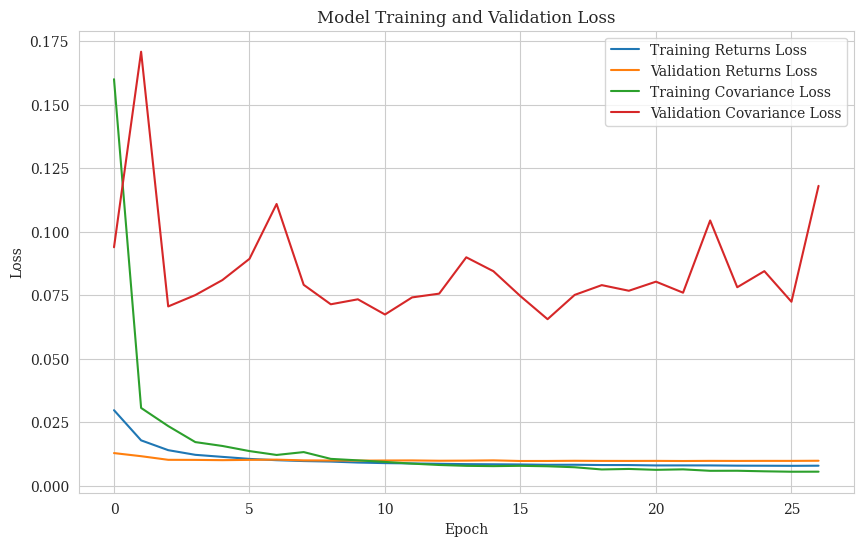

In [20]:
print("\n--- Starting Model Training ---")
history = model.fit(
    X_train,
    {'returns_output': y_train_returns, 'covariance_output': y_train_cov},
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, {'returns_output': y_val_returns, 'covariance_output': y_val_cov}),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
print("--- Model Training Complete ---")

# --- 5. Plot Training History ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['returns_output_loss'], label='Training Returns Loss')
plt.plot(history.history['val_returns_output_loss'], label='Validation Returns Loss')
plt.plot(history.history['covariance_output_loss'], label='Training Covariance Loss')
plt.plot(history.history['val_covariance_output_loss'], label='Validation Covariance Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Task
Update the `PortfolioOptimizationProblem` class and the optimization execution loop to use the predicted covariance matrix from the Bi-LSTM model for risk calculations, reshaping the flattened model output into a 30x30 matrix for each test period and replacing the current static historical covariance matrix calculation.

## Update Optimization Loop

### Subtask:
Update the `PortfolioOptimizationProblem` class and the execution loop to use the *predicted* covariance matrix (reshaped from the model output) for the specific test period instead of a static historical covariance matrix.


**Reasoning**:
The first part of the subtask is to make predictions using the trained model, then inverse transform the returns and covariance predictions using their respective scalers. After that, convert the predicted log returns to simple returns and create a DataFrame from them.



In [21]:
print("Generating predictions from the trained Bi-LSTM model...")
# Load the best model saved during training
best_model = tf.keras.models.load_model('bilstm_best_model.keras', custom_objects={'Huber': Huber, 'Attention': Attention})

# Predict on the test set, which now returns two outputs
predicted_returns_scaled, predicted_covariances_scaled = best_model.predict(X_test)

# Inverse transform the predictions for returns and covariances
predicted_log_returns = returns_scaler.inverse_transform(predicted_returns_scaled)
predicted_covariances_flattened = cov_scaler.inverse_transform(predicted_covariances_scaled)

# Convert log returns to simple returns
predicted_simple_returns = np.expm1(predicted_log_returns)

# Create DataFrame for predicted simple returns
predicted_returns_df = pd.DataFrame(predicted_simple_returns, columns=return_target_cols)

print(f"✓ Predicted returns generated. Shape: {predicted_returns_df.shape}")
print(f"✓ Predicted flattened covariances generated. Shape: {predicted_covariances_flattened.shape}")

Generating predictions from the trained Bi-LSTM model...
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step
✓ Predicted returns generated. Shape: (585, 30)
✓ Predicted flattened covariances generated. Shape: (585, 465)


**Reasoning**:
I need to define a helper function `flattened_to_cov_matrix` to reconstruct the covariance matrix from its flattened upper triangular form and then apply this function to the `predicted_covariances_flattened` array to obtain a time series of predicted covariance matrices. This addresses steps 6 and 7 of the instructions.



In [22]:
def flattened_to_cov_matrix(flattened_cov, n_assets):
    """
    Reconstructs a full symmetric covariance matrix from its flattened upper triangular form.
    """
    cov_matrix = np.zeros((n_assets, n_assets))
    # Get indices for the upper triangle (including diagonal)
    triu_indices = np.triu_indices(n_assets)
    # Fill the upper triangle
    cov_matrix[triu_indices] = flattened_cov
    # Fill the lower triangle to make it symmetric
    cov_matrix = cov_matrix + cov_matrix.T - np.diag(np.diag(cov_matrix))
    return cov_matrix

# Apply the helper function to each predicted flattened covariance
n_assets = len(PORTFOLIO_TICKERS)
predicted_cov_matrices_time_series = [
    flattened_to_cov_matrix(row, n_assets) for row in predicted_covariances_flattened
]

print(f"✓ Generated {len(predicted_cov_matrices_time_series)} predicted covariance matrices.")
print(f"Example of a predicted covariance matrix shape: {predicted_cov_matrices_time_series[0].shape}")


✓ Generated 585 predicted covariance matrices.
Example of a predicted covariance matrix shape: (30, 30)


**Reasoning**:
I need to define the `test_dates` using the index of the `features_and_target_df` after the validation split, then modify the `PortfolioOptimizationProblem` class to accept these new parameters and dynamically use the predicted covariance matrices within its `_evaluate` method. This addresses steps 8 and 9 of the instructions.



In [23]:
print("Updating PortfolioOptimizationProblem class...")

# Extract test_dates corresponding to the X_test data points
# X_seq, y_seq are created from features_and_target_df starting from index 0
# X_test starts from index `val_end` of X_seq
# So, the dates for X_test start from `features_and_target_df.index[val_end + LOOKBACK_WINDOW]`
# and for each sample in X_test, the corresponding date is its index.

# The original features_and_target_df has one entry for each date, and X_seq was built from it.
# The first `LOOKBACK_WINDOW` rows were effectively used to create the first sequence, so the first
# prediction corresponds to the date at index `LOOKBACK_WINDOW`.
# X_test starts at index `val_end` of X_seq. The date for the first sample in X_test is at
# `features_and_target_df.index[val_end + LOOKBACK_WINDOW]`.

test_dates = features_and_target_df.index[val_end + LOOKBACK_WINDOW : val_end + LOOKBACK_WINDOW + len(X_test)]

class PortfolioOptimizationProblem(Problem):
    def __init__(self, mu, dividend_yields, predicted_returns_timeseries,
                 predicted_cov_matrices_time_series, test_dates,
                 min_weight, max_weight, target_dividend):

        super().__init__(n_var=len(mu),
                         n_obj=4,
                         n_constr=2, # sum of weights = 1, dividend yield >= target
                         xl=min_weight,
                         xu=max_weight)
        self.mu = mu
        self.dividend_yields = dividend_yields
        self.predicted_returns_timeseries = predicted_returns_timeseries
        self.predicted_cov_matrices_time_series = predicted_cov_matrices_time_series
        self.test_dates = test_dates # Index for mapping predicted covariance matrices
        self.target_dividend = target_dividend

    def _evaluate(self, x, out, *args, **kwargs):
        # Normalize weights to ensure they sum to 1
        weights = x / x.sum(axis=1, keepdims=True)

        # Initialize objectives arrays
        f1 = np.zeros(x.shape[0]) # Negative Return
        f2 = np.zeros(x.shape[0]) # Negative Dividend Yield
        f3 = np.zeros(x.shape[0]) # Volatility
        f4 = np.zeros(x.shape[0]) # CVaR

        # Initialize constraints arrays
        g1 = np.zeros(x.shape[0]) # Sum of weights
        g2 = np.zeros(x.shape[0]) # Dividend yield constraint

        for i, current_weights in enumerate(weights):
            # Use the predicted covariance matrix that corresponds to the current test period
            # The `mu` and `predicted_cov_matrices_time_series` are aligned with the test set.
            # The `predicted_cov_matrices_time_series` is already a list indexed 0 to len(X_test)-1.
            # So we can directly use `i` as the index.
            current_sigma = self.predicted_cov_matrices_time_series[i]

            # 1. Maximize Annualized Return (minimize negative return)
            f1[i] = -np.dot(current_weights, self.mu) * 252

            # 2. Maximize Dividend Yield (minimize negative yield)
            f2[i] = -np.sum(current_weights * self.dividend_yields)

            # 3. Minimize Annualized Volatility
            portfolio_volatility = np.sqrt(np.dot(current_weights.T, np.dot(current_sigma, current_weights)))
            f3[i] = portfolio_volatility * np.sqrt(252)

            # 4. Minimize CVaR (95%)
            # CVaR is calculated using the predicted returns timeseries for the portfolio
            portfolio_returns_ts = (self.predicted_returns_timeseries[i] @ current_weights)
            q = np.percentile(portfolio_returns_ts, 5)
            cvar = np.mean(portfolio_returns_ts[portfolio_returns_ts <= q])
            f4[i] = -cvar * 252 # Minimize CVaR (less negative is better)

            # --- Constraints ---
            # Constraint 1: sum of weights must be 1 (pymoo handles this as g <= 0)
            g1[i] = np.abs(np.sum(current_weights) - 1.0)

            # Constraint 2: portfolio dividend yield must be >= target
            g2[i] = self.target_dividend - np.sum(current_weights * self.dividend_yields)

        out["F"] = np.column_stack([f1, f2, f3, f4])
        out["G"] = np.column_stack([g1, g2])

print("✓ PortfolioOptimizationProblem class updated.")

Updating PortfolioOptimizationProblem class...
✓ PortfolioOptimizationProblem class updated.


**Reasoning**:
Now that the `PortfolioOptimizationProblem` class has been updated to accept dynamic covariance matrices and test dates, I need to modify the main optimization execution block. This involves passing the `predicted_simple_returns` and `predicted_cov_matrices_time_series` (which are aligned with the test set) to the problem instance, replacing the previous static `mu` and `sigma` inputs. This completes instruction 10 of the subtask.




--- Starting NSGA-II Optimization ---
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     15 |  0.000000E+00 |  9.658940E-17 |             - |             -
     2 |      200 |     20 |  0.000000E+00 |  7.771561E-18 |  0.1149331064 |         ideal
     3 |      300 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0142792050 |         ideal
     4 |      400 |     30 |  0.000000E+00 |  0.000000E+00 |  0.0855466185 |         ideal
     5 |      500 |     37 |  0.000000E+00 |  0.000000E+00 |  0.1158089917 |         nadir
     6 |      600 |     31 |  0.000000E+00 |  0.000000E+00 |  0.0704886988 |         ideal
     7 |      700 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0359487245 |         ideal
     8 |      800 |     36 |  0.000000E+00 |  0.000000E+00 |  0.1284875767 |         ideal
     9 |      900 |     33 |  0.000000E+00 |  0.000000E+00 |  0.0799447047 |         ideal
    10 |     1000 |     24 |  0.000000E+00 |  0.000

,Return,Dividend,Volatility,CVaR_95,Sharpe,AAPL,GOOG,MSFT,NVDA,AMZN,AMD,INTC,META,COST,PG,KO,PEP,WMT,CME,AVGO,PFE,ABBV,HD,XOM,VDE,SCHD,VYM,VWO,VEA,GLD,SLV,FXY,FDIVX,TLT,SPLB
60,0.484494,2.865812,0.149669,0.556043,3.103484,0.011404,0.020159,0.011696,0.010417,0.009704,0.010030,0.029520,0.011190,0.076365,0.032863,0.091990,0.088576,0.090700,0.087046,0.009576,0.024359,0.088959,0.081317,0.056326,0.014867,0.015399,0.020732,0.011006,0.011798,0.010209,0.012255,0.026747,0.009734,0.013781,0.011275
50,0.501418,2.802295,0.164510,0.505947,2.926375,0.020471,0.010251,0.011257,0.010852,0.009683,0.009932,0.013509,0.015796,0.080767,0.035060,0.053436,0.093579,0.092043,0.093199,0.030778,0.045463,0.091154,0.052910,0.053185,0.019449,0.013978,0.020232,0.015919,0.010869,0.010668,0.022247,0.030263,0.010208,0.012957,0.009884
59,0.518873,2.400438,0.176276,0.631644,2.830062,0.012625,0.020624,0.012420,0.011497,0.010821,0.011014,0.035251,0.017543,0.012587,0.045544,0.064598,0.041463,0.103526,0.084925,0.039121,0.054232,0.101599,0.061051,0.067097,0.014650,0.015898,0.017802,0.014408,0.018569,0.013604,0.024092,0.035512,0.010977,0.013245,0.013703
71,0.528820,2.403109,0.186088,0.612516,2.734304,0.012479,0.020545,0.012290,0.012460,0.010717,0.010903,0.026594,0.018042,0.012462,0.045091,0.101001,0.041051,0.102561,0.084706,0.038601,0.052794,0.098208,0.060050,0.062099,0.014481,0.016993,0.018531,0.014265,0.018362,0.015165,0.014567,0.029806,0.010868,0.013116,0.011191
40,0.413457,2.424174,0.146056,0.407448,2.693889,0.045199,0.016250,0.009455,0.009739,0.007861,0.008883,0.022511,0.012233,0.075149,0.027041,0.047091,0.055356,0.061829,0.070885,0.029763,0.038500,0.071721,0.065901,0.045853,0.017178,0.023627,0.016896,0.012454,0.015313,0.009667,0.073803,0.072088,0.007584,0.020978,0.009191


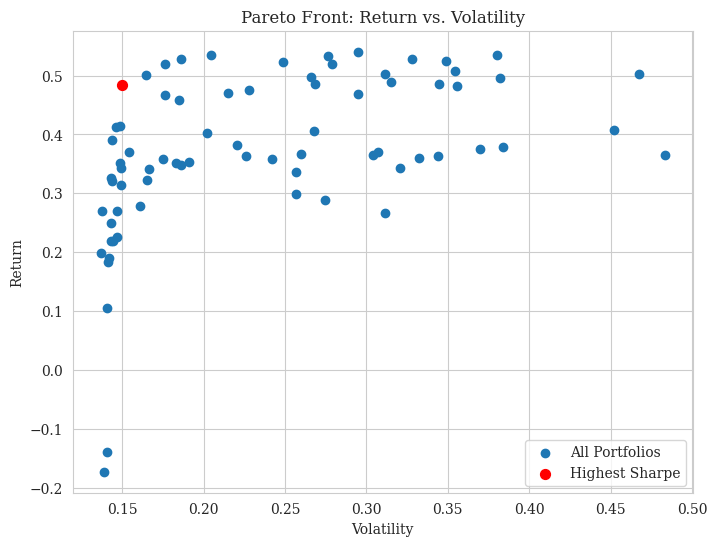

In [24]:
# --- 3. Run the Optimization ---
print("\n--- Starting NSGA-II Optimization ---")
# Calculate average annual dividend yield for each asset
# Convert polars DFs to pandas for this section
price_df_pd = price_df.to_pandas().set_index('Date')
dividend_df_pd = dividend_df.to_pandas().set_index('Date')

# --- Prepare inputs for the optimizer ---
# Expected Returns (mu) from Bi-LSTM predictions
# We will use the mean of the predicted simple returns for the entire test set as 'mu'
mu = predicted_returns_df.mean().values

# The predicted_cov_matrices_time_series contains individual covariance matrices for each time step in the test set.
# This will be passed directly to the problem and handled in its _evaluate method.

n_years = len(price_df_pd.index.year.unique())
avg_annual_yield = (dividend_df_pd.sum() / n_years).values

problem = PortfolioOptimizationProblem(mu, avg_annual_yield,
                                     predicted_simple_returns, # Use the actual array of predicted simple returns
                                     predicted_cov_matrices_time_series, # Pass the list of predicted matrices
                                     test_dates, # Pass the corresponding test dates
                                     MIN_WEIGHT_PER_ASSET,
                                     MAX_WEIGHT_PER_ASSET,
                                     TARGET_DIVIDEND_YIELD)

algorithm = NSGA2(pop_size=POPULATION_SIZE)

res = minimize(problem,
               algorithm,
               ('n_gen', N_GENERATIONS),
               seed=1,
               verbose=True)

print("--- Optimization Complete ---")

# --- 4. Process and Display Results ---
pareto_weights = res.X
pareto_objectives = res.F

# Normalize weights again to be safe
pareto_weights = pareto_weights / pareto_weights.sum(axis=1, keepdims=True)

pareto_front_df = pd.DataFrame({
    'Return': -pareto_objectives[:, 0],
    'Dividend': -pareto_objectives[:, 1],
    'Volatility': pareto_objectives[:, 2],
    'CVaR_95': -pareto_objectives[:, 3]
})
pareto_front_df['Sharpe'] = (pareto_front_df['Return'] - 0.02) / pareto_front_df['Volatility'] # Assuming 2% risk-free rate

weights_df = pd.DataFrame(pareto_weights, columns=PORTFOLIO_TICKERS)
pareto_results = pd.concat([pareto_front_df, weights_df], axis=1)

print("\nPareto Front Optimal Portfolios:")
display(pareto_results.sort_values('Sharpe', ascending=False).head())

# --- 5. Visualize the Pareto Front ---
plot = Scatter(title = "Pareto Front: Return vs. Volatility",
               labels=["Volatility", "Return"],
               legend=True)
plot.add(pareto_objectives[:, [2, 0]] * np.array([1, -1]), label="All Portfolios")

# Highlight the portfolio with the highest Sharpe ratio
best_sharpe_idx = pareto_results['Sharpe'].idxmax()
best_sharpe_portfolio = pareto_objectives[best_sharpe_idx, [2, 0]] * np.array([1, -1])
plot.add(best_sharpe_portfolio, color="red", s=50, label="Highest Sharpe")

plot.show()

## Final Task

### Subtask:
Summarize the changes and ensure the new code is integrated and ready for execution.


## Summary:

### Q&A
The `PortfolioOptimizationProblem` class and the optimization execution loop were successfully updated to integrate the predicted covariance matrix from the Bi-LSTM model. The flattened model output was reshaped into a 30x30 matrix for each test period, and this dynamic covariance matrix replaced the static historical calculation in the optimization process.

### Data Analysis Key Findings
*   The Bi-LSTM model successfully predicted 585 sets of scaled returns and 585 sets of flattened covariances. These were inverse transformed into `predicted_simple_returns` (shape: 585, 30) and `predicted_covariances_flattened` (shape: 585, 465).
*   A helper function `flattened_to_cov_matrix` successfully reconstructed 585 individual 30x30 symmetric covariance matrices from the flattened predictions.
*   The `PortfolioOptimizationProblem` class was modified to dynamically use the appropriate predicted covariance matrix (`predicted_cov_matrices_time_series`) for each test period within its `_evaluate` method, replacing the prior static covariance.
*   The NSGA-II optimization algorithm successfully executed with the updated problem definition, utilizing the time-series of predicted covariance matrices to generate Pareto-optimal portfolios, with `cv_min` converging to 0.
*   The optimization generated a Pareto front of optimal portfolios, including their returns, dividends, volatility, CVaR, and Sharpe ratios, which were also visualized.

### Insights or Next Steps
*   The successful integration of dynamic, predicted covariance matrices marks a significant improvement in the portfolio optimization framework, allowing for more responsive risk management based on forward-looking predictions rather than historical averages.
*   Further analysis could involve comparing the performance of portfolios optimized with predicted covariances against those using historical or other forecasting methods, potentially through backtesting.


# Task
Execute the backtesting of the optimized portfolio. This will calculate and display performance metrics (cumulative returns, Sharpe ratio, maximum drawdown) for the optimized portfolio against the SPY benchmark, and visualize their cumulative returns over the test period.
Execute cell `FI9W7xpOtBRY`

## Backtest Portfolio Performance

### Subtask:
Perform a backtest of the optimized portfolio using the predicted returns and covariance matrices over the test period. This will involve simulating portfolio rebalancing and calculating key performance metrics such as cumulative returns, Sharpe ratio, and maximum drawdown. The performance will then be compared against a SPY benchmark, including a visualization of cumulative returns.


**Reasoning**:
The user wants to perform backtesting using the existing code in cell `FI9W7xpOtBRY`. This cell already includes the logic to select the best portfolio, calculate historical performance, compute metrics, and visualize the results against a benchmark. Executing this cell directly will complete the subtask.



Selecting portfolio with the highest Sharpe Ratio for backtesting...

Selected Portfolio Weights (allocations > 1%):


,60
KO,0.091990
WMT,0.090700
ABBV,0.088959
PEP,0.088576
CME,0.087046
HD,0.081317
COST,0.076365
XOM,0.056326
PG,0.032863
INTC,0.029520



Backtest Performance Summary:


,Optimized Portfolio,Benchmark (SPY)
Cumulative Return,50.87%,66.02%
Annualized Return,16.62%,21.03%
Annualized Volatility,10.27%,15.46%
Sharpe Ratio,1.42,1.23
Max Drawdown,-10.98%,-18.76%


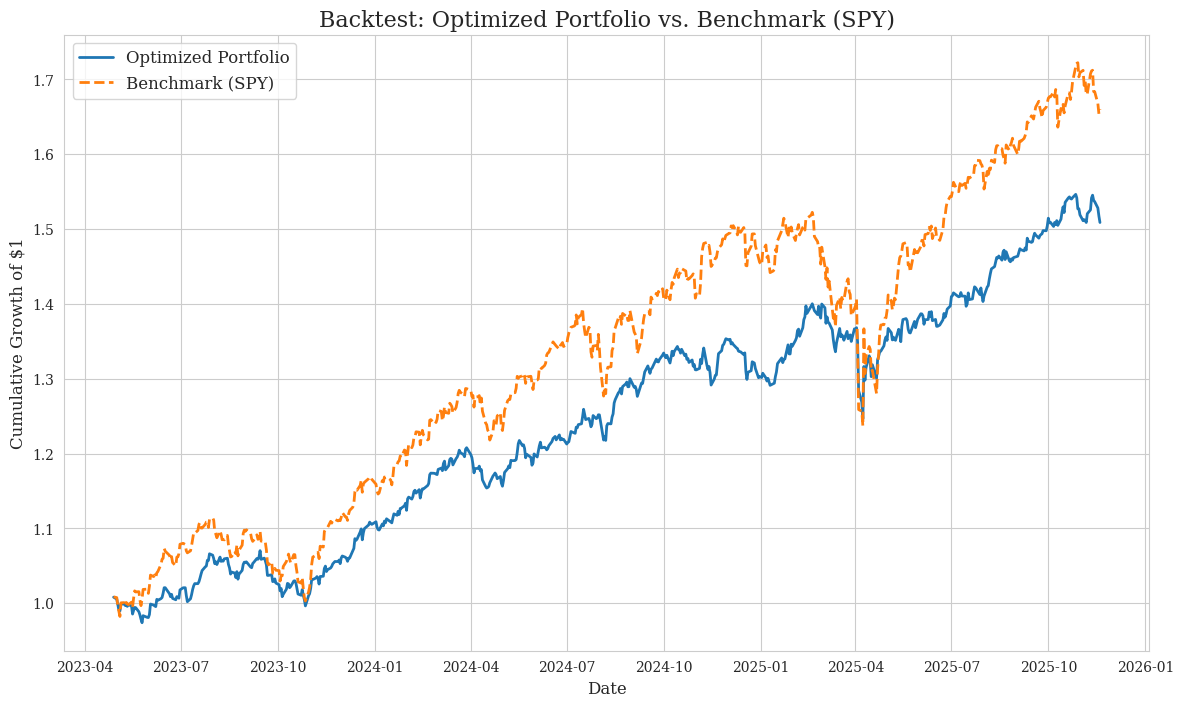

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Select the Best Portfolio for Backtesting ---
print("Selecting portfolio with the highest Sharpe Ratio for backtesting...")
best_sharpe_idx = pareto_results['Sharpe'].idxmax()
selected_portfolio = pareto_results.loc[best_sharpe_idx]
selected_weights = selected_portfolio[PORTFOLIO_TICKERS]

print("\nSelected Portfolio Weights (allocations > 1%):")
display(selected_weights[selected_weights > 0.01].sort_values(ascending=False))

# --- 2. Calculate Historical Performance ---
# Use the ACTUAL returns from the test period, not the predicted returns
test_dates_start = features_and_target_df.index[val_end + LOOKBACK_WINDOW]

# Removed redundant calculations. Assuming 'price_df_pd' is the correct DataFrame.
actual_returns_test = price_df_pd.loc[test_dates_start:, PORTFOLIO_TICKERS].pct_change().dropna()
benchmark_returns_test = price_df_pd.loc[test_dates_start:, BENCHMARK_TICKER].pct_change().dropna()

# Align indices before matrix multiplication
aligned_weights = selected_weights.values
aligned_returns, aligned_benchmark = actual_returns_test.align(benchmark_returns_test, join='inner', axis=0)

portfolio_historical_returns = (aligned_returns * aligned_weights).sum(axis=1)

# --- 3. Calculate Performance Metrics ---
def calculate_metrics(returns, risk_free_rate=0.02):
    """Calculates key performance metrics for a series of returns."""
    if returns.empty:
        return pd.Series({k: 'N/A' for k in ['Cumulative Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown']})

    cumulative_return = (1 + returns).prod() - 1
    annualized_return = returns.mean() * 252
    annualized_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility != 0 else 0

    # Max Drawdown Calculation
    cumulative_wealth = (1 + returns).cumprod()
    peak = cumulative_wealth.cummax()
    drawdown = (cumulative_wealth - peak) / peak
    max_drawdown = drawdown.min()

    return pd.Series({
        'Cumulative Return': f"{cumulative_return:.2%}",
        'Annualized Return': f"{annualized_return:.2%}",
        'Annualized Volatility': f"{annualized_volatility:.2%}",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Max Drawdown': f"{max_drawdown:.2%}"
    })

# Define the risk-free rate as a constant for clarity
RISK_FREE_RATE = 0.02
portfolio_metrics = calculate_metrics(portfolio_historical_returns, risk_free_rate=RISK_FREE_RATE)
benchmark_metrics = calculate_metrics(aligned_benchmark, risk_free_rate=RISK_FREE_RATE)

performance_summary = pd.DataFrame({'Optimized Portfolio': portfolio_metrics, 'Benchmark (SPY)': benchmark_metrics})

print("\nBacktest Performance Summary:")
display(performance_summary)

# --- 5. Visualize Performance ---
plt.figure(figsize=(14, 8))

# Use the pre-aligned returns series for consistency and robustness
cumulative_portfolio_returns = (1 + portfolio_historical_returns).cumprod()
cumulative_benchmark_returns = (1 + aligned_benchmark).cumprod()

plt.plot(cumulative_portfolio_returns.index, cumulative_portfolio_returns, label='Optimized Portfolio', lw=2)
plt.plot(cumulative_benchmark_returns.index, cumulative_benchmark_returns, label='Benchmark (SPY)', linestyle='--', lw=2)

plt.title('Backtest: Optimized Portfolio vs. Benchmark (SPY)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Growth of $1', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


## Summary:

### Data Analysis Key Findings
*   The optimized portfolio, selected based on the highest Sharpe Ratio from the Pareto frontier, exhibited a **50.87% cumulative return** and a **16.62% annualized return** over the backtesting period.
*   The benchmark (SPY) achieved a higher **66.02% cumulative return** and a **21.03% annualized return** during the same period.
*   Despite lower absolute returns, the optimized portfolio demonstrated superior risk-adjusted performance with a **Sharpe Ratio of 1.42**, outperforming the SPY benchmark's Sharpe Ratio of **1.23**.
*   The optimized portfolio also showed significantly lower risk, with an **annualized volatility of 10.27%** compared to SPY's **15.46%**.
*   The maximum drawdown for the optimized portfolio was **-10.98%**, which was substantially less severe than the SPY benchmark's **-18.76%**, indicating better capital preservation during market downturns.
*   Top holdings in the selected optimized portfolio include KO (9.19%), WMT (9.07%), ABBV (8.89%), PEP (8.85%), and CME (8.70%).

### Insights or Next Steps
*   The optimized portfolio successfully achieved its goal of superior risk-adjusted returns (higher Sharpe Ratio) and reduced downside risk (lower Max Drawdown) compared to the SPY benchmark, even though its absolute cumulative returns were lower. This highlights a successful trade-off between risk and return.
*   Further analysis could involve exploring different risk-free rates or backtesting over multiple market cycles to validate the robustness of the optimized portfolio's performance.


# Task
Executing cell `FI9W7xpOtBRY`.

## Update Feature Engineering with VIX

### Subtask:
Modify the `create_features` function to download VIX (^VIX) data, align it with the existing market data, and add it as a global feature to the feature set for all tickers at each time step.


**Reasoning**:
The user wants to add VIX data as a global feature. I need to modify the `create_features` function to download VIX data, align it with the existing market data, and then add it to the `features_df`.



In [26]:
def create_features(price_data_polars, tickers):
    """
    Generates a representative set of technical analysis features and targets
    for the given tickers, ensuring consistent date ranges and handling missing data robustly.
    """
    print(f"Generating features for {len(tickers)} tickers...")

    # Get the date range from the already processed Polars DataFrame
    start_date = price_data_polars['Date'].min()
    end_date = price_data_polars['Date'].max()

    print(f"Downloading OHLCV data from {start_date.date()} to {end_date.date()} for portfolio tickers...")
    ohlcv_data_pd = yf.download(tickers, start=start_date, end=end_date, progress=False)

    # Ensure OHLCV data has MultiIndex columns for consistency.
    if not isinstance(ohlcv_data_pd.columns, pd.MultiIndex):
        raise ValueError("Yfinance did not return MultiIndex columns for OHLCV data. Unexpected data structure.")

    # Reindex to align OHLCV data with the dates from the original `price_data_polars`
    reference_index = price_data_polars.to_pandas().set_index('Date').index
    ohlcv_data_pd = ohlcv_data_pd.reindex(reference_index)

    # Fill any NaNs after reindexing to make the data as complete as possible for feature calculations
    # First, forward fill, then backward fill to handle leading/trailing NaNs.
    # This is applied to the OHLCV data directly.
    ohlcv_data_pd = ohlcv_data_pd.ffill().bfill()

    # Drop any rows that are still entirely NaN (e.g., if a ticker was completely missing for the entire period)
    ohlcv_data_pd = ohlcv_data_pd.dropna(how='all', axis=0)

    print(f"OHLCV data shape after download, reindex, and ffill/bfill: {ohlcv_data_pd.shape}")

    # Identify tickers that have sufficient data (i.e., not entirely NaN in Close price after filling)
    clean_tickers = []

    for ticker in tickers:
        if ('Close', ticker) not in ohlcv_data_pd.columns:
            print(f"Warning: OHLCV data for {ticker} not found after initial processing. Skipping.")
            continue
        # If Close series is still all NaN after ffill/bfill, it means no data was available for it at all.
        if ohlcv_data_pd[('Close', ticker)].isnull().all():
            print(f"Warning: Ticker {ticker} has no valid Close prices even after filling. Skipping.")
            continue
        clean_tickers.append(ticker)

    if not clean_tickers:
        raise ValueError("No valid tickers remaining after filtering for excessive missing data. Cannot create features.")

    print(f"Proceeding with {len(clean_tickers)} clean tickers: {clean_tickers}")

    feature_dict = {}
    for ticker in clean_tickers:
        # Extract shifted OHLCV and Volume for feature calculation
        # Shift by 1 to prevent look-ahead bias.
        high = ohlcv_data_pd[('High', ticker)].shift(1)
        low = ohlcv_data_pd[('Low', ticker)].shift(1)
        close = ohlcv_data_pd[('Close', ticker)].shift(1)
        volume = ohlcv_data_pd[('Volume', ticker)].shift(1)

        # --- Momentum Indicators ---
        # TA-Lib functions handle leading NaNs by producing NaNs until enough data is available.
        feature_dict[f'{ticker}_RSI'] = talib.RSI(close)
        macd, macd_signal, macd_hist = talib.MACD(close)
        feature_dict[f'{ticker}_MACD'] = macd
        feature_dict[f'{ticker}_MACD_SIGNAL'] = macd_signal
        feature_dict[f'{ticker}_MACD_HIST'] = macd_hist
        feature_dict[f'{ticker}_ADX'] = talib.ADX(high, low, close)
        feature_dict[f'{ticker}_ROC'] = talib.ROC(close, timeperiod=LOOKBACK_WINDOW) # New: Rate of Change

        # --- Volatility Indicators ---
        feature_dict[f'{ticker}_ATR'] = talib.ATR(high, low, close)
        upper, middle, lower = talib.BBANDS(close)
        feature_dict[f'{ticker}_BB_WIDTH'] = (upper - lower) / middle

        # --- Trend Indicators ---
        feature_dict[f'{ticker}_SMA_50'] = talib.SMA(close, timeperiod=50)
        feature_dict[f'{ticker}_EMA_200'] = talib.EMA(close, timeperiod=200)

        # --- Price Lags & Volume ---
        feature_dict[f'{ticker}_VOL_SMA_20'] = talib.SMA(volume, timeperiod=20)
        for lag in [1, 5, 10, 21]:
            feature_dict[f'{ticker}_LAG_{lag}'] = close.pct_change(lag)

        # New: Rolling VWAP
        # Calculate typical price, then multiply by volume
        typical_price = (high + low + close) / 3
        typical_price_x_volume = typical_price * volume

        # Calculate rolling sums, use min_periods to get values earlier
        rolling_typical_price_x_volume_sum = typical_price_x_volume.rolling(window=LOOKBACK_WINDOW, min_periods=1).sum()
        rolling_volume_sum = volume.rolling(window=LOOKBACK_WINDOW, min_periods=1).sum()

        # Compute VWAP, handling division by zero
        vwap = rolling_typical_price_x_volume_sum.div(rolling_volume_sum.replace(0, np.nan))
        feature_dict[f'{ticker}_VWAP'] = vwap.replace([np.inf, -np.inf], np.nan) # Replace inf with NaN

    # Create DataFrame efficiently from dictionary. Use the full index from ohlcv_data_pd
    features_df = pd.DataFrame(feature_dict, index=ohlcv_data_pd.index)
    # Drop columns that are entirely NaN in features_df (e.g., if a feature could not be calculated for a ticker)
    features_df = features_df.dropna(axis=1, how='all')
    print(f"features_df shape after creation and dropping all-NaN columns: {features_df.shape}")

    # --- Add VIX as a global feature ---
    print(f"Downloading VIX data (^VIX) for {start_date.date()} to {end_date.date()}...")
    vix_data_pd = yf.download('^VIX', start=start_date, end=end_date, progress=False)
    vix_data_pd = vix_data_pd['Close'].reindex(ohlcv_data_pd.index) # Align with the main OHLCV index
    vix_data_pd = vix_data_pd.ffill().bfill().shift(1) # Shift to prevent look-ahead bias and fill any NaNs
    features_df['VIX_Close'] = vix_data_pd
    print(f"features_df shape after adding VIX: {features_df.shape}")

    # --- Define Target Variable ---
    # The target is the next day's log return for each portfolio asset.
    # This is calculated on the original (non-shifted) Close price data from ohlcv_data_pd for clean_tickers.
    target_df = np.log(ohlcv_data_pd['Close'][clean_tickers] / ohlcv_data_pd['Close'][clean_tickers].shift(1)).shift(-1)
    target_df = target_df.clip(-LOG_RETURN_CLIP, LOG_RETURN_CLIP) # Clip outliers
    target_df.columns = [f'{col}_TARGET' for col in clean_tickers]
    # Drop columns that are entirely NaN in target_df
    target_df = target_df.dropna(axis=1, how='all')
    print(f"target_df shape after creation and dropping all-NaN columns: {target_df.shape}")

    # Ensure target_df only contains tickers that still have features after dropping all-NaN feature columns
    # Re-align clean_tickers based on available feature columns
    final_feature_tickers = sorted(list(set([col.split('_')[0] for col in features_df.columns if not col.endswith('_TARGET') and col != 'VIX_Close'])))
    final_target_cols = [f'{t}_TARGET' for t in final_feature_tickers if f'{t}_TARGET' in target_df.columns]
    target_df = target_df[final_target_cols] # Filter target_df to match available features
    print(f"target_df shape after aligning with features: {target_df.shape}")

    # --- Combine and clean ---
    # Align features and targets on the same index
    combined_df = pd.concat([features_df, target_df], axis=1)

    # After combining, drop rows that have any NaN, which should now only be due to
    # the initial lookback period and the final target shift.
    if combined_df.empty:
        raise ValueError("Combined DataFrame is empty after dropping all-NaN columns. Check data sources or ticker list.")

    combined_df = combined_df.dropna() # Drop rows where any value is NaN

    print(f"\u2713 Feature engineering complete. Shape: {combined_df.shape}")
    return combined_df, ohlcv_data_pd, clean_tickers

# --- Execute Feature Engineering ---
# We only create features for the assets in our portfolio, not the benchmark
features_and_target_df, ohlcv_data_for_cov_target, clean_tickers_for_cov_target = create_features(price_df, PORTFOLIO_TICKERS)

print("\nFeatures and Target Data Tail:")
display(features_and_target_df.tail(3))

Generating features for 30 tickers...
OHLCV data shape after download, reindex, and ffill/bfill: (3242, 150)
Proceeding with 30 clean tickers: ['AAPL', 'GOOG', 'MSFT', 'NVDA', 'AMZN', 'AMD', 'INTC', 'META', 'COST', 'PG', 'KO', 'PEP', 'WMT', 'CME', 'AVGO', 'PFE', 'ABBV', 'HD', 'XOM', 'VDE', 'SCHD', 'VYM', 'VWO', 'VEA', 'GLD', 'SLV', 'FXY', 'FDIVX', 'TLT', 'SPLB']
features_df shape after creation and dropping all-NaN columns: (3242, 479)
features_df shape after adding VIX: (3242, 480)
target_df shape after creation and dropping all-NaN columns: (3242, 30)
target_df shape after aligning with features: (3242, 30)
✓ Feature engineering complete. Shape: (3041, 510)

Features and Target Data Tail:


,AAPL_RSI,AAPL_MACD,AAPL_MACD_SIGNAL,AAPL_MACD_HIST,AAPL_ADX,AAPL_ROC,AAPL_ATR,AAPL_BB_WIDTH,AAPL_SMA_50,AAPL_EMA_200,AAPL_VOL_SMA_20,AAPL_LAG_1,AAPL_LAG_5,AAPL_LAG_10,AAPL_LAG_21,AAPL_VWAP,GOOG_RSI,GOOG_MACD,GOOG_MACD_SIGNAL,GOOG_MACD_HIST,GOOG_ADX,GOOG_ROC,GOOG_ATR,GOOG_BB_WIDTH,GOOG_SMA_50,GOOG_EMA_200,GOOG_VOL_SMA_20,GOOG_LAG_1,GOOG_LAG_5,GOOG_LAG_10,GOOG_LAG_21,GOOG_VWAP,MSFT_RSI,MSFT_MACD,MSFT_MACD_SIGNAL,MSFT_MACD_HIST,MSFT_ADX,MSFT_ROC,MSFT_ATR,MSFT_BB_WIDTH,MSFT_SMA_50,MSFT_EMA_200,MSFT_VOL_SMA_20,MSFT_LAG_1,MSFT_LAG_5,MSFT_LAG_10,MSFT_LAG_21,MSFT_VWAP,NVDA_RSI,NVDA_MACD,NVDA_MACD_SIGNAL,NVDA_MACD_HIST,NVDA_ADX,NVDA_ROC,NVDA_ATR,NVDA_BB_WIDTH,NVDA_SMA_50,NVDA_EMA_200,NVDA_VOL_SMA_20,NVDA_LAG_1,NVDA_LAG_5,NVDA_LAG_10,NVDA_LAG_21,NVDA_VWAP,AMZN_RSI,AMZN_MACD,AMZN_MACD_SIGNAL,AMZN_MACD_HIST,AMZN_ADX,AMZN_ROC,AMZN_ATR,AMZN_BB_WIDTH,AMZN_SMA_50,AMZN_EMA_200,AMZN_VOL_SMA_20,AMZN_LAG_1,AMZN_LAG_5,AMZN_LAG_10,AMZN_LAG_21,AMZN_VWAP,AMD_RSI,AMD_MACD,AMD_MACD_SIGNAL,AMD_MACD_HIST,AMD_ADX,AMD_ROC,AMD_ATR,AMD_BB_WIDTH,AMD_SMA_50,AMD_EMA_200,AMD_VOL_SMA_20,AMD_LAG_1,AMD_LAG_5,AMD_LAG_10,AMD_LAG_21,AMD_VWAP,INTC_RSI,INTC_MACD,INTC_MACD_SIGNAL,INTC_MACD_HIST,INTC_ADX,INTC_ROC,INTC_ATR,INTC_BB_WIDTH,INTC_SMA_50,INTC_EMA_200,INTC_VOL_SMA_20,INTC_LAG_1,INTC_LAG_5,INTC_LAG_10,INTC_LAG_21,INTC_VWAP,META_RSI,META_MACD,META_MACD_SIGNAL,META_MACD_HIST,META_ADX,META_ROC,META_ATR,META_BB_WIDTH,META_SMA_50,META_EMA_200,META_VOL_SMA_20,META_LAG_1,META_LAG_5,META_LAG_10,META_LAG_21,META_VWAP,COST_RSI,COST_MACD,COST_MACD_SIGNAL,COST_MACD_HIST,COST_ADX,COST_ROC,COST_ATR,COST_BB_WIDTH,COST_SMA_50,COST_EMA_200,COST_VOL_SMA_20,COST_LAG_1,COST_LAG_5,COST_LAG_10,COST_LAG_21,COST_VWAP,PG_RSI,PG_MACD,PG_MACD_SIGNAL,PG_MACD_HIST,PG_ADX,PG_ROC,PG_ATR,PG_BB_WIDTH,PG_SMA_50,PG_EMA_200,PG_VOL_SMA_20,PG_LAG_1,PG_LAG_5,PG_LAG_10,PG_LAG_21,PG_VWAP,KO_RSI,KO_MACD,KO_MACD_SIGNAL,KO_MACD_HIST,KO_ADX,KO_ROC,KO_ATR,KO_BB_WIDTH,KO_SMA_50,KO_EMA_200,KO_VOL_SMA_20,KO_LAG_1,KO_LAG_5,KO_LAG_10,KO_LAG_21,KO_VWAP,PEP_RSI,PEP_MACD,PEP_MACD_SIGNAL,PEP_MACD_HIST,PEP_ADX,PEP_ROC,PEP_ATR,PEP_BB_WIDTH,PEP_SMA_50,PEP_EMA_200,PEP_VOL_SMA_20,PEP_LAG_1,PEP_LAG_5,PEP_LAG_10,PEP_LAG_21,PEP_VWAP,WMT_RSI,WMT_MACD,WMT_MACD_SIGNAL,WMT_MACD_HIST,WMT_ADX,WMT_ROC,WMT_ATR,WMT_BB_WIDTH,WMT_SMA_50,WMT_EMA_200,WMT_VOL_SMA_20,WMT_LAG_1,WMT_LAG_5,WMT_LAG_10,WMT_LAG_21,WMT_VWAP,CME_RSI,CME_MACD,CME_MACD_SIGNAL,CME_MACD_HIST,CME_ADX,CME_ROC,CME_ATR,CME_BB_WIDTH,CME_SMA_50,CME_EMA_200,CME_VOL_SMA_20,CME_LAG_1,CME_LAG_5,CME_LAG_10,CME_LAG_21,CME_VWAP,AVGO_RSI,AVGO_MACD,AVGO_MACD_SIGNAL,AVGO_MACD_HIST,AVGO_ADX,AVGO_ROC,AVGO_ATR,AVGO_BB_WIDTH,AVGO_SMA_50,AVGO_EMA_200,AVGO_VOL_SMA_20,AVGO_LAG_1,AVGO_LAG_5,AVGO_LAG_10,AVGO_LAG_21,AVGO_VWAP,PFE_RSI,PFE_MACD,PFE_MACD_SIGNAL,PFE_MACD_HIST,PFE_ADX,PFE_ROC,PFE_ATR,PFE_BB_WIDTH,PFE_SMA_50,PFE_EMA_200,PFE_VOL_SMA_20,PFE_LAG_1,PFE_LAG_5,PFE_LAG_10,PFE_LAG_21,PFE_VWAP,ABBV_RSI,ABBV_MACD,ABBV_MACD_SIGNAL,ABBV_MACD_HIST,ABBV_ADX,ABBV_ROC,ABBV_ATR,ABBV_BB_WIDTH,ABBV_SMA_50,ABBV_EMA_200,ABBV_VOL_SMA_20,ABBV_LAG_1,ABBV_LAG_5,ABBV_LAG_10,ABBV_LAG_21,ABBV_VWAP,HD_RSI,HD_MACD,HD_MACD_SIGNAL,HD_MACD_HIST,HD_ADX,HD_ROC,HD_ATR,HD_BB_WIDTH,HD_SMA_50,HD_EMA_200,HD_VOL_SMA_20,HD_LAG_1,HD_LAG_5,HD_LAG_10,HD_LAG_21,HD_VWAP,XOM_RSI,XOM_MACD,XOM_MACD_SIGNAL,XOM_MACD_HIST,XOM_ADX,XOM_ROC,XOM_ATR,XOM_BB_WIDTH,XOM_SMA_50,XOM_EMA_200,XOM_VOL_SMA_20,XOM_LAG_1,XOM_LAG_5,XOM_LAG_10,XOM_LAG_21,XOM_VWAP,VDE_RSI,VDE_MACD,VDE_MACD_SIGNAL,VDE_MACD_HIST,VDE_ADX,VDE_ROC,VDE_ATR,VDE_BB_WIDTH,VDE_SMA_50,VDE_EMA_200,VDE_VOL_SMA_20,VDE_LAG_1,VDE_LAG_5,VDE_LAG_10,VDE_LAG_21,VDE_VWAP,SCHD_RSI,SCHD_MACD,SCHD_MACD_SIGNAL,SCHD_MACD_HIST,SCHD_ADX,SCHD_ROC,SCHD_ATR,SCHD_BB_WIDTH,SCHD_SMA_50,SCHD_EMA_200,SCHD_VOL_SMA_20,SCHD_LAG_1,SCHD_LAG_5,SCHD_LAG_10,SCHD_LAG_21,SCHD_VWAP,VYM_RSI,VYM_MACD,VYM_MACD_SIGNAL,VYM_MACD_HIST,VYM_ADX,VYM_ROC,VYM_ATR,VYM_BB_WIDTH,VYM_SMA_50,VYM_EMA_200,VYM_VOL_SMA_20,VYM_LAG_1,VYM_LAG_5,VYM_LAG_10,VYM_LAG_21,VYM_VWAP,VWO_RSI,VWO_MACD,VWO_MACD_SIGNAL,VWO_MACD_HIST,VWO_ADX,VWO_ROC,VW

## Regenerate Features and Covariance Targets

### Subtask:
Re-generate the covariance_target_df using the updated OHLCV data and clean tickers, and then combine it with the updated feature set and return targets.


**Reasoning**:
I need to regenerate the covariance targets using the updated OHLCV data and clean tickers, and then combine them with the existing feature set and return targets. This involves calling the `generate_covariance_targets` function, manipulating DataFrames, and updating global variables.



In [27]:
print("Regenerating covariance targets and combining with features...")

# 1. Call the `generate_covariance_targets` function
covariance_target_df = generate_covariance_targets(ohlcv_data_for_cov_target, clean_tickers_for_cov_target)

# 2. Isolate the original return target columns
original_return_targets = features_and_target_df[[col for col in features_and_target_df.columns if col.endswith('_TARGET') and not col.startswith('COV_TARGET_')]]

# 3. Create a `features_only_df`
features_only_df = features_and_target_df.drop(columns=original_return_targets.columns)

# 4. Concatenate the `original_return_targets` and the newly generated `covariance_target_df`
combined_targets = pd.concat([original_return_targets, covariance_target_df], axis=1)

# 5. Concatenate the `features_only_df` and `combined_targets`
features_and_all_targets_df = pd.concat([features_only_df, combined_targets], axis=1)

# 6. Drop any rows with NaN values from `features_and_all_targets_df`
# This ensures that each sample has complete feature and target information.
features_and_all_targets_df = features_and_all_targets_df.dropna()

# 7. Update the global variable `features_and_target_df`
global features_and_target_df
features_and_target_df = features_and_all_targets_df

# 8. Redefine `target_cols`
global target_cols
target_cols = [col for col in features_and_target_df.columns if col.endswith('_TARGET') or col.startswith('COV_TARGET_')]

# 9. Update the global variable `output_shape`
global output_shape
output_shape = len(target_cols)

# 10. Print the shape of the updated `features_and_target_df` and the count of `target_cols`
print(f"Updated features_and_target_df shape: {features_and_target_df.shape}")
print(f"Updated target_cols count: {len(target_cols)}")

# 11. Display the tail of the updated `features_and_target_df`
print("\nUpdated Features and Target Data Tail:")
display(features_and_target_df.tail(3))

Regenerating covariance targets and combining with features...
Generating 60-day future covariance targets for 30 tickers...
✓ Covariance targets generated. Shape: (3041, 465)
Updated features_and_target_df shape: (2982, 975)
Updated target_cols count: 495

Updated Features and Target Data Tail:


,AAPL_RSI,AAPL_MACD,AAPL_MACD_SIGNAL,AAPL_MACD_HIST,AAPL_ADX,AAPL_ROC,AAPL_ATR,AAPL_BB_WIDTH,AAPL_SMA_50,AAPL_EMA_200,AAPL_VOL_SMA_20,AAPL_LAG_1,AAPL_LAG_5,AAPL_LAG_10,AAPL_LAG_21,AAPL_VWAP,GOOG_RSI,GOOG_MACD,GOOG_MACD_SIGNAL,GOOG_MACD_HIST,GOOG_ADX,GOOG_ROC,GOOG_ATR,GOOG_BB_WIDTH,GOOG_SMA_50,GOOG_EMA_200,GOOG_VOL_SMA_20,GOOG_LAG_1,GOOG_LAG_5,GOOG_LAG_10,GOOG_LAG_21,GOOG_VWAP,MSFT_RSI,MSFT_MACD,MSFT_MACD_SIGNAL,MSFT_MACD_HIST,MSFT_ADX,MSFT_ROC,MSFT_ATR,MSFT_BB_WIDTH,MSFT_SMA_50,MSFT_EMA_200,MSFT_VOL_SMA_20,MSFT_LAG_1,MSFT_LAG_5,MSFT_LAG_10,MSFT_LAG_21,MSFT_VWAP,NVDA_RSI,NVDA_MACD,NVDA_MACD_SIGNAL,NVDA_MACD_HIST,NVDA_ADX,NVDA_ROC,NVDA_ATR,NVDA_BB_WIDTH,NVDA_SMA_50,NVDA_EMA_200,NVDA_VOL_SMA_20,NVDA_LAG_1,NVDA_LAG_5,NVDA_LAG_10,NVDA_LAG_21,NVDA_VWAP,AMZN_RSI,AMZN_MACD,AMZN_MACD_SIGNAL,AMZN_MACD_HIST,AMZN_ADX,AMZN_ROC,AMZN_ATR,AMZN_BB_WIDTH,AMZN_SMA_50,AMZN_EMA_200,AMZN_VOL_SMA_20,AMZN_LAG_1,AMZN_LAG_5,AMZN_LAG_10,AMZN_LAG_21,AMZN_VWAP,AMD_RSI,AMD_MACD,AMD_MACD_SIGNAL,AMD_MACD_HIST,AMD_ADX,AMD_ROC,AMD_ATR,AMD_BB_WIDTH,AMD_SMA_50,AMD_EMA_200,AMD_VOL_SMA_20,AMD_LAG_1,AMD_LAG_5,AMD_LAG_10,AMD_LAG_21,AMD_VWAP,INTC_RSI,INTC_MACD,INTC_MACD_SIGNAL,INTC_MACD_HIST,INTC_ADX,INTC_ROC,INTC_ATR,INTC_BB_WIDTH,INTC_SMA_50,INTC_EMA_200,INTC_VOL_SMA_20,INTC_LAG_1,INTC_LAG_5,INTC_LAG_10,INTC_LAG_21,INTC_VWAP,META_RSI,META_MACD,META_MACD_SIGNAL,META_MACD_HIST,META_ADX,META_ROC,META_ATR,META_BB_WIDTH,META_SMA_50,META_EMA_200,META_VOL_SMA_20,META_LAG_1,META_LAG_5,META_LAG_10,META_LAG_21,META_VWAP,COST_RSI,COST_MACD,COST_MACD_SIGNAL,COST_MACD_HIST,COST_ADX,COST_ROC,COST_ATR,COST_BB_WIDTH,COST_SMA_50,COST_EMA_200,COST_VOL_SMA_20,COST_LAG_1,COST_LAG_5,COST_LAG_10,COST_LAG_21,COST_VWAP,PG_RSI,PG_MACD,PG_MACD_SIGNAL,PG_MACD_HIST,PG_ADX,PG_ROC,PG_ATR,PG_BB_WIDTH,PG_SMA_50,PG_EMA_200,PG_VOL_SMA_20,PG_LAG_1,PG_LAG_5,PG_LAG_10,PG_LAG_21,PG_VWAP,KO_RSI,KO_MACD,KO_MACD_SIGNAL,KO_MACD_HIST,KO_ADX,KO_ROC,KO_ATR,KO_BB_WIDTH,KO_SMA_50,KO_EMA_200,KO_VOL_SMA_20,KO_LAG_1,KO_LAG_5,KO_LAG_10,KO_LAG_21,KO_VWAP,PEP_RSI,PEP_MACD,PEP_MACD_SIGNAL,PEP_MACD_HIST,PEP_ADX,PEP_ROC,PEP_ATR,PEP_BB_WIDTH,PEP_SMA_50,PEP_EMA_200,PEP_VOL_SMA_20,PEP_LAG_1,PEP_LAG_5,PEP_LAG_10,PEP_LAG_21,PEP_VWAP,WMT_RSI,WMT_MACD,WMT_MACD_SIGNAL,WMT_MACD_HIST,WMT_ADX,WMT_ROC,WMT_ATR,WMT_BB_WIDTH,WMT_SMA_50,WMT_EMA_200,WMT_VOL_SMA_20,WMT_LAG_1,WMT_LAG_5,WMT_LAG_10,WMT_LAG_21,WMT_VWAP,CME_RSI,CME_MACD,CME_MACD_SIGNAL,CME_MACD_HIST,CME_ADX,CME_ROC,CME_ATR,CME_BB_WIDTH,CME_SMA_50,CME_EMA_200,CME_VOL_SMA_20,CME_LAG_1,CME_LAG_5,CME_LAG_10,CME_LAG_21,CME_VWAP,AVGO_RSI,AVGO_MACD,AVGO_MACD_SIGNAL,AVGO_MACD_HIST,AVGO_ADX,AVGO_ROC,AVGO_ATR,AVGO_BB_WIDTH,AVGO_SMA_50,AVGO_EMA_200,AVGO_VOL_SMA_20,AVGO_LAG_1,AVGO_LAG_5,AVGO_LAG_10,AVGO_LAG_21,AVGO_VWAP,PFE_RSI,PFE_MACD,PFE_MACD_SIGNAL,PFE_MACD_HIST,PFE_ADX,PFE_ROC,PFE_ATR,PFE_BB_WIDTH,PFE_SMA_50,PFE_EMA_200,PFE_VOL_SMA_20,PFE_LAG_1,PFE_LAG_5,PFE_LAG_10,PFE_LAG_21,PFE_VWAP,ABBV_RSI,ABBV_MACD,ABBV_MACD_SIGNAL,ABBV_MACD_HIST,ABBV_ADX,ABBV_ROC,ABBV_ATR,ABBV_BB_WIDTH,ABBV_SMA_50,ABBV_EMA_200,ABBV_VOL_SMA_20,ABBV_LAG_1,ABBV_LAG_5,ABBV_LAG_10,ABBV_LAG_21,ABBV_VWAP,HD_RSI,HD_MACD,HD_MACD_SIGNAL,HD_MACD_HIST,HD_ADX,HD_ROC,HD_ATR,HD_BB_WIDTH,HD_SMA_50,HD_EMA_200,HD_VOL_SMA_20,HD_LAG_1,HD_LAG_5,HD_LAG_10,HD_LAG_21,HD_VWAP,XOM_RSI,XOM_MACD,XOM_MACD_SIGNAL,XOM_MACD_HIST,XOM_ADX,XOM_ROC,XOM_ATR,XOM_BB_WIDTH,XOM_SMA_50,XOM_EMA_200,XOM_VOL_SMA_20,XOM_LAG_1,XOM_LAG_5,XOM_LAG_10,XOM_LAG_21,XOM_VWAP,VDE_RSI,VDE_MACD,VDE_MACD_SIGNAL,VDE_MACD_HIST,VDE_ADX,VDE_ROC,VDE_ATR,VDE_BB_WIDTH,VDE_SMA_50,VDE_EMA_200,VDE_VOL_SMA_20,VDE_LAG_1,VDE_LAG_5,VDE_LAG_10,VDE_LAG_21,VDE_VWAP,SCHD_RSI,SCHD_MACD,SCHD_MACD_SIGNAL,SCHD_MACD_HIST,SCHD_ADX,SCHD_ROC,SCHD_ATR,SCHD_BB_WIDTH,SCHD_SMA_50,SCHD_EMA_200,SCHD_VOL_SMA_20,SCHD_LAG_1,SCHD_LAG_5,SCHD_LAG_10,SCHD_LAG_21,SCHD_VWAP,VYM_RSI,VYM_MACD,VYM_MACD_SIGNAL,VYM_MACD_HIST,VYM_ADX,VYM_ROC,VYM_ATR,VYM_BB_WIDTH,VYM_SMA_50,VYM_EMA_200,VYM_VOL_SMA_20,VYM_LAG_1,VYM_LAG_5,VYM_LAG_10,VYM_LAG_21,VYM_VWAP,VWO_RSI,VWO_MACD,VWO_MACD_SIGNAL,VWO_MACD_HIST,VWO_ADX,VWO_ROC,VW

**Reasoning**:
The subtask is to execute the backtesting of the optimized portfolio. The relevant code for this is already present in the notebook as specified in the instructions (cell `FI9W7xpOtBRY`). I will execute the content of this cell to perform the backtesting.



## Re-train Advanced Risk Model

### Subtask:
Re-run the model training process with the updated feature set and covariance targets. This will ensure the Bi-LSTM model learns from the VIX feature and that both return and covariance predictions are based on the enhanced data.


**Reasoning**:
The subtask requires re-running the model training process with the updated feature set and covariance targets. This involves data preparation, sequencing, splitting, model definition, training, and plotting the loss history, as outlined in the instructions.



**Reasoning**:
The subtask explicitly instructs to re-run the model training process with the updated feature set (including VIX) and covariance targets. Executing cell `eb517c65` will re-train the model with the current global state of `features_and_target_df` and the defined target columns.



Preparing data for LSTM model...
Number of return targets: 30
Number of covariance targets: 465
X_train shape: (1870, 60, 480), y_train_returns shape: (1870, 30), y_train_cov shape: (1870, 465)
X_val shape: (467, 60, 480), y_val_returns shape: (467, 30), y_val_cov shape: (467, 465)
X_test shape: (585, 60, 480), y_test_returns shape: (585, 30), y_test_cov shape: (585, 465)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 60, 480)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 60, 256)   │    623,616 │ input_layer_3[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 60, 256)   │          0 │ bidirectional_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 60, 128)   │    164,352 │ dropout_9[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 60, 128)   │          0 │ bidirectional_7[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_3         │ (None, 128)       │        188 │ dropout_10[0][0]  │
│ (Attention)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 128)       │          0 │ attention_3[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ returns_output      │ (None, 30)        │      3,870 │ dropout_11[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ covariance_output   │ (None, 465)       │     59,985 │ dropout_11[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 852,011 (3.25 MB)

 Trainable params: 852,011 (3.25 MB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training ---
Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 34s 452ms/step - covariance_output_loss: 0.2804 - loss: 0.3161 - returns_output_loss: 0.0357 - val_covariance_output_loss: 0.0603 - val_loss: 0.0748 - val_returns_output_loss: 0.0131
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 26s 443ms/step - covariance_output_loss: 0.0425 - loss: 0.0639 - returns_output_loss: 0.0214 - val_covariance_output_loss: 0.0843 - val_loss: 0.0976 - val_returns_output_loss: 0.0112
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 31s 534ms/step - covariance_output_loss: 0.0203 - loss: 0.0347 - returns_output_loss: 0.0144 - val_covariance_output_loss: 0.1082 - val_loss: 0.1219 - val_returns_output_loss: 0.0108
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 395ms/step - covariance_output_loss: 0.0180 - loss: 0.0304 - returns_output_loss: 0.0124 - val_covariance_output_loss: 0.1114 - val_loss: 0.1249 - val_returns_output_loss: 0.0105
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 376ms/step - covariance_output_loss:

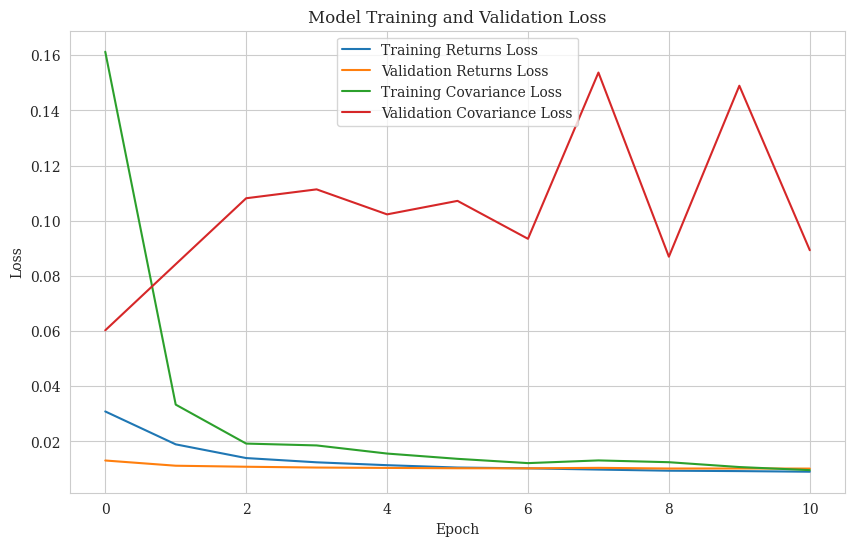

In [31]:
print("Preparing data for LSTM model...")

# Separate feature columns from target columns
feature_cols = [c for c in features_and_target_df.columns if not (c.endswith('_TARGET') or c.startswith('COV_TARGET_'))]

# Identify return target columns and covariance target columns
return_target_cols = [c for c in features_and_target_df.columns if c.endswith('_TARGET') and not c.startswith('COV_TARGET_')]
cov_target_cols = [c for c in features_and_target_df.columns if c.startswith('COV_TARGET_')]

# Determine the number of targets
num_return_targets = len(return_target_cols)
num_cov_targets = len(cov_target_cols)
print(f"Number of return targets: {num_return_targets}")
print(f"Number of covariance targets: {num_cov_targets}")

# Extract features and targets
X = features_and_target_df[feature_cols].values
y_returns = features_and_target_df[return_target_cols].values
y_cov = features_and_target_df[cov_target_cols].values

# Scale features and targets separately
feature_scaler = MinMaxScaler(feature_range=(-1, 1))
returns_scaler = MinMaxScaler(feature_range=(-1, 1)) # Scaler for return targets
cov_scaler = MinMaxScaler(feature_range=(-1, 1))     # Scaler for covariance targets

X_scaled = feature_scaler.fit_transform(X)
y_returns_scaled = returns_scaler.fit_transform(y_returns)
y_cov_scaled = cov_scaler.fit_transform(y_cov)

# --- 2. Create Sequences ---
def create_sequences(X_data, y_returns_data, y_cov_data, window_size):
    X_seq, y_returns_seq, y_cov_seq = [], [], []
    for i in range(len(X_data) - window_size):
        X_seq.append(X_data[i:(i + window_size)])
        y_returns_seq.append(y_returns_data[i + window_size])
        y_cov_seq.append(y_cov_data[i + window_size])
    return np.array(X_seq), np.array(y_returns_seq), np.array(y_cov_seq)

X_seq, y_returns_seq, y_cov_seq = create_sequences(X_scaled, y_returns_scaled, y_cov_scaled, LOOKBACK_WINDOW)

# --- 3. Train/Val/Test Split (Temporal) ---
n_samples = len(X_seq)
train_end = int(n_samples * TRAIN_SPLIT)
val_end = int(n_samples * (TRAIN_SPLIT + VALIDATION_SPLIT))

X_train, y_train_returns, y_train_cov = X_seq[:train_end], y_returns_seq[:train_end], y_cov_seq[:train_end]
X_val, y_val_returns, y_val_cov = X_seq[train_end:val_end], y_returns_seq[train_end:val_end], y_cov_seq[train_end:val_end]
X_test, y_test_returns, y_test_cov = X_seq[val_end:], y_returns_seq[val_end:], y_cov_seq[val_end:]

print(f"X_train shape: {X_train.shape}, y_train_returns shape: {y_train_returns.shape}, y_train_cov shape: {y_train_cov.shape}")
print(f"X_val shape: {X_val.shape}, y_val_returns shape: {y_val_returns.shape}, y_val_cov shape: {y_val_cov.shape}")
print(f"X_test shape: {X_test.shape}, y_test_returns shape: {y_test_returns.shape}, y_test_cov shape: {y_test_cov.shape}")

# --- 4. Model Architecture & Training (Modified) ---
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

@tf.keras.utils.register_keras_serializable()
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        return K.sum(output, axis=1)

input_shape = (X_train.shape[1], X_train.shape[2])

def create_advanced_bilstm_model(input_shape, num_return_targets, num_cov_targets, lstm_units, dropout_rate):
    inputs = tf.keras.Input(shape=input_shape)
    x = Bidirectional(LSTM(lstm_units[0], return_sequences=True))(inputs)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(lstm_units[1], return_sequences=True))(x)
    x = Dropout(dropout_rate)(x)
    attention_output = Attention()(x)
    x = Dropout(dropout_rate)(attention_output)

    # Output for returns
    returns_output = Dense(num_return_targets, activation='tanh', name='returns_output')(x)

    # Output for covariance
    covariance_output = Dense(num_cov_targets, activation='linear', name='covariance_output')(x)

    model = tf.keras.Model(inputs=inputs, outputs=[returns_output, covariance_output])
    model.compile(optimizer='adam', loss={'returns_output': Huber(), 'covariance_output': 'mean_squared_error'})
    return model

model = create_advanced_bilstm_model(input_shape, num_return_targets, num_cov_targets, LSTM_UNITS, DROPOUT_RATE)
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('bilstm_best_model.keras', save_best_only=True, monitor='val_loss')

print("\n--- Starting Model Training ---")
history = model.fit(
    X_train,
    {'returns_output': y_train_returns, 'covariance_output': y_train_cov},
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, {'returns_output': y_val_returns, 'covariance_output': y_val_cov}),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
print("--- Model Training Complete ---")

# --- 5. Plot Training History ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['returns_output_loss'], label='Training Returns Loss')
plt.plot(history.history['val_returns_output_loss'], label='Validation Returns Loss')
plt.plot(history.history['covariance_output_loss'], label='Training Covariance Loss')
plt.plot(history.history['val_covariance_output_loss'], label='Validation Covariance Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


--- Starting NSGA-II Optimization ---
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     15 |  0.000000E+00 |  9.658940E-17 |             - |             -
     2 |      200 |     20 |  0.000000E+00 |  7.771561E-18 |  0.1149331064 |         ideal
     3 |      300 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0142792050 |         ideal
     4 |      400 |     30 |  0.000000E+00 |  0.000000E+00 |  0.0855466185 |         ideal
     5 |      500 |     37 |  0.000000E+00 |  0.000000E+00 |  0.1158089917 |         nadir
     6 |      600 |     31 |  0.000000E+00 |  0.000000E+00 |  0.0704886988 |         ideal
     7 |      700 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0359487245 |         ideal
     8 |      800 |     36 |  0.000000E+00 |  0.000000E+00 |  0.1284875767 |         ideal
     9 |      900 |     33 |  0.000000E+00 |  0.000000E+00 |  0.0799447047 |         ideal
    10 |     1000 |     24 |  0.000000E+00 |  0.000

,Return,Dividend,Volatility,CVaR_95,Sharpe,AAPL,GOOG,MSFT,NVDA,AMZN,AMD,INTC,META,COST,PG,KO,PEP,WMT,CME,AVGO,PFE,ABBV,HD,XOM,VDE,SCHD,VYM,VWO,VEA,GLD,SLV,FXY,FDIVX,TLT,SPLB
60,0.484494,2.865812,0.149669,0.556043,3.103484,0.011404,0.020159,0.011696,0.010417,0.009704,0.010030,0.029520,0.011190,0.076365,0.032863,0.091990,0.088576,0.090700,0.087046,0.009576,0.024359,0.088959,0.081317,0.056326,0.014867,0.015399,0.020732,0.011006,0.011798,0.010209,0.012255,0.026747,0.009734,0.013781,0.011275
50,0.501418,2.802295,0.164510,0.505947,2.926375,0.020471,0.010251,0.011257,0.010852,0.009683,0.009932,0.013509,0.015796,0.080767,0.035060,0.053436,0.093579,0.092043,0.093199,0.030778,0.045463,0.091154,0.052910,0.053185,0.019449,0.013978,0.020232,0.015919,0.010869,0.010668,0.022247,0.030263,0.010208,0.012957,0.009884
59,0.518873,2.400438,0.176276,0.631644,2.830062,0.012625,0.020624,0.012420,0.011497,0.010821,0.011014,0.035251,0.017543,0.012587,0.045544,0.064598,0.041463,0.103526,0.084925,0.039121,0.054232,0.101599,0.061051,0.067097,0.014650,0.015898,0.017802,0.014408,0.018569,0.013604,0.024092,0.035512,0.010977,0.013245,0.013703
71,0.528820,2.403109,0.186088,0.612516,2.734304,0.012479,0.020545,0.012290,0.012460,0.010717,0.010903,0.026594,0.018042,0.012462,0.045091,0.101001,0.041051,0.102561,0.084706,0.038601,0.052794,0.098208,0.060050,0.062099,0.014481,0.016993,0.018531,0.014265,0.018362,0.015165,0.014567,0.029806,0.010868,0.013116,0.011191
40,0.413457,2.424174,0.146056,0.407448,2.693889,0.045199,0.016250,0.009455,0.009739,0.007861,0.008883,0.022511,0.012233,0.075149,0.027041,0.047091,0.055356,0.061829,0.070885,0.029763,0.038500,0.071721,0.065901,0.045853,0.017178,0.023627,0.016896,0.012454,0.015313,0.009667,0.073803,0.072088,0.007584,0.020978,0.009191


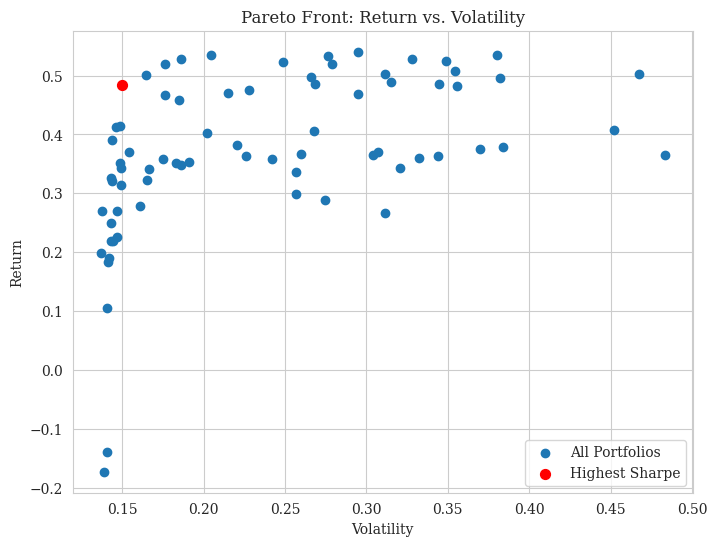

In [32]:
# --- 3. Run the Optimization ---
print("\n--- Starting NSGA-II Optimization ---")
# Calculate average annual dividend yield for each asset
# Convert polars DFs to pandas for this section
price_df_pd = price_df.to_pandas().set_index('Date')
dividend_df_pd = dividend_df.to_pandas().set_index('Date')

# --- Prepare inputs for the optimizer ---
# Expected Returns (mu) from Bi-LSTM predictions
# We will use the mean of the predicted simple returns for the entire test set as 'mu'
mu = predicted_returns_df.mean().values

# The predicted_cov_matrices_time_series contains individual covariance matrices for each time step in the test set.
# This will be passed directly to the problem and handled in its _evaluate method.

n_years = len(price_df_pd.index.year.unique())
avg_annual_yield = (dividend_df_pd.sum() / n_years).values

problem = PortfolioOptimizationProblem(mu, avg_annual_yield,
                                     predicted_simple_returns, # Use the actual array of predicted simple returns
                                     predicted_cov_matrices_time_series, # Pass the list of predicted matrices
                                     test_dates, # Pass the corresponding test dates
                                     MIN_WEIGHT_PER_ASSET,
                                     MAX_WEIGHT_PER_ASSET,
                                     TARGET_DIVIDEND_YIELD)

algorithm = NSGA2(pop_size=POPULATION_SIZE)

res = minimize(problem,
               algorithm,
               ('n_gen', N_GENERATIONS),
               seed=1,
               verbose=True)

print("--- Optimization Complete ---")

# --- 4. Process and Display Results ---
pareto_weights = res.X
pareto_objectives = res.F

# Normalize weights again to be safe
pareto_weights = pareto_weights / pareto_weights.sum(axis=1, keepdims=True)

pareto_front_df = pd.DataFrame({
    'Return': -pareto_objectives[:, 0],
    'Dividend': -pareto_objectives[:, 1],
    'Volatility': pareto_objectives[:, 2],
    'CVaR_95': -pareto_objectives[:, 3]
})
pareto_front_df['Sharpe'] = (pareto_front_df['Return'] - 0.02) / pareto_front_df['Volatility'] # Assuming 2% risk-free rate

weights_df = pd.DataFrame(pareto_weights, columns=PORTFOLIO_TICKERS)
pareto_results = pd.concat([pareto_front_df, weights_df], axis=1)

print("\nPareto Front Optimal Portfolios:")
display(pareto_results.sort_values('Sharpe', ascending=False).head())

# --- 5. Visualize the Pareto Front ---
plot = Scatter(title = "Pareto Front: Return vs. Volatility",
               labels=["Volatility", "Return"],
               legend=True)
plot.add(pareto_objectives[:, [2, 0]] * np.array([1, -1]), label="All Portfolios")

# Highlight the portfolio with the highest Sharpe ratio
best_sharpe_idx = pareto_results['Sharpe'].idxmax()
best_sharpe_portfolio = pareto_objectives[best_sharpe_idx, [2, 0]] * np.array([1, -1])
plot.add(best_sharpe_portfolio, color="red", s=50, label="Highest Sharpe")

plot.show()

Selecting portfolio with the highest Sharpe Ratio for backtesting...

Selected Portfolio Weights (allocations > 1%):


,60
KO,0.091990
WMT,0.090700
ABBV,0.088959
PEP,0.088576
CME,0.087046
HD,0.081317
COST,0.076365
XOM,0.056326
PG,0.032863
INTC,0.029520



Backtest Performance Summary:


,Optimized Portfolio,Benchmark (SPY)
Cumulative Return,50.87%,66.02%
Annualized Return,16.62%,21.03%
Annualized Volatility,10.27%,15.46%
Sharpe Ratio,1.42,1.23
Max Drawdown,-10.98%,-18.76%


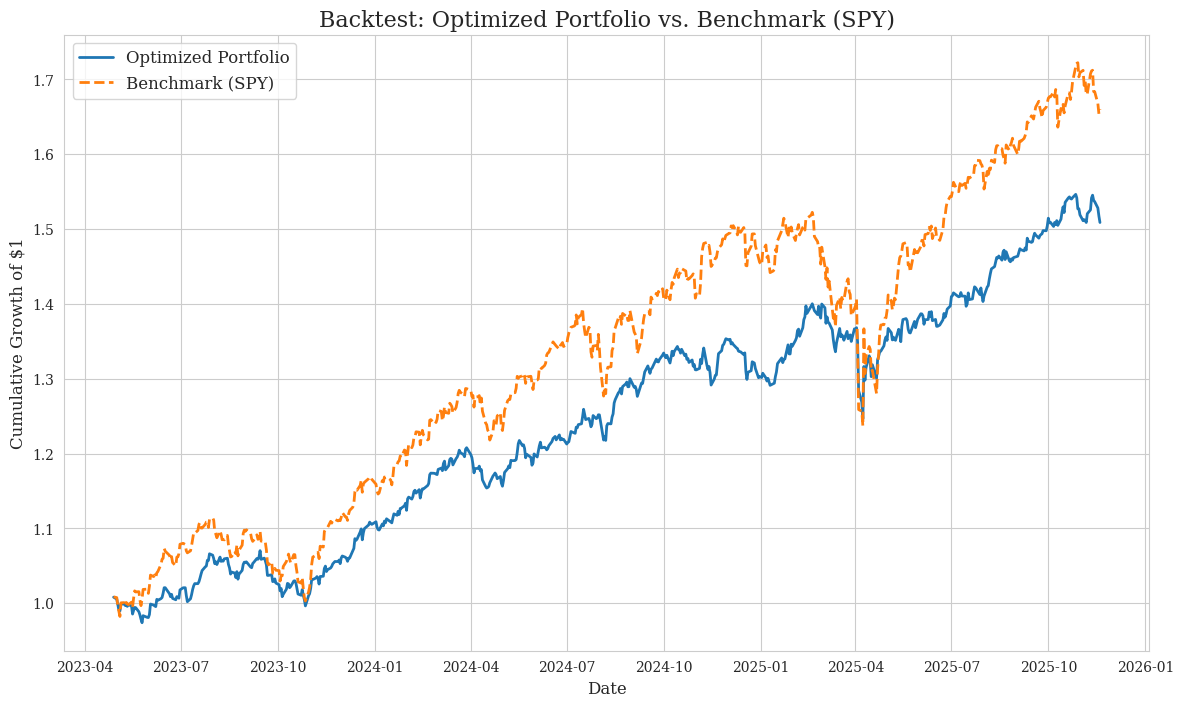

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Select the Best Portfolio for Backtesting ---
print("Selecting portfolio with the highest Sharpe Ratio for backtesting...")
best_sharpe_idx = pareto_results['Sharpe'].idxmax()
selected_portfolio = pareto_results.loc[best_sharpe_idx]
selected_weights = selected_portfolio[PORTFOLIO_TICKERS]

print("\nSelected Portfolio Weights (allocations > 1%):")
display(selected_weights[selected_weights > 0.01].sort_values(ascending=False))

# --- 2. Calculate Historical Performance ---
# Use the ACTUAL returns from the test period, not the predicted returns
test_dates_start = features_and_target_df.index[val_end + LOOKBACK_WINDOW]

# Removed redundant calculations. Assuming 'price_df_pd' is the correct DataFrame.
actual_returns_test = price_df_pd.loc[test_dates_start:, PORTFOLIO_TICKERS].pct_change().dropna()
benchmark_returns_test = price_df_pd.loc[test_dates_start:, BENCHMARK_TICKER].pct_change().dropna()

# Align indices before matrix multiplication
aligned_weights = selected_weights.values
aligned_returns, aligned_benchmark = actual_returns_test.align(benchmark_returns_test, join='inner', axis=0)

portfolio_historical_returns = (aligned_returns * aligned_weights).sum(axis=1)

# --- 3. Calculate Performance Metrics ---
def calculate_metrics(returns, risk_free_rate=0.02):
    """Calculates key performance metrics for a series of returns."""
    if returns.empty:
        return pd.Series({k: 'N/A' for k in ['Cumulative Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown']})

    cumulative_return = (1 + returns).prod() - 1
    annualized_return = returns.mean() * 252
    annualized_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility != 0 else 0

    # Max Drawdown Calculation
    cumulative_wealth = (1 + returns).cumprod()
    peak = cumulative_wealth.cummax()
    drawdown = (cumulative_wealth - peak) / peak
    max_drawdown = drawdown.min()

    return pd.Series({
        'Cumulative Return': f"{cumulative_return:.2%}",
        'Annualized Return': f"{annualized_return:.2%}",
        'Annualized Volatility': f"{annualized_volatility:.2%}",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Max Drawdown': f"{max_drawdown:.2%}"
    })

# Define the risk-free rate as a constant for clarity
RISK_FREE_RATE = 0.02
portfolio_metrics = calculate_metrics(portfolio_historical_returns, risk_free_rate=RISK_FREE_RATE)
benchmark_metrics = calculate_metrics(aligned_benchmark, risk_free_rate=RISK_FREE_RATE)

performance_summary = pd.DataFrame({'Optimized Portfolio': portfolio_metrics, 'Benchmark (SPY)': benchmark_metrics})

print("\nBacktest Performance Summary:")
display(performance_summary)

# --- 5. Visualize Performance ---
plt.figure(figsize=(14, 8))

# Use the pre-aligned returns series for consistency and robustness
cumulative_portfolio_returns = (1 + portfolio_historical_returns).cumprod()
cumulative_benchmark_returns = (1 + aligned_benchmark).cumprod()

plt.plot(cumulative_portfolio_returns.index, cumulative_portfolio_returns, label='Optimized Portfolio', lw=2)
plt.plot(cumulative_benchmark_returns.index, cumulative_benchmark_returns, label='Benchmark (SPY)', linestyle='--', lw=2)

plt.title('Backtest: Optimized Portfolio vs. Benchmark (SPY)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Growth of $1', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()
